**Ronaldlee Ejalu**  
**CSC 578:910**

# CSC 578 NN&DL Spring, 2022
## HW7: Image Classification using a CNN



This code is slightly modified from the TensorFlow tutorial [Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn) for the purpose of our homework. The code first downloads the data, the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) and partitions the training set into training and validation sets. Then the code builds a CNN network and trains the network with the training set. Finally the code evaluates the network performance using the validation set.

Note that there are **three places** in the code, indicated with **IMPORTANT**, where you have to choose the syntax that works for the version of TensorFlow (1 or 2) installed on your platform.

### Import Tensorflow
**IMPORTANT (1)**
Uncomment either import line(s) for the version of TensorFlow (TF1 or TF2) of your platform.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)  # check the TF version!

2.8.0
time: 1.68 ms (started: 2022-05-29 10:01:53 +00:00)


In [ ]:
# For TF version 2 (just one line)
from tensorflow.keras import datasets, layers, models

# For TF version 1 (need both lines)
# from tensorflow import keras
# from keras import datasets, layers, models

time: 1.59 ms (started: 2022-05-29 10:01:56 +00:00)


In [ ]:
#!pip install -q --upgrade ipython
# !pip install -q --upgrade ipykernel

time: 517 µs (started: 2022-05-29 10:01:56 +00:00)


In [ ]:
#!pip install -U ipykernel
#!pip install modin[dask]

time: 454 µs (started: 2022-05-29 10:01:56 +00:00)


### Import Other packages

In [ ]:
# import othe packages
import csv
import time
import pandas as pd
import numpy as np
from tensorflow.keras.regularizers import l1_l2, l1, l2
# for data Augmentation
from tensorflow.keras import Sequential 
from tensorflow.keras.utils import to_categorical # for processing the categorical labels
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

time: 4.27 ms (started: 2022-05-30 02:38:51 +00:00)


In [ ]:
EPOCHS = 30

time: 624 µs (started: 2022-05-29 10:01:56 +00:00)


In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.54 s (started: 2022-05-29 16:21:13 +00:00)


### Mount the Google drive

In [ ]:
# mount my Google Drive
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.54 s (started: 2022-05-29 16:21:17 +00:00)


In [ ]:
# Change the working directory to hw7
import os
os.chdir('/content/drive/MyDrive/CSC578/hw7')

time: 1.4 ms (started: 2022-05-29 22:55:32 +00:00)


### Helper functions

In [ ]:
def writeResultsToCsv(predictions_L):
  """Function that writes the predictions Results to a csv file"""
  filePath = '/content/drive/MyDrive/CSC578/hw7/predictionResults.csv'
  with open(filePath, 'w') as csvFile:
    column_L = ['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
    # create a Writer object
    csvWriter = csv.writer(csvFile, delimiter=',' , quotechar='|', quoting=csv.QUOTE_MINIMAL) #lineterminator='\n'
    # write the header rows to the file 
    csvWriter.writerow(column_L)
    lineCnt = 1
    # loop through the list and write each item to a csv file
    for itemList in range(len(predictions_L)):
      csvWriter.writerow([lineCnt, predictions_L[itemList][0], predictions_L[itemList][1], predictions_L[itemList][2], 
          predictions_L[itemList][3], predictions_L[itemList][4], predictions_L[itemList][5], 
          predictions_L[itemList][6], predictions_L[itemList][7], predictions_L[itemList][8], predictions_L[itemList][9]])
      # increment lineCnt by 1
      lineCnt += 1 

time: 13 ms (started: 2022-05-29 16:21:22 +00:00)


In [ ]:
def generatePlot(history_D, titleStr='batch size'):
  """
  Function takes a dictionary of History callbacks and 
  plots line charts for the different mini batch sizes
  """
  # print('Training and validation loss line charts for the different mini batch sizes')
  # loop through the history dictionary to access the different items
  for key, value in history_D.items():
    # set the figure
    plt.figure(figsize=(10, 7))
    line_mse = plt.plot(range(0,EPOCHS), value.history['loss'], 'r')
    line_crossEntropy = plt.plot(range(0,EPOCHS), value.history['val_loss'], '#cdc50a')
    global hyperParam 
    hyperParam= titleStr
    if hyperParam == 'batch size':
      var_title = hyperParam

    elif hyperParam == 'learning rate':
      var_title = hyperParam

    elif hyperParam == 'l1 regularization with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l1 regularization applied within Dense layer with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization applied within Dense layer with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization applied within Convolutional and Dense layer with lambda value':
      var_title = hyperParam
    
    elif hyperParam == 'dropout value':
      var_title = hyperParam
    elif hyperParam == 'number_of_filters_used':
      var_title = hyperParam
    elif hyperParam == 'dense number units used are':
      var_title = hyperParam
    elif hyperParam == 'size of filter used':
      var_title = hyperParam
    elif hyperParam == 'stride used is':
      var_title = hyperParam
    plt.title('Train vs. Validation loss: when ' + var_title +' = ' + str(key))
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.legend(['Training loss', 'validation loss'])
    print('\n')

time: 32.3 ms (started: 2022-05-29 16:21:25 +00:00)


In [ ]:
def generate_accuracy_Plot(history_D, titleStr='batch size'):
  """
  Function takes a dictionary of History callbacks and 
  plots line charts for the different mini batch sizes
  """
  #print('Training and validation loss line charts for the different mini batch sizes')
  # loop through the history dictionary to access the different items
  for key, value in history_D.items():
    # set the figure
    plt.figure(figsize=(10, 7))
    line_mse = plt.plot(range(0,EPOCHS), value.history['accuracy'], 'r')
    line_crossEntropy = plt.plot(range(0,EPOCHS), value.history['val_accuracy'], '#cdc50a')
    global hyperParam 
    hyperParam= titleStr
    if hyperParam == 'batch size':
      var_title = hyperParam

    elif hyperParam == 'learning rate':
      var_title = hyperParam

    elif hyperParam == 'l1 regularization with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l1 regularization applied within Dense layer with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization applied within Dense layer with lambda value':
      var_title = hyperParam

    elif hyperParam == 'l2 regularization applied within Convolutional and Dense layer with lambda value':
      var_title = hyperParam
    
    elif hyperParam == 'dropout value':
      var_title = hyperParam
    elif hyperParam == 'number_of_filters_used':
      var_title = hyperParam
    elif hyperParam == 'dense number units used are':
      var_title = hyperParam
    elif hyperParam == 'size of filter used':
      var_title = hyperParam
    elif hyperParam == 'stride used is':
      var_title = hyperParam
    plt.title('Train vs. Validation accuracy: when ' + var_title +' = ' + str(key))
    plt.ylabel('accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training accuracy', 'validation accuracy'])
    print('\n')

time: 31.5 ms (started: 2022-05-29 16:21:28 +00:00)


In [ ]:
def buildbestModel(mini_batch_size=64, eta=None, lambda_v=None, dropout=None, added_CNN_layer=None):
  """A function that returns the model's history"""
  v_added_CNN_layers = added_CNN_layer
  #seed = 7 
  if v_added_CNN_layers == 'Added more Convolution layers':
    print('Debugging if statement: %s' %v_added_CNN_layers)
    model = models.Sequential()
      
    model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', activation='relu', kernel_regularizer=l2(lambda_v),input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    
    model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    
    model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # first dropout
    model.add(layers.Dropout(dropout))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # last dropout
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(10, activation='softmax'))  # As noted above
    model.summary()

  elif lambda_v is None:
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # As noted above

  elif lambda_v is not None and dropout is not None:
    print('lambda and dropout are not null')

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(lambda_v),input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(lambda_v), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(lambda_v), activation='relu'))

    # first dropout
    model.add(layers.Dropout(dropout))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # last dropout
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(10, activation='softmax'))  # As noted above

  else:
    print('lambda_v is not null')
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(lambda_v),input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(lambda_v), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(lambda_v), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # As noted above

  # if dropout is None:


  learningRate = eta
  if learningRate is None :
    # compile the model
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  else:
    # set the learning rate
    print('learning rate is given')
    opt = tf.keras.optimizers.Adam(learning_rate=learningRate)
    model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])

  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=mini_batch_size, 
                      validation_data=(valid_images, valid_labels))
  return history

time: 119 ms (started: 2022-05-29 16:21:31 +00:00)


In [ ]:
def saveModel(modelName):
  """Function that saves the current model for future use"""
  model.save(modelName)

time: 1.1 ms (started: 2022-05-29 16:21:34 +00:00)


In [ ]:
def load_saved_model(modelName):
  """Function that returns the saved model"""
  return tf.keras.models.load_model(modelName)

time: 1.33 ms (started: 2022-05-29 16:21:36 +00:00)


In [ ]:
def deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, columnName):
  """A function that returns pandas data frames for losss, accuracy and run time execution"""
  column_Name = columnName
  if column_Name == 'Mini-batch-size':
    hyperParamName = column_Name
  elif column_Name == 'learningRate':
    hyperParamName = column_Name
  elif column_Name == 'lambda':
    hyperParamName = column_Name
  elif columnName == 'dropout':
    hyperParamName = columnName
  elif columnName == 'filter_pairs_used':
    hyperParamName = columnName
  elif columnName == 'number_of_units_used':
    hyperParamName = columnName
  elif columnName == 'size_of_filter':
    hyperParamName = columnName
  elif columnName == 'size_of_stride':
    hyperParamName = columnName
  # build the loss data frame
  val_loss_df = pd.DataFrame(val_loss_L, columns = [hyperParamName, 'val_loss'])
  # build the accuracy data frame
  val_accuracy_df = pd.DataFrame(val_accuracy_L, columns = [hyperParamName,'val_accuracy_L'])
  # build the run time data frame
  recordTime_df = pd.DataFrame(recordTime_L, columns = [hyperParamName, 'Time in seconds'])
  return val_loss_df, val_accuracy_df, recordTime_df

time: 9.33 ms (started: 2022-05-29 16:21:37 +00:00)


In [ ]:
def deriveAccuracy_df(train_loss_L, train_accuracy_L, columnName):
  """Function that derives and returns the train loss and accuracy data frames"""
  column_Name = columnName
  if columnName == 'size_of_stride':
    hyperParamName = columnName
  elif columnName == 'filter_pairs_used':
    hyperParamName = columnName
  elif columnName == 'number_of_units_used':
      hyperParamName = columnName
  elif columnName == 'dropout':
    hyperParamName = columnName

  train_loss_df = pd.DataFrame(train_loss_L, columns = [hyperParamName, 'train_loss'])
  train_accuracy_df = pd.DataFrame(train_accuracy_L, columns = [hyperParamName, 'train_accuracy'])
  return train_loss_df, train_accuracy_df

time: 4.55 ms (started: 2022-05-29 16:21:40 +00:00)


In [ ]:
def deriveLossAccuracyLineCharts(history, plottitle=None):
  """Function that plot the line charts for the loss and accuracy of the model"""
  history = history
  titleStr = plottitle

  if titleStr == 'Accuracy & loss vs Number of epochs when Nadam optimizer is used':
    title_param = titleStr
  else:
    title_param = 'Accuracy & loss vs Number of epochs when Adam optimizer is used'
  plt.figure(figsize=(10, 7))
  line_mse = plt.plot(range(0,EPOCHS), history['loss'], 'r')
  line_accuracy = plt.plot(range(0,EPOCHS), history['accuracy'],linestyle = 'dashed', color = 'b')
  line_crossEntropy = plt.plot(range(0,EPOCHS), history['val_loss'], '#cdc50a')
  line_valaccuracy = plt.plot(range(0,EPOCHS), history['val_accuracy'], linestyle = 'dashed', color='#7CFC00')
  plt.title(title_param)
  plt.ylabel('Loss/Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['Training loss', 'Training accuracy', 'validation loss', 'validation accuracy'])
  print('\n')

time: 10.6 ms (started: 2022-05-29 16:21:42 +00:00)


### Download and prepare the CIFAR10 dataset¶

The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is (pre-)divided into 50,000 training images and 10,000 testing images.


In [ ]:
# Download the data from the repository site.
(train_all_images, train_all_labels), (test_images, test_labels) = datasets.cifar10.load_data()

time: 625 ms (started: 2022-05-29 22:04:47 +00:00)


In [ ]:
# !! DO NOT REMOVE THIS LINE !!
# Delete test_labels (by making it an empty list) so that we don't accidentally
# use it in the code.
test_labels = []

# Then split the training set ('train_all') into two subsets: train and 
# validation.  After that, we have 3 subsets: train, validation and test.
from sklearn.model_selection import train_test_split

# 80% train, 20% validation, and by using stratefied sampling.  
train_images, valid_images, train_labels, valid_labels \
  = train_test_split(train_all_images, train_all_labels,
                     stratify=train_all_labels, test_size=0.2)


time: 222 ms (started: 2022-05-29 22:04:49 +00:00)


In [ ]:
# Normalize pixel values of images to be between 0 and 1
train_images, valid_images, test_images \
  = train_images / 255.0, valid_images / 255.0, test_images / 255.0

time: 267 ms (started: 2022-05-29 22:04:53 +00:00)


In [ ]:
train_labels

array([[9],
       [4],
       [6],
       ...,
       [4],
       [5],
       [4]], dtype=uint8)

time: 5.31 ms (started: 2022-05-29 10:02:39 +00:00)


In [ ]:
valid_labels

array([[0],
       [2],
       [9],
       ...,
       [4],
       [0],
       [8]], dtype=uint8)

time: 4.57 ms (started: 2022-05-29 10:02:39 +00:00)


### Verify the data
To verify that the dataset looks correct, plot the first 10 images from the training set and display the class name below each image.

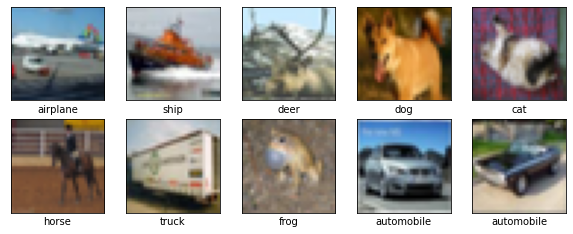

time: 360 ms (started: 2022-05-29 22:05:04 +00:00)


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create a convolutional network
As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size, where color_channels refers to (R,G,B). The format of CIFAR images is 32 * 32 pixels, so the input shape is (32, 32, 3). The output layer has 10 nodes, corresponding to the number of categories of the images.

In this code, the activation function of the output layer is specified to be softmax for the purpose of aligning the two versions of TensorFlow (TF1 and TF2; in particular to make TF2 compatible with TF1's 'sparse_categorical_crossentropy' loss function).

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # As noted above

time: 4.32 s (started: 2022-05-29 10:02:40 +00:00)


Verify the model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

### Compile the model
**IMPORTANT (2)** Uncomment either loss function for the version of TensorFlow (TF1 or TF2) of your platform.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])


time: 18.9 ms (started: 2022-05-29 10:02:44 +00:00)


### Train the model

In [ ]:
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(valid_images, valid_labels))

Epoch 1/10
1250/1250 [==============================] - 17s 4ms/step - loss: 1.5479 - accuracy: 0.4397 - val_loss: 1.3517 - val_accuracy: 0.5104
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1993 - accuracy: 0.5750 - val_loss: 1.1852 - val_accuracy: 0.5826
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0463 - accuracy: 0.6332 - val_loss: 1.0345 - val_accuracy: 0.6334
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9496 - accuracy: 0.6661 - val_loss: 1.0707 - val_accuracy: 0.6273
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8760 - accuracy: 0.6944 - val_loss: 0.9916 - val_accuracy: 0.6505
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8067 - accuracy: 0.7175 - val_loss: 0.9384 - val_accuracy: 0.6754
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.7517 - accuracy: 0.7354 - val_loss: 0.9865 - val_accuracy

### Evaluate the model
**IMPORTANT (3)** Uncomment either syntax for the version of TensorFlow (TF1 or TF2) of your platform.

313/313 - 1s - loss: 0.9497 - accuracy: 0.6874 - 675ms/epoch - 2ms/step
valid_accuracy=0.6873999834060669, valid_loss=0.9497246146202087


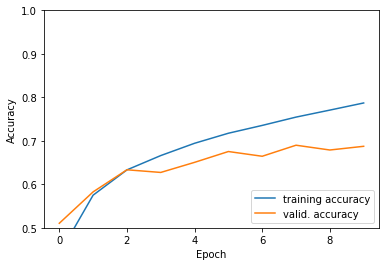

time: 1.08 s (started: 2022-05-29 10:03:46 +00:00)


In [ ]:
plt.plot(history.history['accuracy'], label='training accuracy') # For TF2
#plt.plot(history.history['acc'], label='training accuracy') # For TF1
plt.plot(history.history['val_accuracy'], label = 'valid. accuracy') # For TF2
#plt.plot(history.history['val_acc'], label = 'valid. accuracy') # For TF1
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Evaluate the learned model with validation set
valid_loss, valid_acc = model.evaluate(valid_images, valid_labels, verbose=2) 
print ("valid_accuracy=%s, valid_loss=%s" % (valid_acc, valid_loss))

In [ ]:
# save our model for future use
model.save('CNN_image_classification.model')

INFO:tensorflow:Assets written to: CNN_image_classification.model/assets
time: 2.45 s (started: 2022-05-29 10:03:47 +00:00)


In [ ]:
# loading the saved model
savedModel = tf.keras.models.load_model('CNN_image_classification.model')

time: 404 ms (started: 2022-05-29 10:03:49 +00:00)


### TO DO (by you): Make Predictions
Apply the learned network to **'test_images'** and generate predictions.

Look at the code from HW#4 or other tutorial code for the syntax. You should generate predictions and create/write a KAGGLE submission file.

In [ ]:
# let's make a prediction
predictions = savedModel.predict([test_images])
#type(predictions)

time: 803 ms (started: 2022-05-29 10:03:50 +00:00)


In [ ]:
# let's convert a numpy array into a list
predictions_L = predictions.tolist()

time: 6.02 ms (started: 2022-05-29 10:03:50 +00:00)


### Writing the Predictions to a csv file

In [ ]:
# helper function that writes predictions Results to a csv file
writeResultsToCsv(predictions_L)

time: 548 ms (started: 2022-05-29 10:03:50 +00:00)


# Hyperparameter Tuning

## mini-batch size

<p>These are the number of training examples at a time the network for
training. The choice of the mini‐batch size should relatively be independent of other
hyper‐parameters.Too small of a size , you don’t take full advantage of the benefits of
the matrix libraries optimized for Hardware like how Michael Nielsen mentions in the
NNDL book and too large, you are simply not updating your weights often enough.
So, trying out different values of 8, 16, 32, 64, and 100.</p>

In [ ]:
# we create a list of mini-batch size with the following values [5, 15, 25, 32, 64, 100]
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
mini_batch_size_L = [8, 16,  32, 64, 100]
recordTime_L = []                             # list of run time execution for each mini batch size
for batch_size in range(len(mini_batch_size_L)):
  
  print(mini_batch_size_L[batch_size])
  
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  # compile the model
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=mini_batch_size_L[batch_size], validation_data=(valid_images, valid_labels)
                      )
  # endtime
  endTime = time.time()

  recordTime_L.append((mini_batch_size_L[batch_size], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[mini_batch_size_L[batch_size]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([mini_batch_size_L[batch_size], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([mini_batch_size_L[batch_size], val_acc])

8
Epoch 1/30
5000/5000 [==============================] - 17s 3ms/step - loss: 1.5398 - accuracy: 0.4376 - val_loss: 1.3334 - val_accuracy: 0.5153
Epoch 2/30
5000/5000 [==============================] - 17s 3ms/step - loss: 1.1852 - accuracy: 0.5790 - val_loss: 1.1497 - val_accuracy: 0.5847
Epoch 3/30
5000/5000 [==============================] - 17s 3ms/step - loss: 1.0480 - accuracy: 0.6293 - val_loss: 1.0438 - val_accuracy: 0.6286
Epoch 4/30
5000/5000 [==============================] - 17s 3ms/step - loss: 0.9571 - accuracy: 0.6634 - val_loss: 1.0903 - val_accuracy: 0.6254
Epoch 5/30
5000/5000 [==============================] - 16s 3ms/step - loss: 0.8863 - accuracy: 0.6877 - val_loss: 1.0230 - val_accuracy: 0.6402
Epoch 6/30
5000/5000 [==============================] - 16s 3ms/step - loss: 0.8189 - accuracy: 0.7122 - val_loss: 1.1064 - val_accuracy: 0.6174
Epoch 7/30
5000/5000 [==============================] - 17s 3ms/step - loss: 0.7680 - accuracy: 0.7289 - val_loss: 0.9879 - val_

In [ ]:
for key, value in history_D.items():
  print(key, value.history.keys())

8 dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
16 dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
32 dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
64 dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
100 dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 1.54 ms (started: 2022-05-29 10:20:45 +00:00)


In [ ]:
val_loss_L

[[8, 2.112555742263794],
 [16, 1.7600488662719727],
 [32, 1.9379017353057861],
 [64, 1.2968333959579468],
 [100, 1.2361161708831787]]

time: 2.82 ms (started: 2022-05-29 10:20:45 +00:00)


In [ ]:
val_accuracy_L

[[8, 0.6509000062942505],
 [16, 0.6653000116348267],
 [32, 0.6650999784469604],
 [64, 0.6897000074386597],
 [100, 0.6840999722480774]]

time: 3.75 ms (started: 2022-05-29 10:20:45 +00:00)


In [ ]:
recordTime_L

[(8, 492.5184223651886),
 (16, 246.1579020023346),
 (32, 142.16648077964783),
 (64, 76.52130389213562),
 (100, 51.13529443740845)]

time: 3.08 ms (started: 2022-05-29 10:20:45 +00:00)


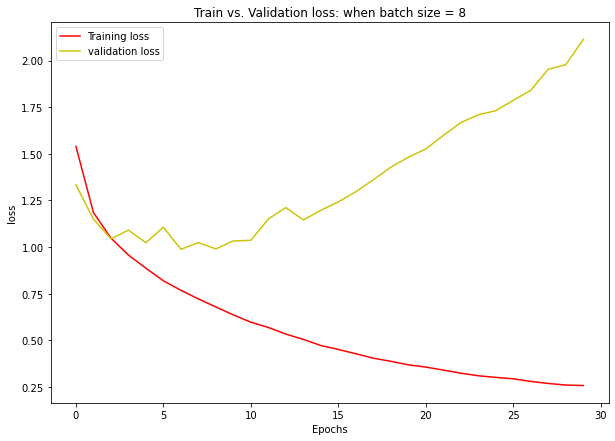

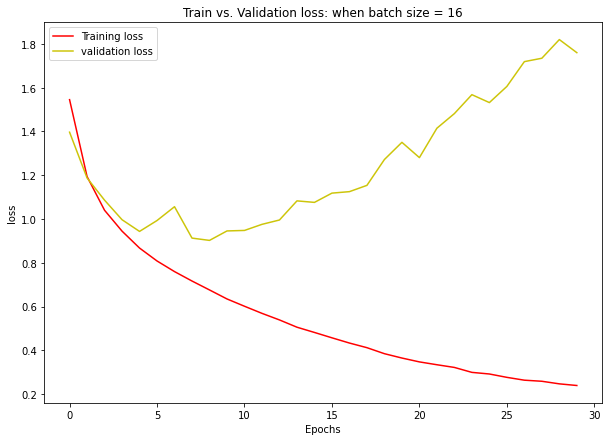

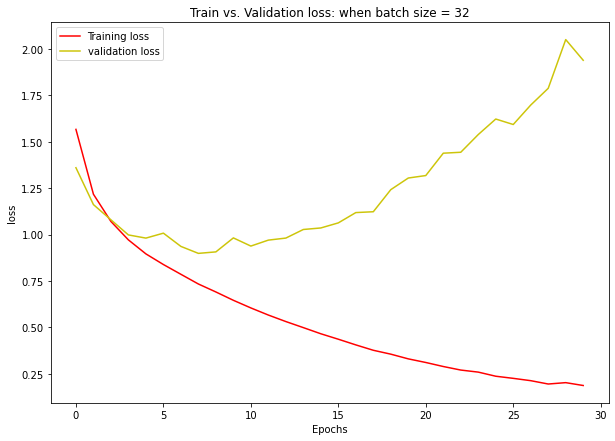

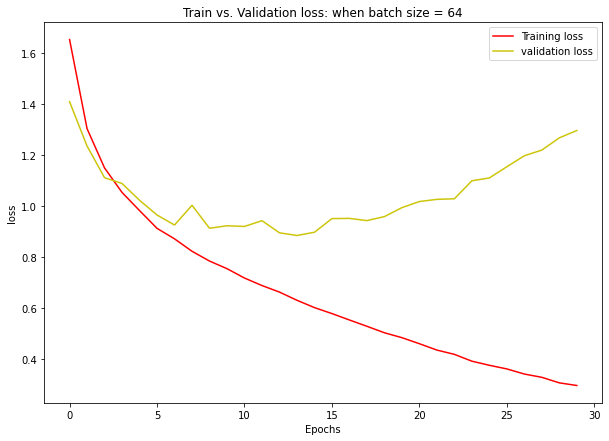

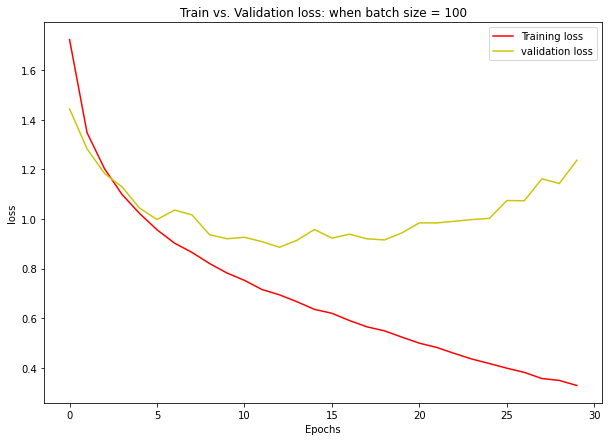

time: 1.29 s (started: 2022-05-29 10:20:45 +00:00)


In [ ]:
# a helper function used to print the line charts for the different mini batch sizes
generatePlot(history_D, 'batch size')

In [ ]:
# create different pandas data frames
val_loss_df = pd.DataFrame(val_loss_L, columns = ['Mini-batch-size', 'val_loss'])
val_loss_df

Mini-batch-size  val_loss
0                8  2.112556
1               16  1.760049
2               32  1.937902
3               64  1.296833
4              100  1.236116

time: 12.2 ms (started: 2022-05-29 10:20:47 +00:00)


In [ ]:
val_accuracy_df = pd.DataFrame(val_accuracy_L, columns = ['Mini-batch-size','val_accuracy_L'])
val_accuracy_df

Mini-batch-size  val_accuracy_L
0                8          0.6509
1               16          0.6653
2               32          0.6651
3               64          0.6897
4              100          0.6841

time: 5.77 ms (started: 2022-05-29 10:20:47 +00:00)


In [ ]:
recordTime_df = pd.DataFrame(recordTime_L, columns = ['Mini-batch-size', 'Time in seconds'])
recordTime_df

Mini-batch-size  Time in seconds
0                8       492.518422
1               16       246.157902
2               32       142.166481
3               64        76.521304
4              100        51.135294

time: 5.75 ms (started: 2022-05-29 10:20:47 +00:00)


<p>Mini-batch-size of 100 is the best value since it has a low validation loss value and it takes 35 seconds to train the network. </p>

### let's train a model with the mini-batch-size of 100

In [ ]:
# let's train the model with the mini-batch-size of 100
model.history = buildbestModel(100)

Epoch 1/30
400/400 [==============================] - 2s 5ms/step - loss: 1.6805 - accuracy: 0.3883 - val_loss: 1.4414 - val_accuracy: 0.4860
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.3351 - accuracy: 0.5197 - val_loss: 1.2937 - val_accuracy: 0.5344
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1898 - accuracy: 0.5791 - val_loss: 1.1649 - val_accuracy: 0.5881
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0916 - accuracy: 0.6146 - val_loss: 1.1214 - val_accuracy: 0.6067
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0153 - accuracy: 0.6464 - val_loss: 1.0365 - val_accuracy: 0.6356
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 0.9442 - accuracy: 0.6680 - val_loss: 0.9942 - val_accuracy: 0.6539
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 0.8882 - accuracy: 0.6907 - val_loss: 0.9899 - val_accuracy: 0.6539
Epoch 

### Save the model to the drive and reload it. 

In [ ]:
# helper function that saves the current model to the file system.
saveModel('CNN_image_classification.model')

INFO:tensorflow:Assets written to: CNN_image_classification.model/assets
time: 771 ms (started: 2022-05-29 10:21:38 +00:00)


In [ ]:
# helper function that loads the saved model
savedModel = load_saved_model('CNN_image_classification.model')

time: 386 ms (started: 2022-05-29 10:21:39 +00:00)


### Make the predictions and write the results to a csv file

In [ ]:
# let's make the required predictions
predictions = savedModel.predict([test_images])
#type(predictions)

time: 768 ms (started: 2022-05-29 10:21:40 +00:00)


In [ ]:
# let's convert a numpy array into a list
predictions_L = predictions.tolist()

time: 6.94 ms (started: 2022-05-29 10:21:40 +00:00)


In [ ]:
# helper function that writes predictions Results to a csv file
writeResultsToCsv(predictions_L)

time: 156 ms (started: 2022-05-29 10:21:40 +00:00)


## learning rate

<p>Running the network with the different values of 0.5, 0.25, 0.025 and 0.002</p>

In [ ]:
# we create a list of learning rate with the following values [0.5, 0.25, 0.025, 0.002]
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
learningRate_L = [0.5, 0.25, 0.025, 0.002, 0.001]
recordTime_L = []                             # list of run time execution for each mini batch size
for eta in range(len(learningRate_L)):
  
  # print(learningRate_L[eta])
  
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  opt = tf.keras.optimizers.Adam(learning_rate=learningRate_L[eta])
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((learningRate_L[eta], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[learningRate_L[eta]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([learningRate_L[eta], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([learningRate_L[eta], val_acc])

Epoch 1/30
400/400 [==============================] - 2s 5ms/step - loss: 68397.7031 - accuracy: 0.0993 - val_loss: 2.3134 - val_accuracy: 0.1000
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3310 - accuracy: 0.1000 - val_loss: 2.3789 - val_accuracy: 0.1000
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3311 - accuracy: 0.0980 - val_loss: 2.3275 - val_accuracy: 0.1000
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3291 - accuracy: 0.1000 - val_loss: 2.3291 - val_accuracy: 0.1000
Epoch 5/30
400/400 [==============================] - 2s 5ms/step - loss: 2.3321 - accuracy: 0.1001 - val_loss: 2.3354 - val_accuracy: 0.1000
Epoch 6/30
400/400 [==============================] - 2s 5ms/step - loss: 2.3289 - accuracy: 0.1005 - val_loss: 2.3404 - val_accuracy: 0.1000
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3343 - accuracy: 0.0993 - val_loss: 2.3241 - val_accuracy: 0.1000
Ep

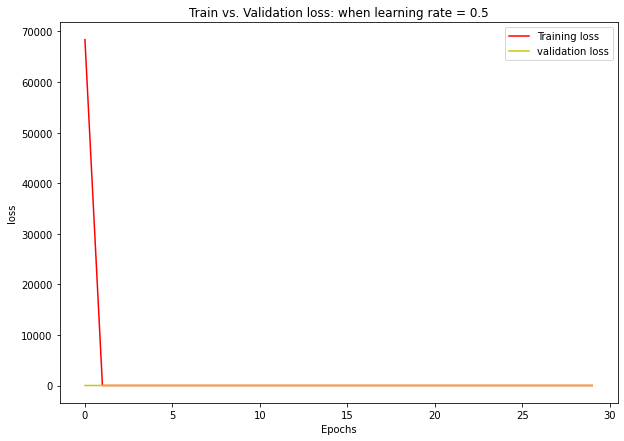

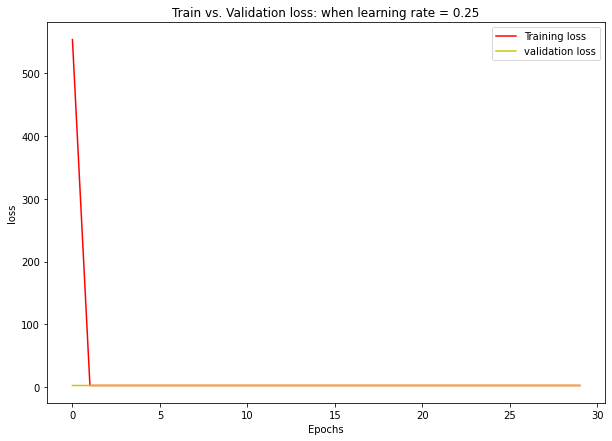

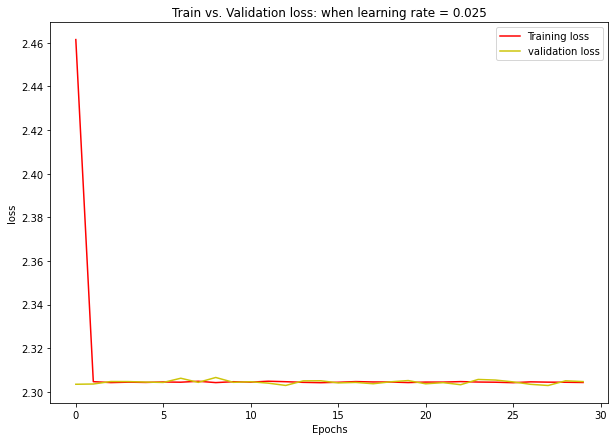

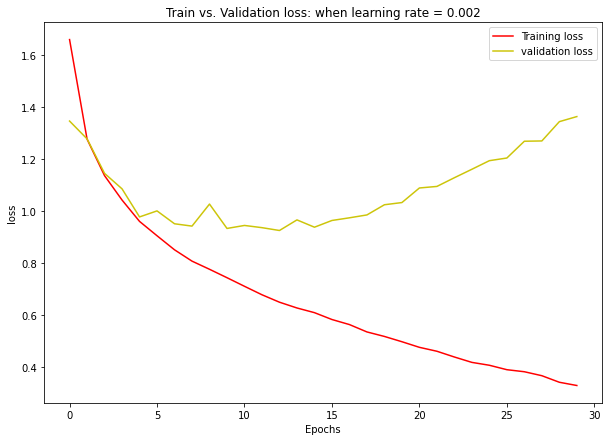

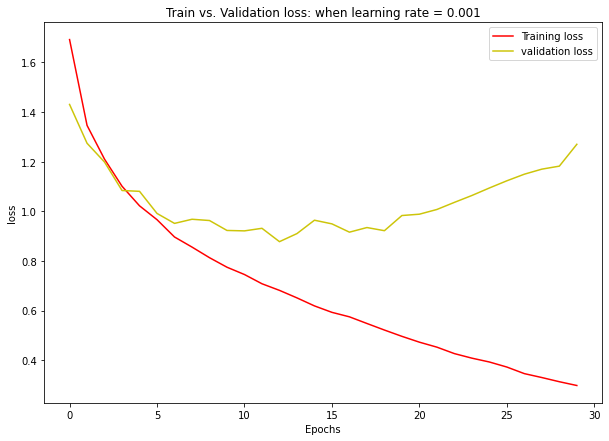

time: 1.33 s (started: 2022-05-29 10:25:59 +00:00)


In [ ]:
# a helper function used to print the line charts for the different mini batch sizes
generatePlot(history_D, 'learning rate')

In [ ]:
# a helper function that returns data frames for for losss, accuracy and run time execution
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'learningRate')

time: 2.82 ms (started: 2022-05-29 10:26:00 +00:00)


In [ ]:
val_loss_df

learningRate  val_loss
0         0.500  2.323807
1         0.250  2.326843
2         0.025  2.304710
3         0.002  1.362681
4         0.001  1.269896

time: 6.7 ms (started: 2022-05-29 10:26:00 +00:00)


In [ ]:
val_accuracy_df

learningRate  val_accuracy_L
0         0.500          0.1000
1         0.250          0.1000
2         0.025          0.1000
3         0.002          0.6713
4         0.001          0.6792

time: 4.98 ms (started: 2022-05-29 10:26:00 +00:00)


In [ ]:
recordTime_df

learningRate  Time in seconds
0         0.500        52.009999
1         0.250        49.903443
2         0.025        49.954529
3         0.002        50.220312
4         0.001        50.208180

time: 5.15 ms (started: 2022-05-29 10:26:00 +00:00)


<p>We see that the learning rate of 0.001 has the lowest validation loss and from the line chart above, we notice that validation loss is higher than training loss with less overfitting.</p>

### let's train a model with a learning rate of 0.001 and mini-batch-size of 100

In [ ]:
model_history = buildbestModel(1000, 0.001)

learning rate is given
Epoch 1/30
40/40 [==============================] - 1s 20ms/step - loss: 2.0320 - accuracy: 0.2569 - val_loss: 1.8546 - val_accuracy: 0.3260
Epoch 2/30
40/40 [==============================] - 1s 13ms/step - loss: 1.7138 - accuracy: 0.3839 - val_loss: 1.6692 - val_accuracy: 0.4000
Epoch 3/30
40/40 [==============================] - 1s 13ms/step - loss: 1.5571 - accuracy: 0.4369 - val_loss: 1.5442 - val_accuracy: 0.4454
Epoch 4/30
40/40 [==============================] - 1s 13ms/step - loss: 1.4609 - accuracy: 0.4737 - val_loss: 1.5006 - val_accuracy: 0.4476
Epoch 5/30
40/40 [==============================] - 1s 13ms/step - loss: 1.3990 - accuracy: 0.5000 - val_loss: 1.4178 - val_accuracy: 0.4965
Epoch 6/30
40/40 [==============================] - 1s 13ms/step - loss: 1.3489 - accuracy: 0.5196 - val_loss: 1.3429 - val_accuracy: 0.5283
Epoch 7/30
40/40 [==============================] - 1s 13ms/step - loss: 1.3011 - accuracy: 0.5385 - val_loss: 1.3034 - val_accurac

### Save the model to the drive and reload it. 

In [ ]:
# helper function that saves the current model to the file system.
saveModel('CNN_image_classification.model')

INFO:tensorflow:Assets written to: CNN_image_classification.model/assets
time: 775 ms (started: 2022-05-29 10:26:17 +00:00)


In [ ]:
# helper function that loads the saved model
savedModel = load_saved_model('CNN_image_classification.model')

time: 388 ms (started: 2022-05-29 10:26:18 +00:00)


### Make the predictions and write the results to a csv file

In [ ]:
# let's make the required predictions
predictions = savedModel.predict([test_images])

time: 763 ms (started: 2022-05-29 10:26:19 +00:00)


In [ ]:
# let's convert a numpy array into a list
predictions_L = predictions.tolist()

time: 5.07 ms (started: 2022-05-29 10:26:19 +00:00)


In [ ]:
# helper function that writes predictions Results to a csv file
writeResultsToCsv(predictions_L)

time: 143 ms (started: 2022-05-29 10:26:19 +00:00)


## Regularization

### L1 regularization within the Convolutional layers

<p>Using the various values of 1, 0.1, 0.01, 0.001 and 0.0001, we use <b>L1</b> regularization to train the network.</p>

In [ ]:
# we create a list of lambdas with the following values [1, 0.1, 0.01, 0.001, 0.0001]
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
lambda_L = [1, 0.1, 0.01, 0.001, 0.0001]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(lambda_L)):
  
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1(lambda_L[fact]),input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l1(lambda_L[fact]), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l1(lambda_L[fact]), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((lambda_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[lambda_L[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([lambda_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([lambda_L[fact], val_acc])

Epoch 1/30
400/400 [==============================] - 3s 5ms/step - loss: 156.0802 - accuracy: 0.1032 - val_loss: 9.2554 - val_accuracy: 0.1000
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 9.2649 - accuracy: 0.0987 - val_loss: 9.2570 - val_accuracy: 0.1000
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 9.2637 - accuracy: 0.0976 - val_loss: 9.2343 - val_accuracy: 0.1000
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 9.2647 - accuracy: 0.0982 - val_loss: 9.2688 - val_accuracy: 0.1000
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 9.2641 - accuracy: 0.0989 - val_loss: 9.2383 - val_accuracy: 0.1000
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 9.2636 - accuracy: 0.0968 - val_loss: 9.2593 - val_accuracy: 0.1000
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 9.2635 - accuracy: 0.0967 - val_loss: 9.2467 - val_accuracy: 0.1000
Epoc

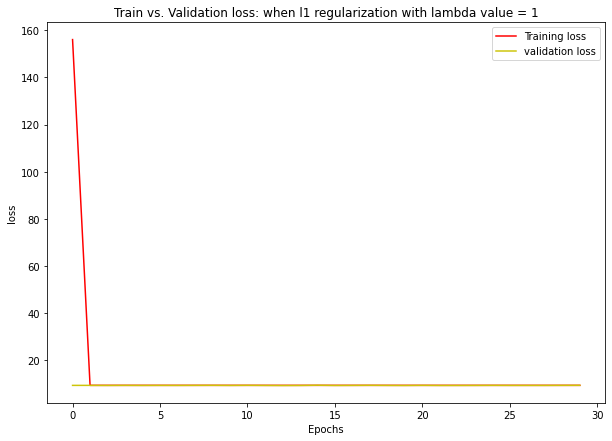

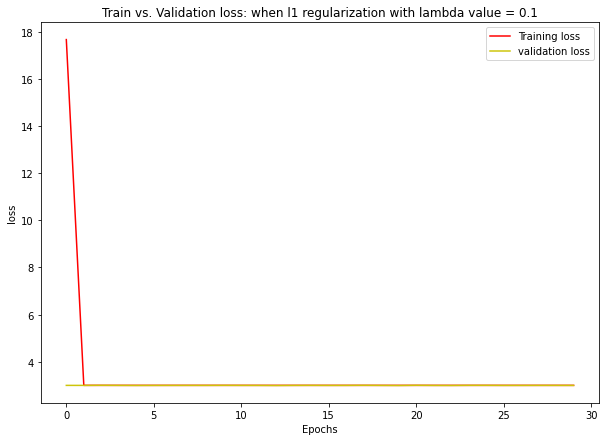

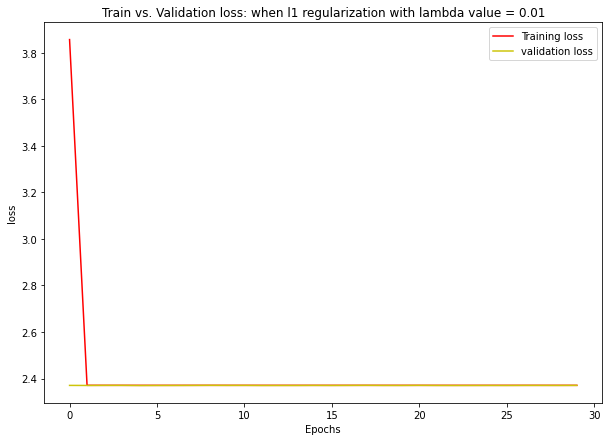

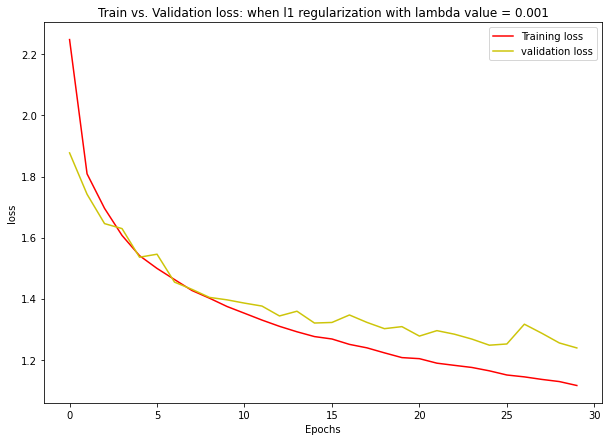

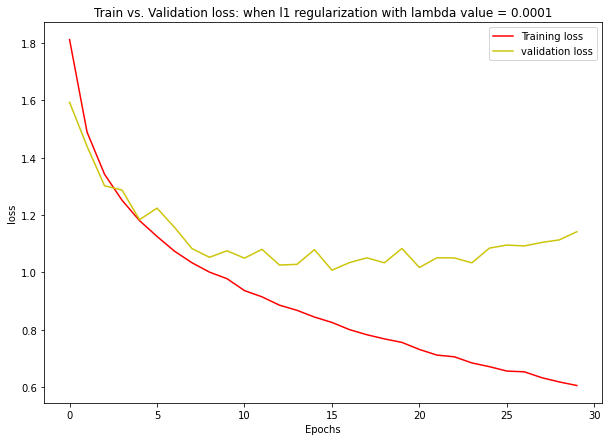

time: 978 ms (started: 2022-05-29 10:30:42 +00:00)


In [ ]:
# a helper function used to print the line charts for the different mini batch sizes
generatePlot(history_D, 'l1 regularization with lambda value')

In [ ]:
# a helper function that returns data frames for for losss, accuracy and run time execution
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'lambda')

time: 2.6 ms (started: 2022-05-29 10:30:43 +00:00)


In [ ]:
val_loss_df

lambda  val_loss
0  1.0000  9.284307
1  0.1000  2.995023
2  0.0100  2.370739
3  0.0010  1.238211
4  0.0001  1.141577

time: 6.37 ms (started: 2022-05-29 10:30:43 +00:00)


In [ ]:
val_accuracy_df

lambda  val_accuracy_L
0  1.0000          0.1000
1  0.1000          0.1000
2  0.0100          0.1000
3  0.0010          0.6210
4  0.0001          0.6976

time: 5.53 ms (started: 2022-05-29 10:30:43 +00:00)


In [ ]:
recordTime_df

lambda  Time in seconds
0  1.0000        51.648167
1  0.1000        51.125635
2  0.0100        51.216191
3  0.0010        51.299482
4  0.0001        51.339760

time: 5.99 ms (started: 2022-05-29 10:30:44 +00:00)


<p>With L1 regularization we see that when lambda = 0.001, the validation loss is higher than the training loss and there is less overfitting when you compare to other values of lambda.</p>

### L2 regularization within the Convolutional layers

In [ ]:
# we create a list of lambdas with the following values [1, 0.1, 0.01, 0.001, 0.0001]
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
lambda_L = [1, 0.1, 0.01, 0.001, 0.0001]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(lambda_L)):
  
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(lambda_L[fact]),input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(lambda_L[fact]), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(lambda_L[fact]), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((lambda_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[lambda_L[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([lambda_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([lambda_L[fact], val_acc])

Epoch 1/30
400/400 [==============================] - 3s 5ms/step - loss: 8.6497 - accuracy: 0.1081 - val_loss: 2.3032 - val_accuracy: 0.1000
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3029 - accuracy: 0.1013 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0965 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0954 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0986 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0961 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 

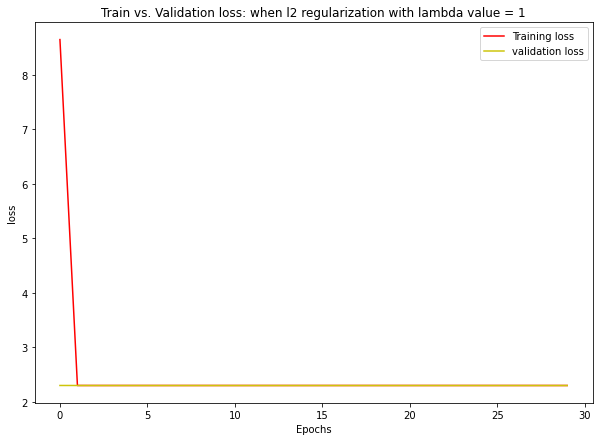

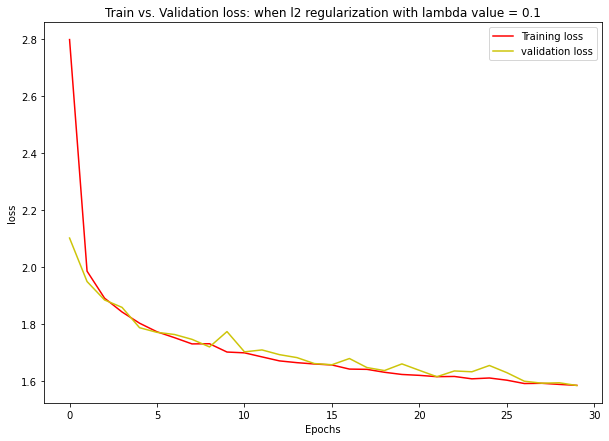

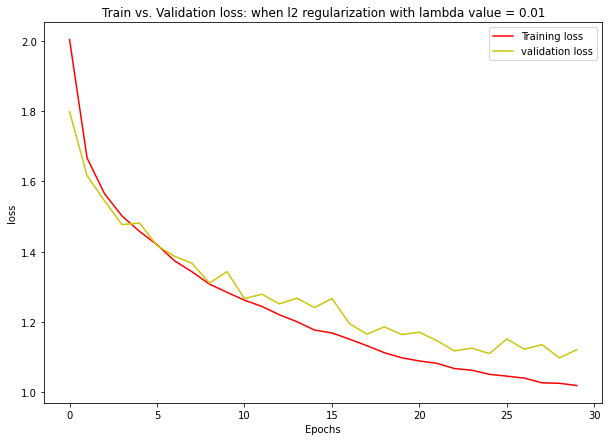

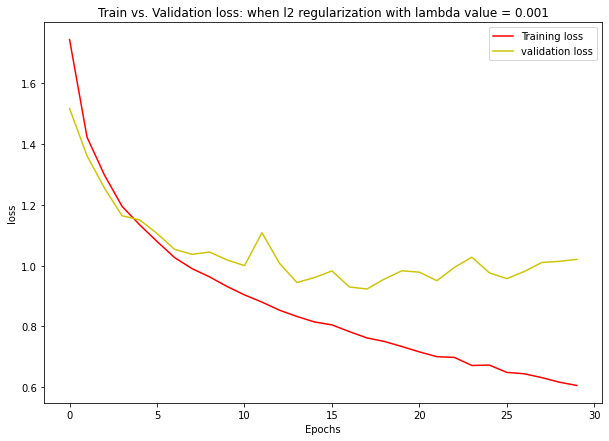

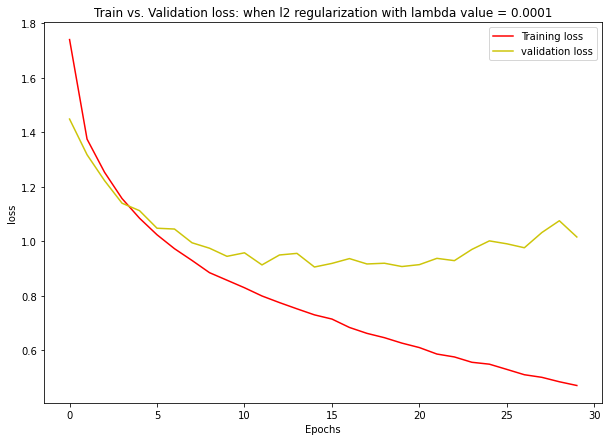

time: 987 ms (started: 2022-05-29 10:35:07 +00:00)


In [ ]:
generatePlot(history_D, 'l2 regularization with lambda value')

In [ ]:
# a helper function that returns data frames for for losss, accuracy and run time execution
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'lambda')

time: 2.9 ms (started: 2022-05-29 10:35:08 +00:00)


In [ ]:
val_loss_df

lambda  val_loss
0  1.0000  2.302595
1  0.1000  1.585631
2  0.0100  1.121485
3  0.0010  1.020473
4  0.0001  1.015774

time: 6.08 ms (started: 2022-05-29 10:35:08 +00:00)


In [ ]:
val_accuracy_df

lambda  val_accuracy_L
0  1.0000          0.1000
1  0.1000          0.4676
2  0.0100          0.6686
3  0.0010          0.7225
4  0.0001          0.7052

time: 6.65 ms (started: 2022-05-29 10:35:08 +00:00)


In [ ]:
recordTime_df

lambda  Time in seconds
0  1.0000        50.996619
1  0.1000        51.715109
2  0.0100        51.538300
3  0.0010        51.281299
4  0.0001        51.225345

time: 5.4 ms (started: 2022-05-29 10:35:08 +00:00)


In [ ]:
# validation loss aganist validation accuracy


time: 430 µs (started: 2022-05-29 10:35:08 +00:00)


<p>With L2 regularization we see that when lambda = 0.001, the validation loss is higher than the training loss and there is less overfitting when you compare to other values of 0.0001. Also, this is the optimal value witha  low validation loss and high validation accuracy.  </p>

---



### L1 Regularization for Dense Layers

In [ ]:
# we create a list of lambdas with the following values [1, 0.1, 0.01, 0.001, 0.0001]
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
lambda_L = [1, 0.1, 0.01, 0.001, 0.0001]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(lambda_L)):
  
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3),  activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3),  activation='relu'))
  model.add(layers.Flatten())
  # applying l1 regularization at the dense layer
  model.add(layers.Dense(64, kernel_regularizer=l1(lambda_L[fact]), activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((lambda_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[lambda_L[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([lambda_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([lambda_L[fact], val_acc])

Epoch 1/30
400/400 [==============================] - 2s 5ms/step - loss: 168.4807 - accuracy: 0.1678 - val_loss: 10.3849 - val_accuracy: 0.2171
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 10.1901 - accuracy: 0.2033 - val_loss: 10.0892 - val_accuracy: 0.1694
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 9.9078 - accuracy: 0.2192 - val_loss: 9.7350 - val_accuracy: 0.2313
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 9.7272 - accuracy: 0.2283 - val_loss: 9.7465 - val_accuracy: 0.2095
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 9.6468 - accuracy: 0.2330 - val_loss: 9.6557 - val_accuracy: 0.2429
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 9.5815 - accuracy: 0.2377 - val_loss: 9.5242 - val_accuracy: 0.2311
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 9.5727 - accuracy: 0.2369 - val_loss: 9.5169 - val_accuracy: 0.2394
E

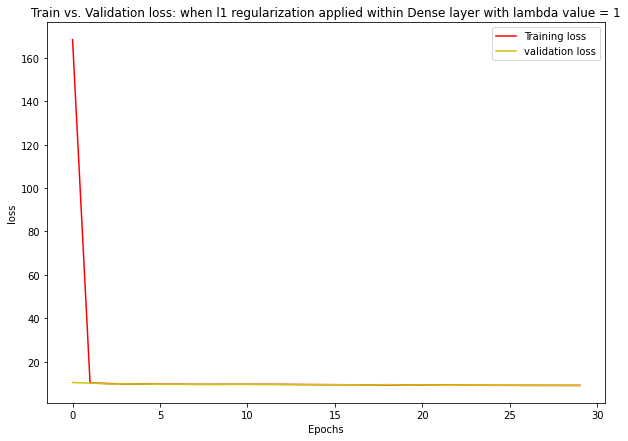

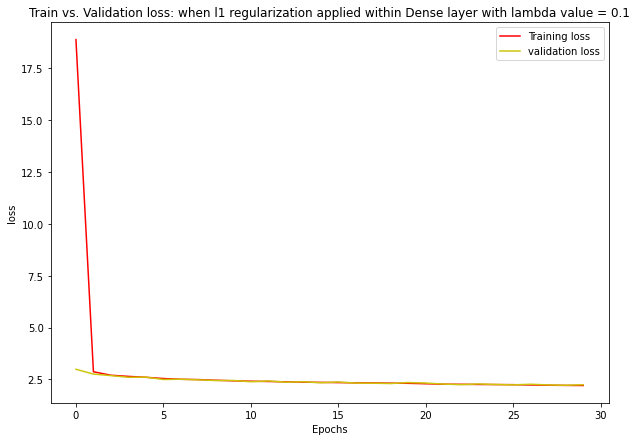

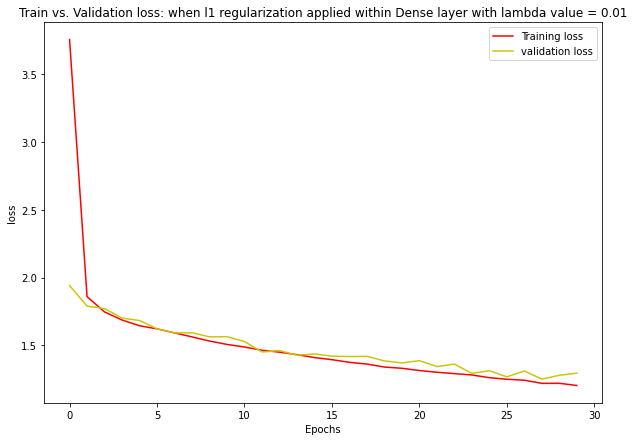

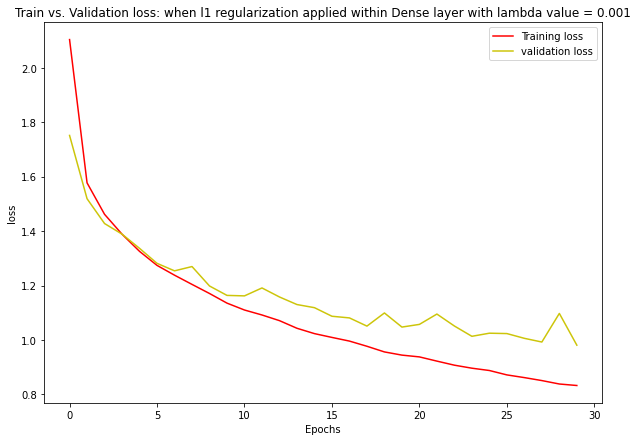

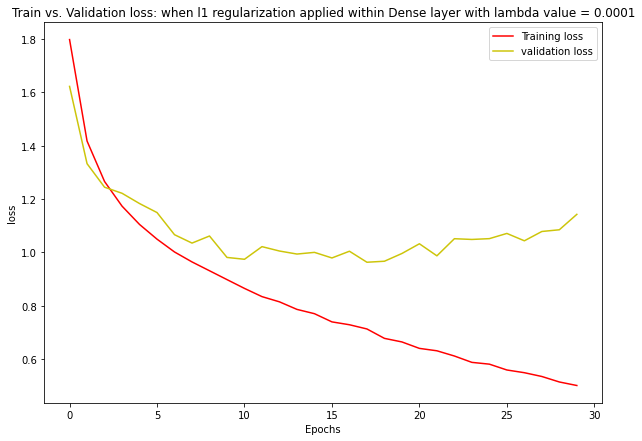

time: 994 ms (started: 2022-05-29 10:39:27 +00:00)


In [ ]:
generatePlot(history_D, 'l1 regularization applied within Dense layer with lambda value')

<p>When lambda = 0.001, we see that the validation loss is slightly higher than the training loss and also there is less overfitting. </p>

In [ ]:
# a helper function that returns data frames for for losss, accuracy and run time execution
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'lambda')

time: 2.22 ms (started: 2022-05-29 10:39:28 +00:00)


In [ ]:
val_loss_df

lambda  val_loss
0  1.0000  9.025748
1  0.1000  2.238340
2  0.0100  1.295976
3  0.0010  0.981017
4  0.0001  1.142625

time: 6.92 ms (started: 2022-05-29 10:39:28 +00:00)


In [ ]:
val_accuracy_df

lambda  val_accuracy_L
0  1.0000          0.3970
1  0.1000          0.5040
2  0.0100          0.6076
3  0.0010          0.7066
4  0.0001          0.7013

time: 6.77 ms (started: 2022-05-29 10:39:28 +00:00)


### L2 Regularization for Dense Layers

In [ ]:
# we create a list of lambdas with the following values [1, 0.1, 0.01, 0.001, 0.0001]
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
lambda_L = [1, 0.1, 0.01, 0.001, 0.0001]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(lambda_L)):
  
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3),  activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3),  activation='relu'))
  model.add(layers.Flatten())
  # applying l1 regularization at the dense layer
  model.add(layers.Dense(64, kernel_regularizer=l2(lambda_L[fact]), activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((lambda_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[lambda_L[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([lambda_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([lambda_L[fact], val_acc])

Epoch 1/30
400/400 [==============================] - 2s 5ms/step - loss: 8.3149 - accuracy: 0.2734 - val_loss: 1.8686 - val_accuracy: 0.3221
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.7832 - accuracy: 0.3819 - val_loss: 1.6841 - val_accuracy: 0.4211
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.6689 - accuracy: 0.4314 - val_loss: 1.6290 - val_accuracy: 0.4528
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.6024 - accuracy: 0.4558 - val_loss: 1.5477 - val_accuracy: 0.4843
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.5531 - accuracy: 0.4800 - val_loss: 1.5525 - val_accuracy: 0.4794
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.5160 - accuracy: 0.4952 - val_loss: 1.5190 - val_accuracy: 0.5056
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4834 - accuracy: 0.5073 - val_loss: 1.5059 - val_accuracy: 0.4995
Epoch 

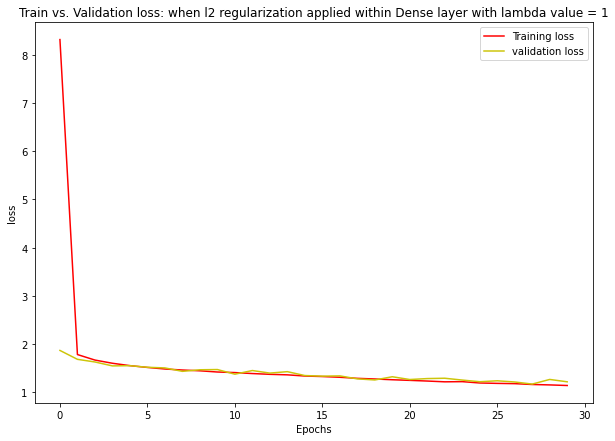

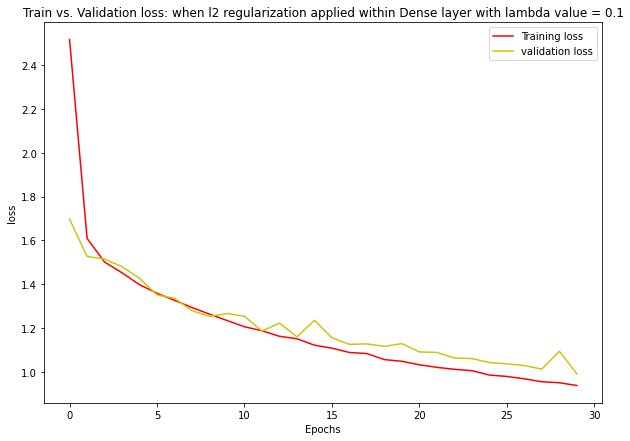

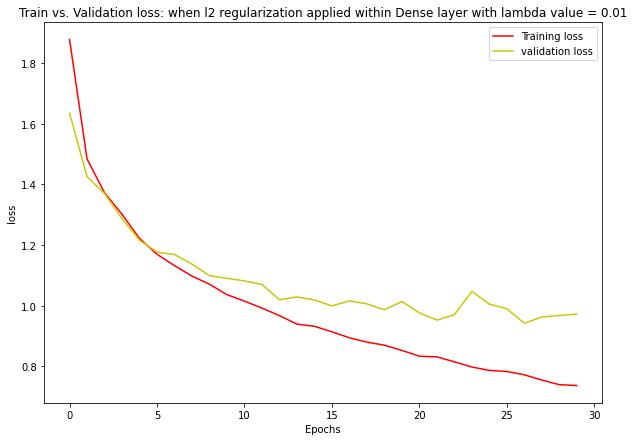

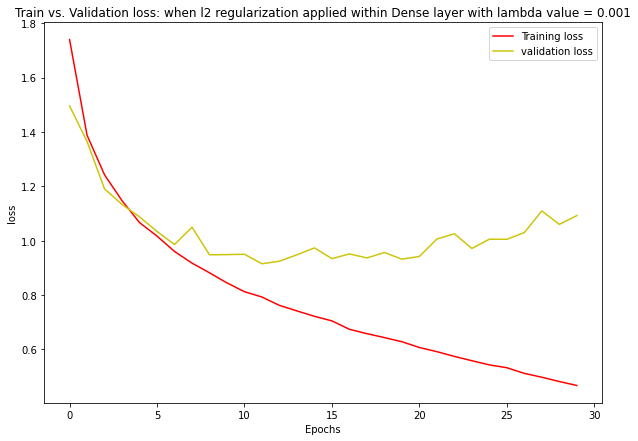

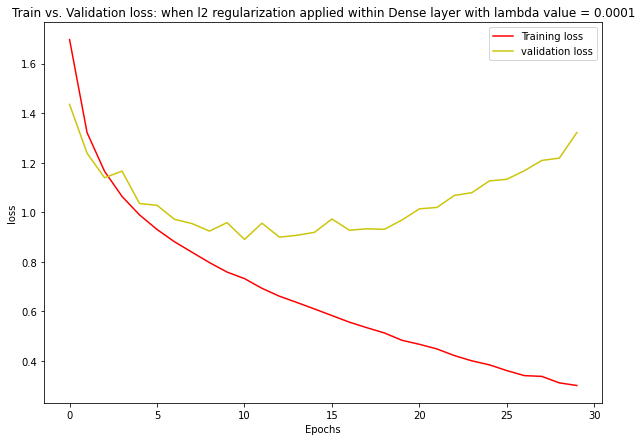

time: 1.04 s (started: 2022-05-29 10:43:50 +00:00)


In [ ]:
generatePlot(history_D, 'l2 regularization applied within Dense layer with lambda value')

In [ ]:
# a helper function that returns data frames for for losss, accuracy and run time execution
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'lambda')

time: 2.66 ms (started: 2022-05-29 10:43:51 +00:00)


In [ ]:
val_loss_df

lambda  val_loss
0  1.0000  1.217741
1  0.1000  0.989736
2  0.0100  0.971831
3  0.0010  1.092480
4  0.0001  1.321742

time: 6.09 ms (started: 2022-05-29 10:43:51 +00:00)


In [ ]:
val_accuracy_df

lambda  val_accuracy_L
0  1.0000          0.6292
1  0.1000          0.6965
2  0.0100          0.7001
3  0.0010          0.6958
4  0.0001          0.6902

time: 6.82 ms (started: 2022-05-29 10:43:51 +00:00)


<p>We notice that with lambda = 0.01, there is less overfitting and also the validation loss is at 0.91 which is a low value when compared to other values of lambda.</p>

### L2 regularization for both Convolutional and dense layers

In [ ]:
# we create a list of lambdas with the following values [1, 0.1, 0.01, 0.001, 0.0001]
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
lambda_L = [1, 0.1, 0.01, 0.001, 0.0001]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(lambda_L)):
  
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(lambda_L[fact]),input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(lambda_L[fact]), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(lambda_L[fact]), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, kernel_regularizer=l2(lambda_L[fact]), activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((lambda_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[lambda_L[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([lambda_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([lambda_L[fact], val_acc])

Epoch 1/30
400/400 [==============================] - 2s 5ms/step - loss: 14.8847 - accuracy: 0.1001 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3028 - accuracy: 0.0998 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0987 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 2.3027 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch

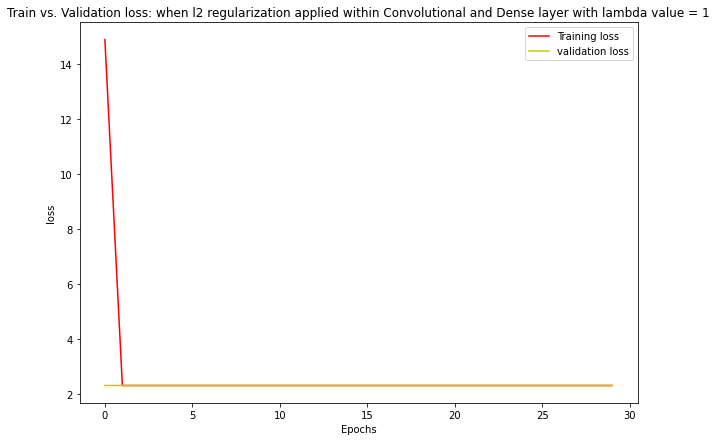

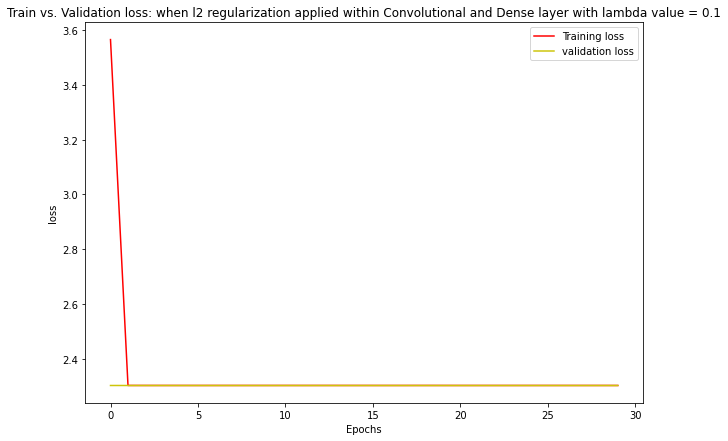

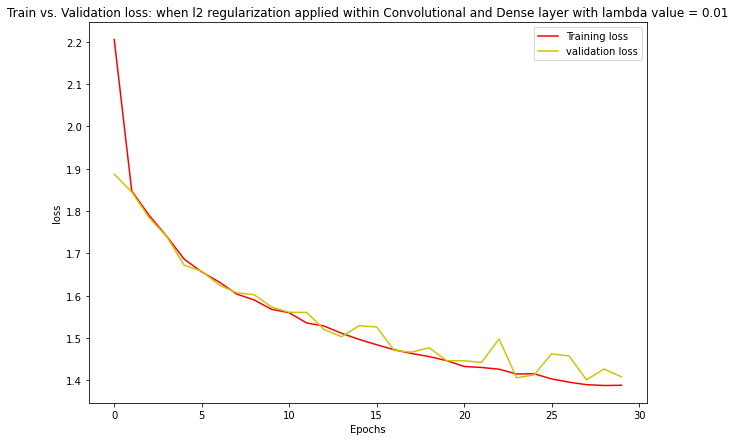

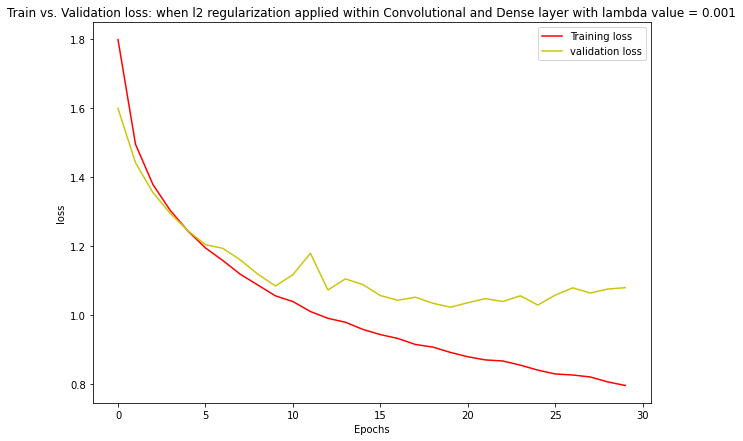

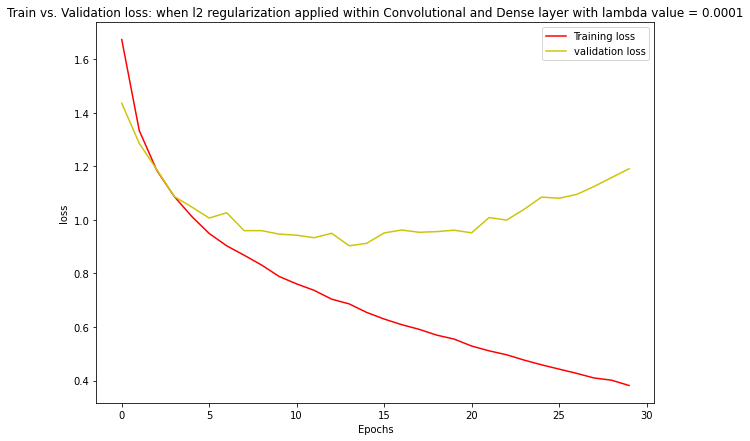

time: 1.05 s (started: 2022-05-29 10:48:16 +00:00)


In [ ]:
generatePlot(history_D, 'l2 regularization applied within Convolutional and Dense layer with lambda value')

In [ ]:
# a helper function that returns data frames for for losss, accuracy and run time execution
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'lambda')

time: 3.2 ms (started: 2022-05-29 10:48:17 +00:00)


In [ ]:
val_loss_df

lambda  val_loss
0  1.0000  2.302593
1  0.1000  2.302595
2  0.0100  1.407953
3  0.0010  1.078872
4  0.0001  1.191152

time: 6.91 ms (started: 2022-05-29 10:48:17 +00:00)


In [ ]:
val_accuracy_df

lambda  val_accuracy_L
0  1.0000          0.1000
1  0.1000          0.1000
2  0.0100          0.6007
3  0.0010          0.7021
4  0.0001          0.7094

time: 6 ms (started: 2022-05-29 10:48:17 +00:00)


<p>With lambda of 0.001, there is less overfitting with a low validation loss value of 1.02.</p><p>There is no difference in the validation loss and accuracy when we apply regularization at either the convolutional layer or dense layer or both, so I decided to apply it at the Convolutional layer.</p>

<p>We have explored different values of l1 and l2 regularization within the Convolutional and dense layers and the value of lambda of 0.01 with l2 regularization applied within the Convolutional layer is the best lambda value because it experiences less overfitting when the network start training to when it finishes.</p>

### let's train  the model with a mini-batch-size of 100, learning rate of 0.001 and l2 regularization with lambda of 0.001:

In [ ]:
model_history = buildbestModel(100, 0.001, 0.001)

lambda_v is not null
learning rate is given
Epoch 1/30
400/400 [==============================] - 2s 5ms/step - loss: 1.7445 - accuracy: 0.3785 - val_loss: 1.5219 - val_accuracy: 0.4604
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4257 - accuracy: 0.5118 - val_loss: 1.4015 - val_accuracy: 0.5313
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2947 - accuracy: 0.5648 - val_loss: 1.2660 - val_accuracy: 0.5762
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2123 - accuracy: 0.6004 - val_loss: 1.2177 - val_accuracy: 0.5976
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1398 - accuracy: 0.6289 - val_loss: 1.1421 - val_accuracy: 0.6266
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0963 - accuracy: 0.6449 - val_loss: 1.1113 - val_accuracy: 0.6471
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0479 - accuracy: 0.6658 - va

### Save the model to the drive and reload it

In [ ]:
# helper function that saves the current model to the file system.
saveModel('CNN_image_classification.model')

INFO:tensorflow:Assets written to: CNN_image_classification.model/assets
time: 1.46 s (started: 2022-05-29 10:49:09 +00:00)


In [ ]:
# helper function that loads the saved model
savedModel = load_saved_model('CNN_image_classification.model')

time: 455 ms (started: 2022-05-29 10:49:10 +00:00)


### Make the predictions and write the results to a csv file

In [ ]:
# let's make the required predictions
predictions = savedModel.predict([test_images])

time: 755 ms (started: 2022-05-29 10:49:10 +00:00)


In [ ]:
# let's convert a numpy array into a list
predictions_L = predictions.tolist()

time: 7.15 ms (started: 2022-05-29 10:49:11 +00:00)


In [ ]:
# helper function that writes predictions Results to a csv file
writeResultsToCsv(predictions_L)

time: 148 ms (started: 2022-05-29 10:49:11 +00:00)


## Dropout

<p>Dropout randomly selects nodes and removes them from the network when model is  training. So, we explore the different values of 0.2, 0.3, 0.4 and 0.5. </p>

In [ ]:
# we create a list of lambdas with the following values [1, 0.1, 0.01, 0.001, 0.0001]
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
dropout_L = [0.2, 0.3, 0.4, 0.5]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(dropout_L)):
  
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
  # first dropout
  model.add(layers.Dropout(dropout_L[fact]))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  # last dropout
  model.add(layers.Dropout(dropout_L[fact]))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((dropout_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[dropout_L[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([dropout_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([dropout_L[fact], val_acc])

Epoch 1/30
400/400 [==============================] - 3s 5ms/step - loss: 1.8464 - accuracy: 0.3386 - val_loss: 1.5336 - val_accuracy: 0.4555
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.5210 - accuracy: 0.4656 - val_loss: 1.4095 - val_accuracy: 0.5240
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4196 - accuracy: 0.5093 - val_loss: 1.3406 - val_accuracy: 0.5359
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.3463 - accuracy: 0.5382 - val_loss: 1.3036 - val_accuracy: 0.5499
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2868 - accuracy: 0.5653 - val_loss: 1.2247 - val_accuracy: 0.5886
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2263 - accuracy: 0.5889 - val_loss: 1.1536 - val_accuracy: 0.6189
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1815 - accuracy: 0.6080 - val_loss: 1.1183 - val_accuracy: 0.6254
Epoch 

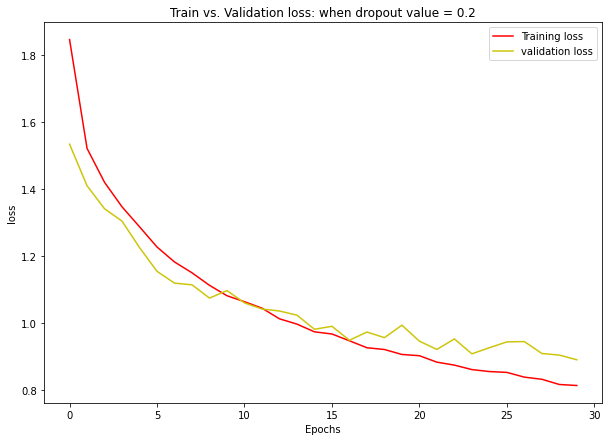

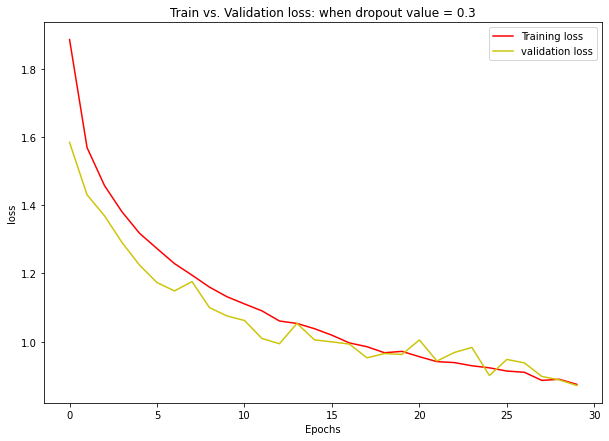

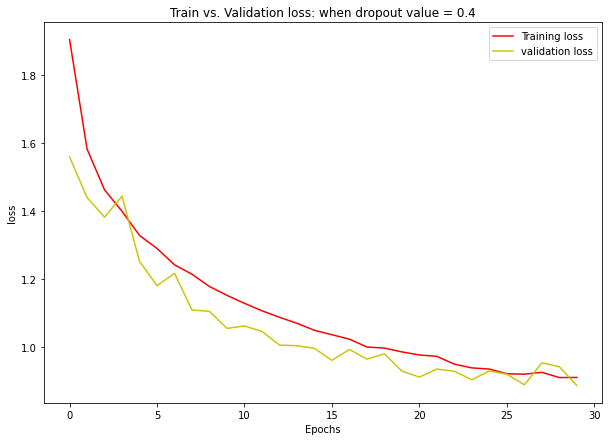

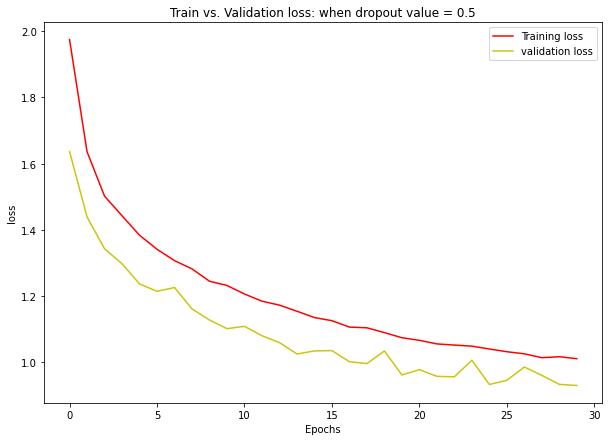

time: 770 ms (started: 2022-05-29 10:52:48 +00:00)


In [ ]:
generatePlot(history_D, 'dropout value')

In [ ]:
# a helper function that returns data frames for for losss, accuracy and run time execution
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'dropout')

time: 2.59 ms (started: 2022-05-29 10:52:49 +00:00)


In [ ]:
val_loss_df

dropout  val_loss
0      0.2  0.889100
1      0.3  0.871318
2      0.4  0.886203
3      0.5  0.930537

time: 6.46 ms (started: 2022-05-29 10:52:49 +00:00)


In [ ]:
val_accuracy_df

dropout  val_accuracy_L
0      0.2          0.7280
1      0.3          0.7303
2      0.4          0.7286
3      0.5          0.7148

time: 5.85 ms (started: 2022-05-29 10:52:49 +00:00)


In [ ]:
recordTime_df

dropout  Time in seconds
0      0.2        52.678099
1      0.3        53.017444
2      0.4        52.871197
3      0.5        53.049805

time: 5.28 ms (started: 2022-05-29 10:52:49 +00:00)


<p>With the dropout value of 0.2, the model experiences less overfitting as the training epochs increases, the gap between the training loss and validation loss decreases between the 10th and 25th epochs.</p>

### let's train  the model with a mini-batch-size of 100, learning rate of 0.001, l2 regularization with lambda of 0.001 and dropout rate of 0.2

In [ ]:
model_history = buildbestModel(100, 0.001, 0.001, 0.2)

lambda and dropout are not null
learning rate is given
Epoch 1/30
400/400 [==============================] - 3s 5ms/step - loss: 1.8509 - accuracy: 0.3301 - val_loss: 1.5556 - val_accuracy: 0.4609
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.5153 - accuracy: 0.4734 - val_loss: 1.3966 - val_accuracy: 0.5162
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.3881 - accuracy: 0.5274 - val_loss: 1.3020 - val_accuracy: 0.5559
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2998 - accuracy: 0.5646 - val_loss: 1.2381 - val_accuracy: 0.5811
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2417 - accuracy: 0.5864 - val_loss: 1.1768 - val_accuracy: 0.6118
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1794 - accuracy: 0.6128 - val_loss: 1.1299 - val_accuracy: 0.6327
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1403 - accuracy: 

### Save the model to the drive and reload it

In [ ]:
# helper function that saves the current model to the file system.
saveModel('CNN_image_classification.model')

INFO:tensorflow:Assets written to: CNN_image_classification.model/assets
time: 1.52 s (started: 2022-05-29 10:53:42 +00:00)


In [ ]:
# helper function that loads the saved model
savedModel = load_saved_model('CNN_image_classification.model')

time: 496 ms (started: 2022-05-29 10:53:44 +00:00)


### Make the predictions and write the results to a csv file

In [ ]:
# let's make the required predictions
predictions = savedModel.predict([test_images])

time: 745 ms (started: 2022-05-29 10:53:44 +00:00)


In [ ]:
# let's convert a numpy array into a list
predictions_L = predictions.tolist()

time: 9.37 ms (started: 2022-05-29 10:53:45 +00:00)


In [ ]:
# helper function that writes predictions Results to a csv file
writeResultsToCsv(predictions_L)

time: 144 ms (started: 2022-05-29 10:53:45 +00:00)


## Optimizers

### building the network with the Nadam optimizer

In [ ]:
seed=7
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.001), activation='relu'))


# first dropout
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

# last dropout
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))  # As noted above

opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])

# train the model
history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))

Epoch 1/30
400/400 [==============================] - 4s 6ms/step - loss: 1.8640 - accuracy: 0.3363 - val_loss: 1.5005 - val_accuracy: 0.4755
Epoch 2/30
400/400 [==============================] - 2s 5ms/step - loss: 1.5013 - accuracy: 0.4800 - val_loss: 1.3595 - val_accuracy: 0.5401
Epoch 3/30
400/400 [==============================] - 2s 5ms/step - loss: 1.3576 - accuracy: 0.5425 - val_loss: 1.3086 - val_accuracy: 0.5505
Epoch 4/30
400/400 [==============================] - 2s 6ms/step - loss: 1.2674 - accuracy: 0.5795 - val_loss: 1.1753 - val_accuracy: 0.6118
Epoch 5/30
400/400 [==============================] - 2s 6ms/step - loss: 1.1947 - accuracy: 0.6068 - val_loss: 1.1384 - val_accuracy: 0.6243
Epoch 6/30
400/400 [==============================] - 2s 6ms/step - loss: 1.1393 - accuracy: 0.6308 - val_loss: 1.0854 - val_accuracy: 0.6483
Epoch 7/30
400/400 [==============================] - 2s 5ms/step - loss: 1.0924 - accuracy: 0.6493 - val_loss: 1.0434 - val_accuracy: 0.6621
Epoch 

In [ ]:
# create a data frame containing the loss and accuracy of the model
data = {'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
        'val_loss': history.history['val_loss'], 
        'val_accuracy': history.history['val_accuracy'],
        'loss':history.history['loss'],
        'training accuracy':history.history['accuracy']}


val_accuracy_loss_df = pd.DataFrame(data)

time: 4.04 ms (started: 2022-05-29 10:54:54 +00:00)


In [ ]:
# sort the data frame by validation accuracy
val_accuracy_loss_df.sort_values(by=['val_accuracy'], inplace=True, ascending=False) # the first five records
print(val_accuracy_loss_df)

    Epoch  val_loss  val_accuracy      loss  training accuracy
28     29  0.854929        0.7479  0.725195           0.789225
27     28  0.864599        0.7462  0.729369           0.784750
24     25  0.865675        0.7400  0.755240           0.777450
23     24  0.869699        0.7396  0.772499           0.769850
22     23  0.871522        0.7395  0.776370           0.767375
20     21  0.866560        0.7395  0.795639           0.760475
26     27  0.877398        0.7386  0.741153           0.780025
21     22  0.876755        0.7371  0.784136           0.764325
25     26  0.876225        0.7366  0.745877           0.779950
18     19  0.877237        0.7328  0.816251           0.752625
19     20  0.886340        0.7324  0.805627           0.758050
17     18  0.889140        0.7265  0.836046           0.744700
29     30  0.943874        0.7250  0.717056           0.790950
16     17  0.908919        0.7200  0.844792           0.740325
12     13  0.919601        0.7167  0.917064           0

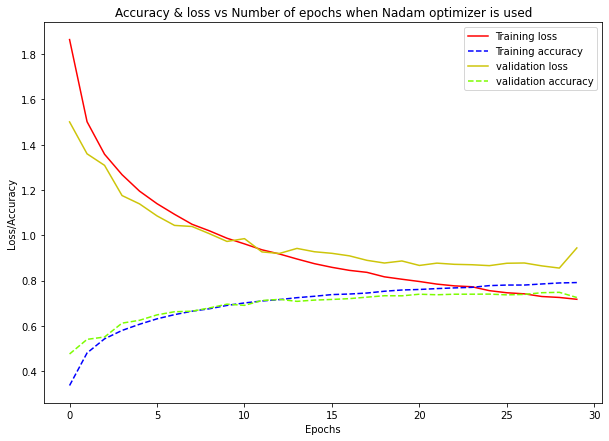

time: 232 ms (started: 2022-05-29 10:54:54 +00:00)


In [ ]:
# helper function that takes dictionary of keys and plot the different line charts
deriveLossAccuracyLineCharts(history.history, 'Accuracy & loss vs Number of epochs when Nadam optimizer is used')

<p>We notice that at training epoch 27 is where there is validation loss is at its lowest. Also we notice at epoch 27 the gap between training and validation accuracy is small, which means that there is less overfitting. </p>

### building the network with the Adam optimizer

In [ ]:
seed = 7
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.001), activation='relu'))


# first dropout
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

# last dropout
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))  # As noted above

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])

# train the model
history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))

Epoch 1/30
400/400 [==============================] - 3s 5ms/step - loss: 1.8313 - accuracy: 0.3440 - val_loss: 1.6043 - val_accuracy: 0.4403
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.5053 - accuracy: 0.4747 - val_loss: 1.3796 - val_accuracy: 0.5266
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.3619 - accuracy: 0.5355 - val_loss: 1.2857 - val_accuracy: 0.5621
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2688 - accuracy: 0.5763 - val_loss: 1.2103 - val_accuracy: 0.5923
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2013 - accuracy: 0.6048 - val_loss: 1.1659 - val_accuracy: 0.6140
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1493 - accuracy: 0.6242 - val_loss: 1.0913 - val_accuracy: 0.6459
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1003 - accuracy: 0.6454 - val_loss: 1.0380 - val_accuracy: 0.6678
Epoch 

In [ ]:
# create a data frame containing the loss and accuracy of the model
data = {'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
        'val_loss': history.history['val_loss'], 
        'val_accuracy': history.history['val_accuracy'],
        'loss':history.history['loss'],
        'training accuracy':history.history['accuracy']}
# create a data frame

val_accuracy_loss_df = pd.DataFrame(data)

time: 4.03 ms (started: 2022-05-29 10:55:48 +00:00)


In [ ]:
# sort the data frame by validation accuracy
val_accuracy_loss_df.sort_values(by=['val_accuracy'], inplace=True, ascending=False) # the first five records
print(val_accuracy_loss_df)

    Epoch  val_loss  val_accuracy      loss  training accuracy
27     28  0.862960        0.7451  0.772209           0.770500
26     27  0.863799        0.7450  0.779164           0.767400
28     29  0.878155        0.7384  0.763486           0.774375
22     23  0.867290        0.7371  0.813381           0.754350
25     26  0.889484        0.7358  0.787363           0.764800
29     30  0.907936        0.7321  0.759865           0.777000
23     24  0.893584        0.7319  0.817459           0.753775
19     20  0.888462        0.7313  0.852820           0.741750
24     25  0.899410        0.7300  0.806813           0.759700
20     21  0.904302        0.7195  0.830085           0.747600
17     18  0.909900        0.7189  0.873554           0.733475
21     22  0.913795        0.7187  0.826710           0.749250
18     19  0.931055        0.7176  0.862393           0.738250
14     15  0.929228        0.7081  0.914773           0.717025
15     16  0.936182        0.7073  0.902204           0

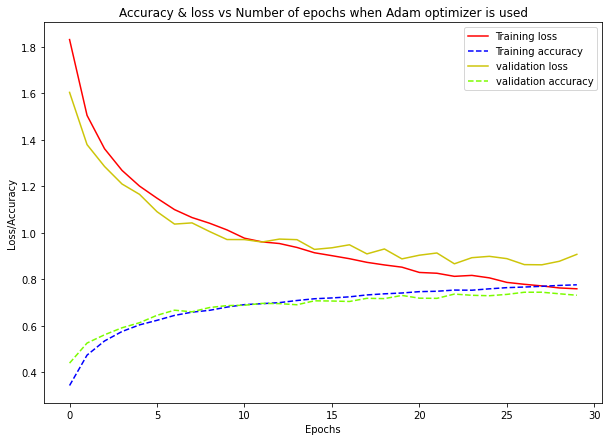

time: 216 ms (started: 2022-05-29 10:55:48 +00:00)


In [ ]:
# helper function that takes dictionary of keys and plot the different line charts
deriveLossAccuracyLineCharts(history.history)

<p>We notice that at training epoch 27 is where validation loss is at its lowest. Also we notice at epoch 27 the gap between training and validation accuracy is small, which means that there is less overfitting. </p>
<p>Comparing the Adam optimizer with the Nadam, Adam optimizer performs better since there is less overfitting as just witnessed form the above charts and going foward we should be using this optimizer.</p>

## Number of filters

This is form of a film or layer that allows only the desired qualities of the input to get through it. So, we shall use a pair of filters to explore the optimal value. 

### Create a convolutional network, compile and train the model to explore different values of the following list: [(16,32), (32, 64), (64, 96), (96, 128)]

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
num_filters_L = [(16,32), (32, 64), (64, 96), (96, 128)]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(num_filters_L)):
  print('Number of filter pairs being used: %s and %s' %(str(num_filters_L[fact][0]), str(num_filters_L[fact][1])))
  model = models.Sequential()
  # get the first indice of the tuple - num_filters_L[fact][0]
  model.add(layers.Conv2D(num_filters_L[fact][0], (3, 3), activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(num_filters_L[fact][1], (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(num_filters_L[fact][1], (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
  # first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  # last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((num_filters_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[num_filters_L[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([num_filters_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([num_filters_L[fact], val_acc])

Number of filter pairs being used: 16 and 32
Epoch 1/30
400/400 [==============================] - 2s 5ms/step - loss: 1.8645 - accuracy: 0.3223 - val_loss: 1.6165 - val_accuracy: 0.4331
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.5524 - accuracy: 0.4467 - val_loss: 1.4217 - val_accuracy: 0.5026
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4492 - accuracy: 0.4913 - val_loss: 1.4680 - val_accuracy: 0.4931
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.3796 - accuracy: 0.5211 - val_loss: 1.2946 - val_accuracy: 0.5545
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.3347 - accuracy: 0.5409 - val_loss: 1.2509 - val_accuracy: 0.5713
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2839 - accuracy: 0.5616 - val_loss: 1.2022 - val_accuracy: 0.5970
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2462 - accuracy: 0.5774 - v

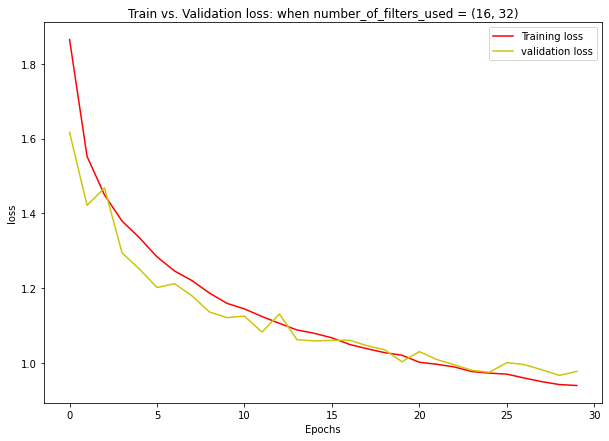

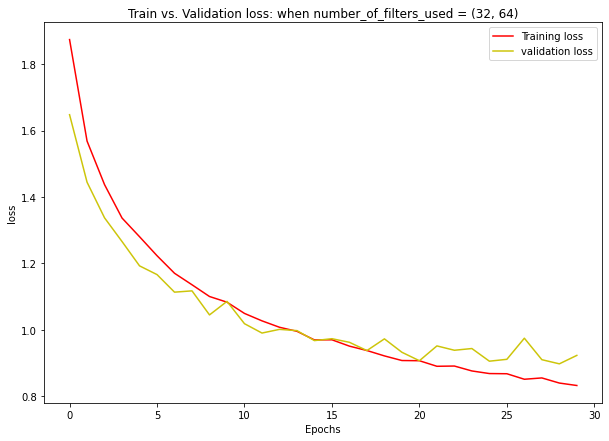

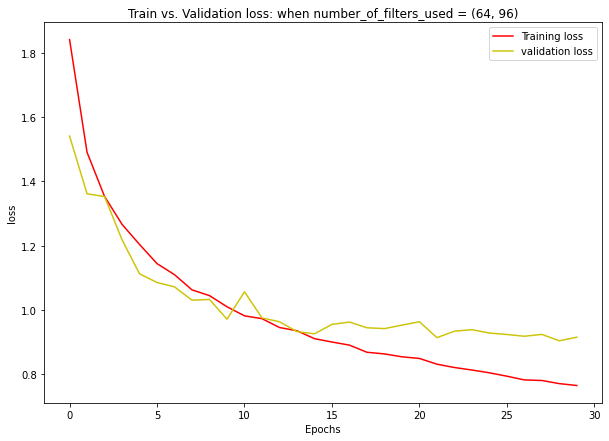

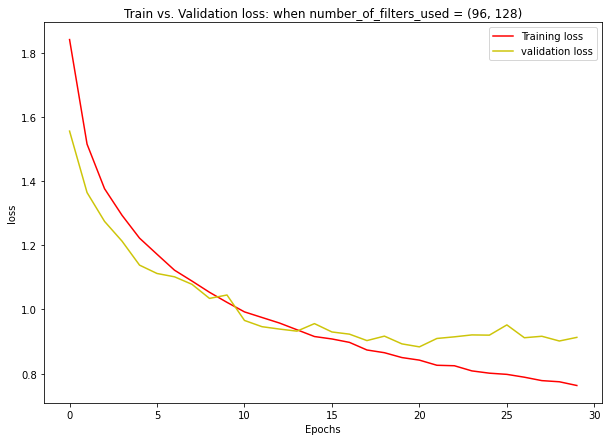

time: 769 ms (started: 2022-05-29 10:59:30 +00:00)


In [ ]:
# a helper function used to print the line charts for the different  number of filters used
generatePlot(history_D, 'number_of_filters_used')

In [ ]:
# a helper function that returns data frames for for losss, accuracy and run time execution
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'filter_pairs_used')

time: 2.95 ms (started: 2022-05-29 10:59:31 +00:00)


In [ ]:
val_loss_df

filter_pairs_used  val_loss
0          (16, 32)  0.977868
1          (32, 64)  0.923307
2          (64, 96)  0.915538
3         (96, 128)  0.912973

time: 7.72 ms (started: 2022-05-29 10:59:31 +00:00)


In [ ]:
val_accuracy_df

filter_pairs_used  val_accuracy_L
0          (16, 32)          0.6770
1          (32, 64)          0.7203
2          (64, 96)          0.7242
3         (96, 128)          0.7431

time: 6.55 ms (started: 2022-05-29 10:59:31 +00:00)


Here, we notice that 96 is the best optimal number of filters to be used in the first Convolutional layer. Also, 128 is the other number of filters to be used in the second and third Convolutional layers.

### Create a convolutional network, compile and train the model to explore different values of the following list: [(8, 16), (16, 32), (24, 48), (32, 64), (40, 80), (48, 96)]

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
num_filters_L = [(8, 16), (16, 32), (24, 48), (32, 64), (40, 80), (48, 96)]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(num_filters_L)):
  print('Number of filter pairs being used: %s and %s' %(str(num_filters_L[fact][0]), str(num_filters_L[fact][1])))
  model = models.Sequential()
  # get the first indice of the tuple - num_filters_L[fact][0]
  model.add(layers.Conv2D(num_filters_L[fact][0], (3, 3), activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(num_filters_L[fact][1], (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(num_filters_L[fact][1], (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
  # first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  # last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((num_filters_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[num_filters_L[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([num_filters_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([num_filters_L[fact], val_acc])

Number of filter pairs being used: 8 and 16
Epoch 1/30
400/400 [==============================] - 2s 5ms/step - loss: 1.9454 - accuracy: 0.2835 - val_loss: 1.6536 - val_accuracy: 0.4193
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.6469 - accuracy: 0.4074 - val_loss: 1.5196 - val_accuracy: 0.4613
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.5554 - accuracy: 0.4439 - val_loss: 1.4652 - val_accuracy: 0.4914
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.5070 - accuracy: 0.4660 - val_loss: 1.4389 - val_accuracy: 0.4973
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4712 - accuracy: 0.4791 - val_loss: 1.3789 - val_accuracy: 0.5198
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4406 - accuracy: 0.4912 - val_loss: 1.3601 - val_accuracy: 0.5355
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4036 - accuracy: 0.5049 - va

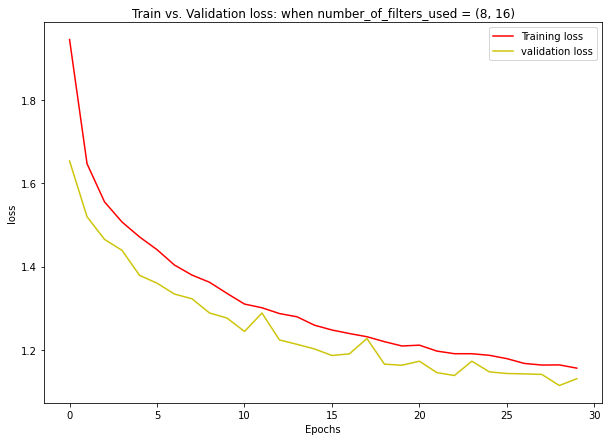

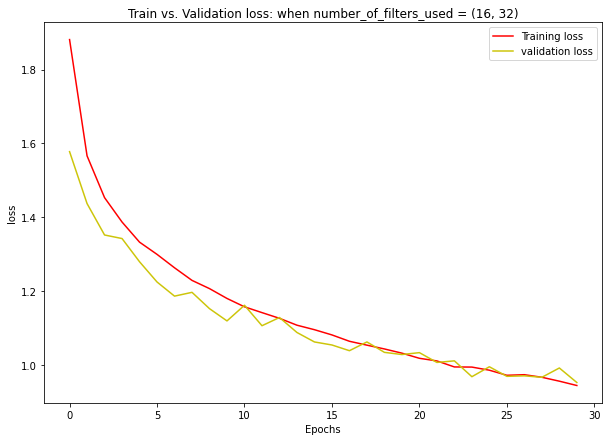

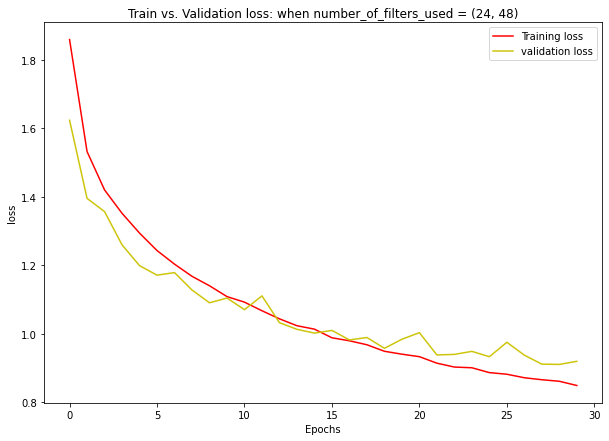

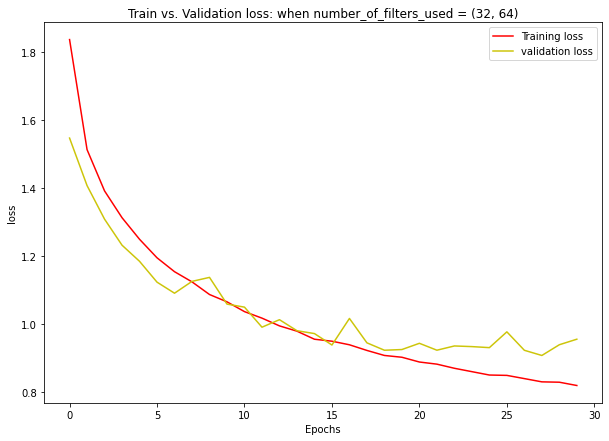

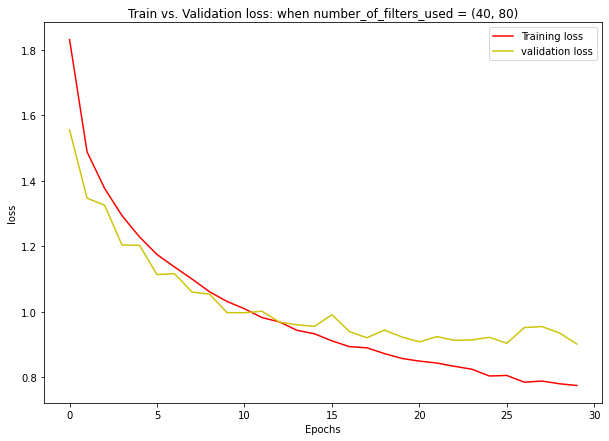

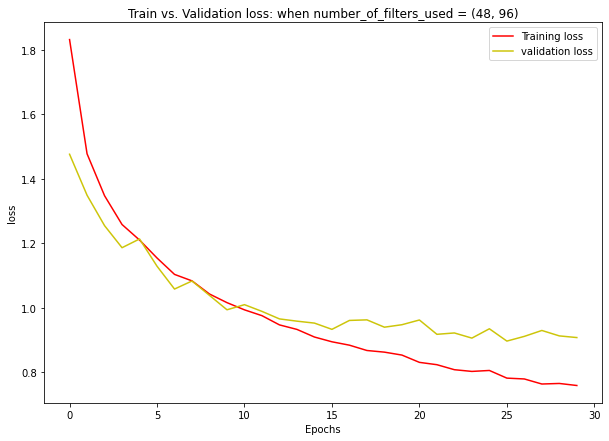

time: 1.15 s (started: 2022-05-29 23:45:18 +00:00)


In [ ]:
# a helper function used to print the line charts for the different  number of filters used
generatePlot(history_D, 'number_of_filters_used')

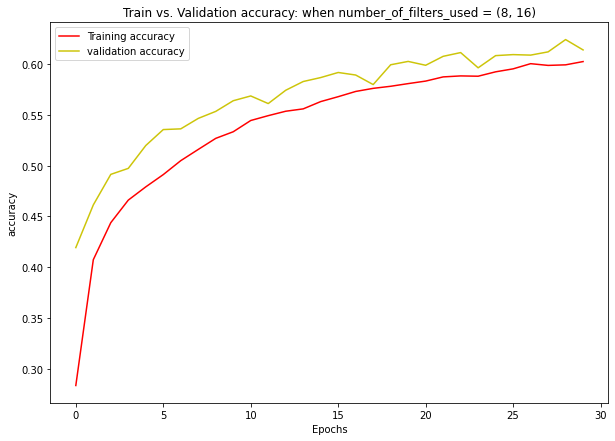

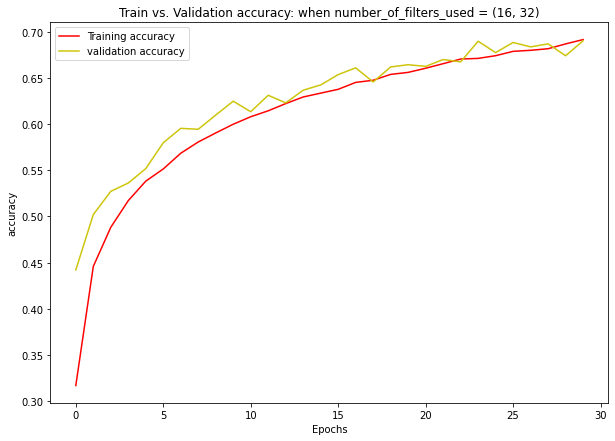

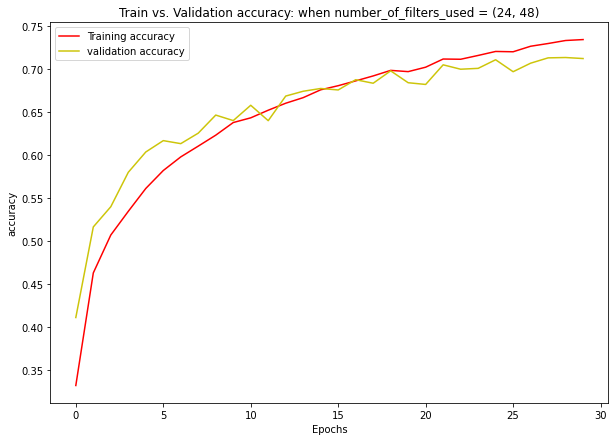

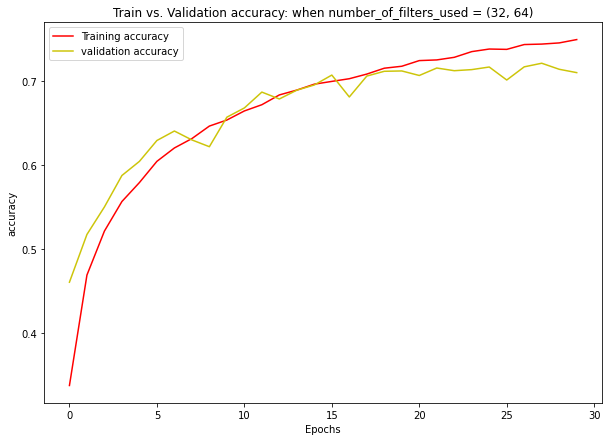

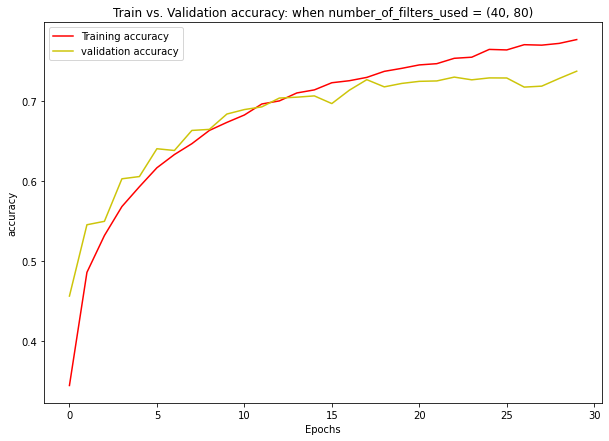

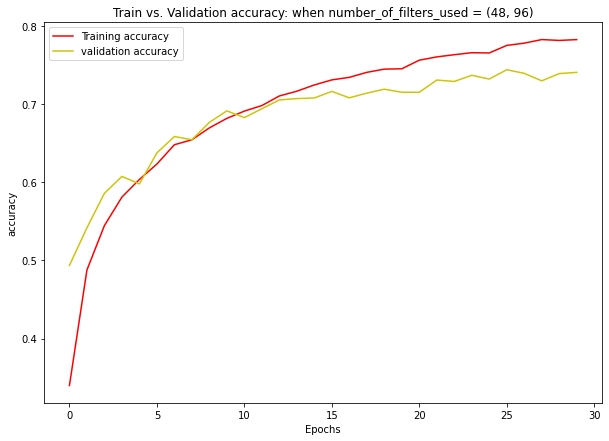

time: 1.22 s (started: 2022-05-29 23:45:36 +00:00)


In [ ]:
generate_accuracy_Plot(history_D, titleStr='number_of_filters_used')

In [ ]:
# a helper function that returns data frames for for losss, accuracy and run time execution
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'filter_pairs_used')

time: 2.9 ms (started: 2022-05-29 11:04:45 +00:00)


In [ ]:
val_loss_df

filter_pairs_used  val_loss
0           (8, 16)  1.107006
1          (16, 32)  0.959683
2          (24, 48)  0.918925
3          (32, 64)  0.894108
4          (40, 80)  0.888747
5          (48, 96)  0.941460

time: 7.5 ms (started: 2022-05-29 11:04:45 +00:00)


In [ ]:
val_accuracy_df

filter_pairs_used  val_accuracy_L
0           (8, 16)          0.6194
1          (16, 32)          0.6871
2          (24, 48)          0.7037
3          (32, 64)          0.7346
4          (40, 80)          0.7337
5          (48, 96)          0.7313

time: 6.91 ms (started: 2022-05-29 11:04:45 +00:00)


<p>We observe that (40, 80) and (32, 64 )seem to be the optimal number of filters to be applied at the Convolutional layers, but we decide to with the (32, 64). 
32 is applied at the first Convolutional layer. 64 is applied at both the second and third Convolutional layers. This pair has the highest accuracy of 0.74 and the lowest validation loss of 0.87.</p>

So comparing the two lists of the number of filters, we justify that (32, 64) is the optimal number of filters to be used by the Convolutional layers. This is because it has less overfitting with a high accuracy and low validation loss value. 

## Number of units to be used in the Dense layer

### Create a convolutional network, compile and train the model to explore different values of the following list: [16, 32, 64, 128, 256, 512, 1024, 2048] to determine the optimal unit.

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
dense_units = [16, 32, 64, 128, 256, 512, 1024, 2048]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(dense_units)):
  print('%s Units being used.' %(str(dense_units[fact])))
  model = models.Sequential()
  # get the first indice of the tuple - num_filters_L[fact][0]
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.001), activation='relu'))
  # first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(dense_units[fact], activation='relu'))

  # last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((dense_units[fact], endTime - startTime))

  # insert the history of the current execution into a dictionary.
  history_D[dense_units[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([dense_units[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([dense_units[fact], val_acc])

16 Units being used.
Epoch 1/30
400/400 [==============================] - 3s 5ms/step - loss: 1.9310 - accuracy: 0.2888 - val_loss: 1.7184 - val_accuracy: 0.4101
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.6579 - accuracy: 0.4044 - val_loss: 1.4746 - val_accuracy: 0.4889
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.5349 - accuracy: 0.4590 - val_loss: 1.4095 - val_accuracy: 0.5184
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4625 - accuracy: 0.4894 - val_loss: 1.3263 - val_accuracy: 0.5515
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4042 - accuracy: 0.5114 - val_loss: 1.3434 - val_accuracy: 0.5463
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.3722 - accuracy: 0.5296 - val_loss: 1.2363 - val_accuracy: 0.5906
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.3330 - accuracy: 0.5449 - val_loss: 1.2675 - val_ac

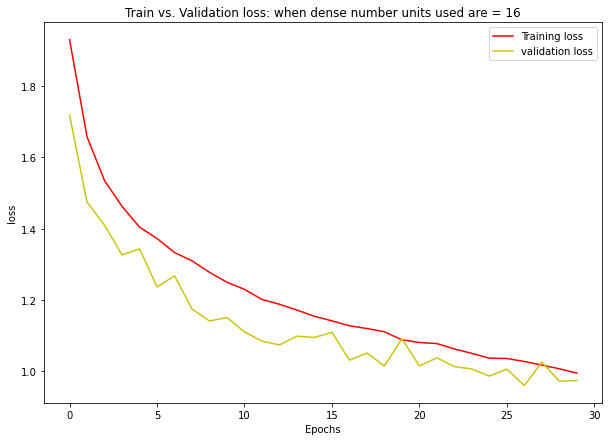

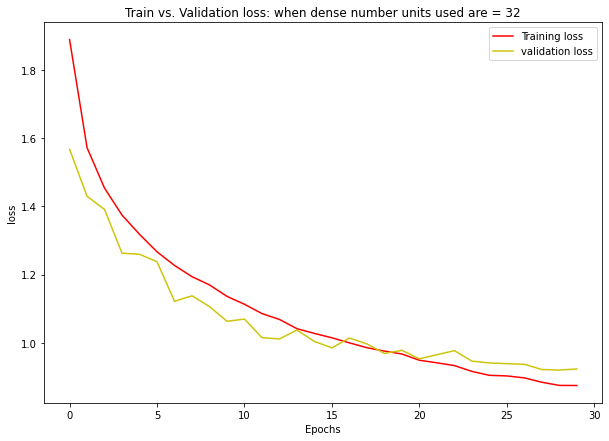

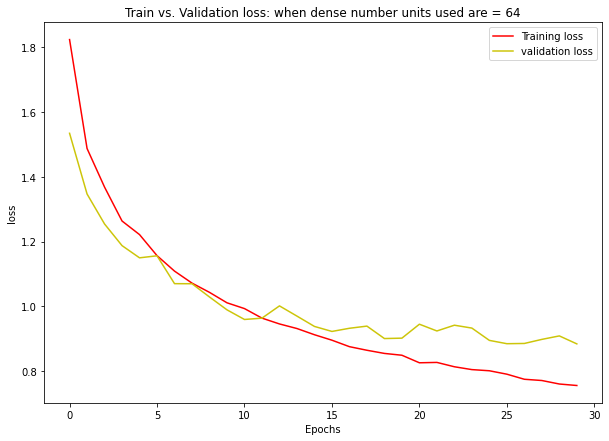

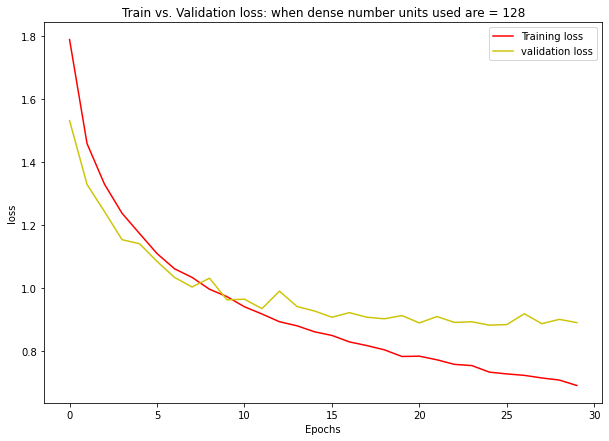

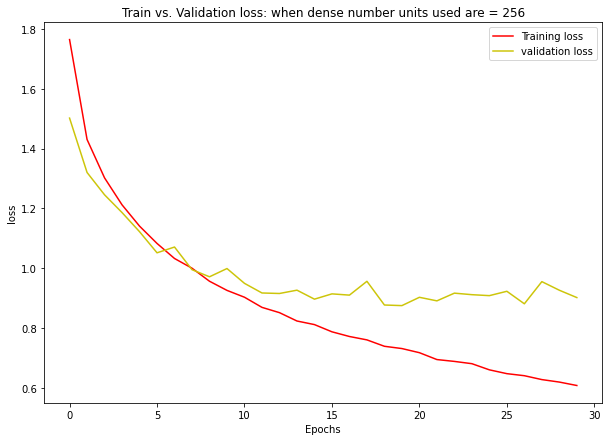

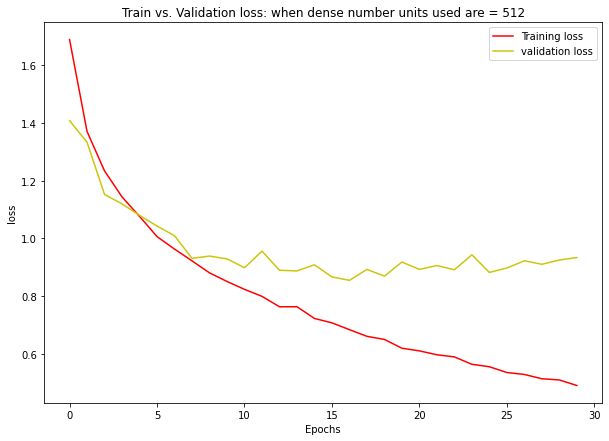

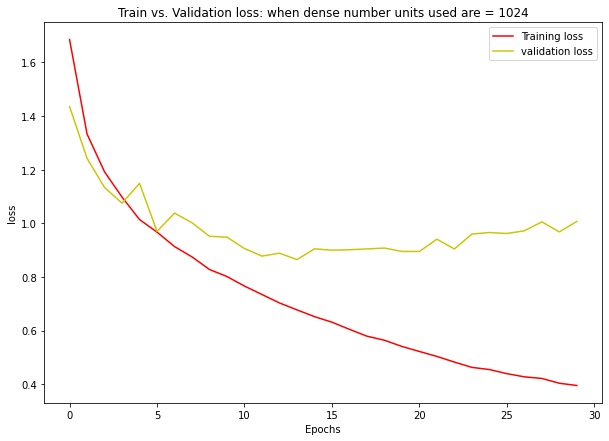

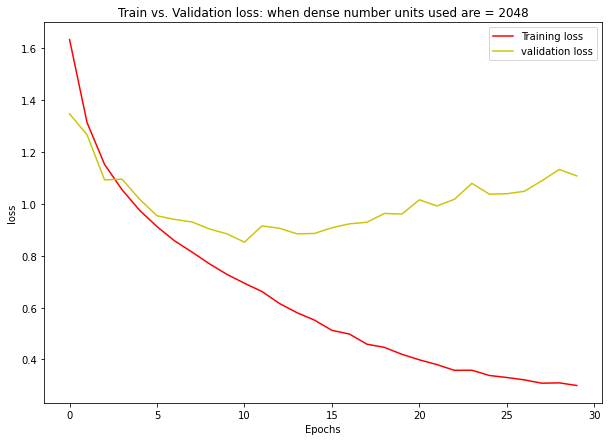

time: 1.66 s (started: 2022-05-30 00:27:33 +00:00)


In [ ]:
# a helper function used to print the line charts when different number of units are used in the dense layer
generatePlot(history_D, 'dense number units used are')

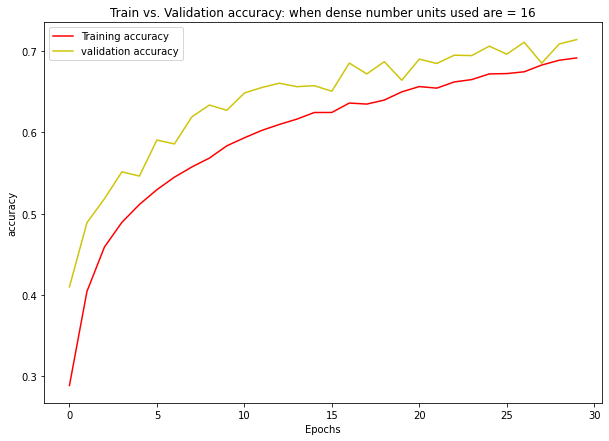

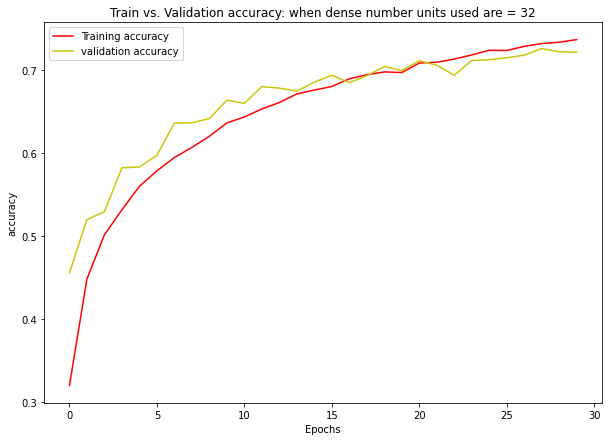

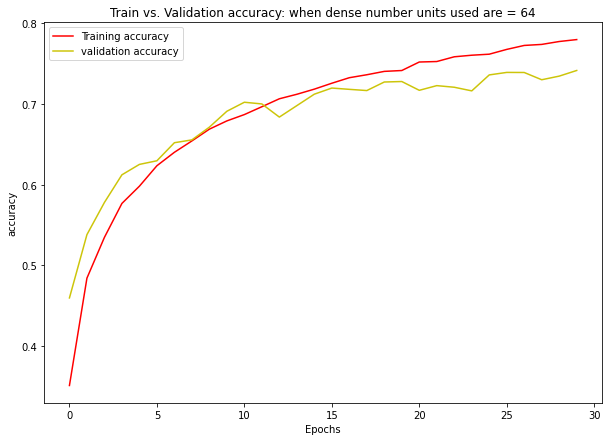

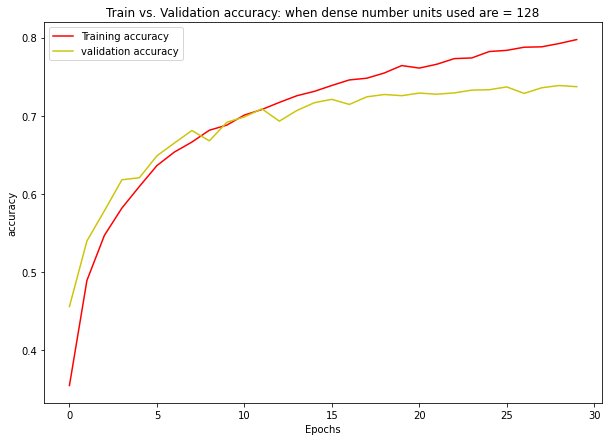

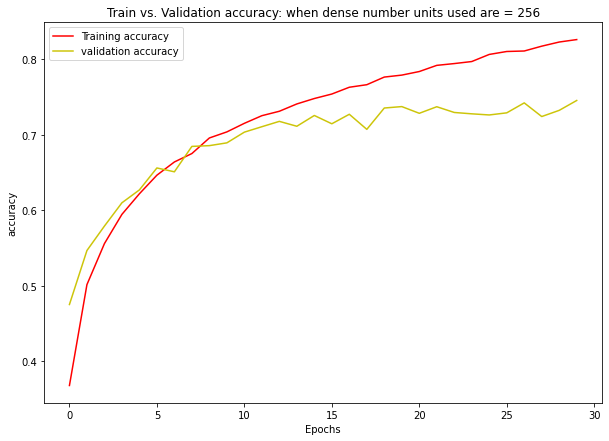

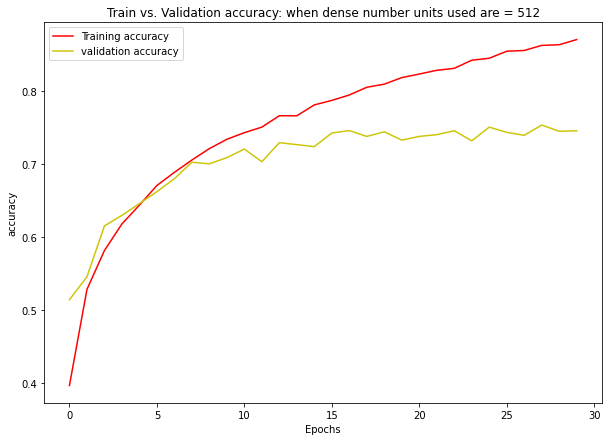

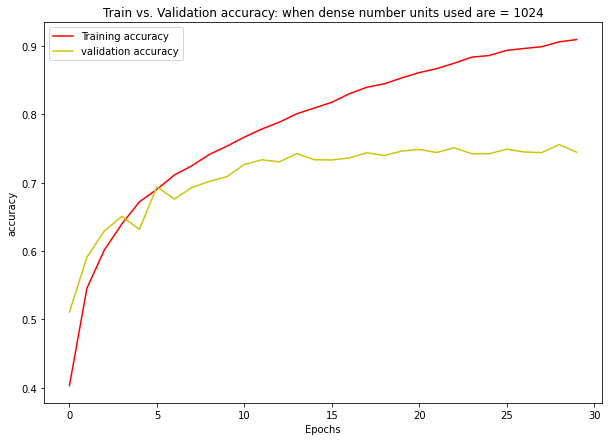

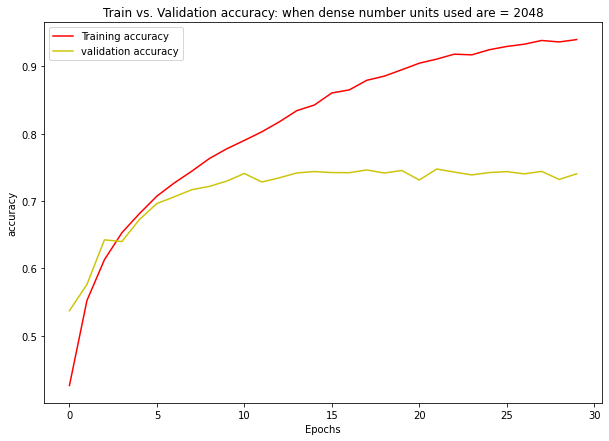

time: 1.63 s (started: 2022-05-30 00:27:40 +00:00)


In [ ]:
generate_accuracy_Plot(history_D, titleStr='dense number units used are')

In [ ]:
# a helper function that returns data frames for for losss, accuracy and run time execution
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'number_of_units_used')

time: 2.44 ms (started: 2022-05-29 11:11:56 +00:00)


In [ ]:
val_loss_df

number_of_units_used  val_loss
0                    16  0.969271
1                    32  0.899810
2                    64  0.902215
3                   128  0.947066
4                   256  0.926309
5                   512  0.891516
6                  1024  0.992774
7                  2048  1.071076

time: 6.27 ms (started: 2022-05-29 11:11:56 +00:00)


In [ ]:
val_accuracy_df

number_of_units_used  val_accuracy_L
0                    16          0.7039
1                    32          0.7310
2                    64          0.7248
3                   128          0.7142
4                   256          0.7322
5                   512          0.7424
6                  1024          0.7366
7                  2048          0.7418

time: 6.95 ms (started: 2022-05-29 11:11:56 +00:00)


<p>Amongst the different units we have explored, 64 is the optimal number of units to be used in the dense layer because it has the highest validation accuracy and a low validation loss. Also, we see that there is less overfitting so we shall leave the number of units in the dense layer as is. </p>

### Make the predictions and write the results to a csv file

In [ ]:
# let's make the required predictions
predictions = model.predict([test_images])

time: 759 ms (started: 2022-05-29 11:11:57 +00:00)


In [ ]:
# let's convert a numpy array into a list
predictions_L = predictions.tolist()

# helper function that writes predictions Results to a csv file
writeResultsToCsv(predictions_L)

time: 161 ms (started: 2022-05-29 11:11:57 +00:00)


## Size of filters

let's explore various values to determine the optimal size of the filters.

### Create a Convolutional network, compile and train the model with the different size of filters

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
filter_size_L = [1, 3, 5, 7, 9, 11]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(filter_size_L)):
  print('Exploring filter size %s'%str(filter_size_L[fact]))
  model = models.Sequential()
  model.add(layers.Conv2D(32, (filter_size_L[fact], filter_size_L[fact]), padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (filter_size_L[fact], filter_size_L[fact]), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (filter_size_L[fact], filter_size_L[fact]), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  # last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above
  # model.summary()

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((filter_size_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[filter_size_L[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  # append the val_loss of the current execution to the list
  val_loss_L.append([filter_size_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  val_accuracy_L.append([filter_size_L[fact], val_acc])

Exploring filter size 1
Epoch 1/30
400/400 [==============================] - 2s 5ms/step - loss: 1.9200 - accuracy: 0.3227 - val_loss: 1.6713 - val_accuracy: 0.4117
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.6350 - accuracy: 0.4316 - val_loss: 1.5285 - val_accuracy: 0.4632
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.5395 - accuracy: 0.4674 - val_loss: 1.4638 - val_accuracy: 0.4951
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4936 - accuracy: 0.4834 - val_loss: 1.4454 - val_accuracy: 0.4977
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4563 - accuracy: 0.4985 - val_loss: 1.3919 - val_accuracy: 0.5187
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4220 - accuracy: 0.5094 - val_loss: 1.3720 - val_accuracy: 0.5313
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4015 - accuracy: 0.5193 - val_loss: 1.3545 - val

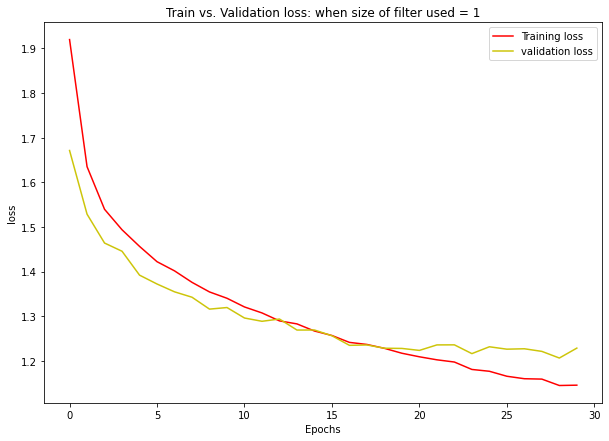

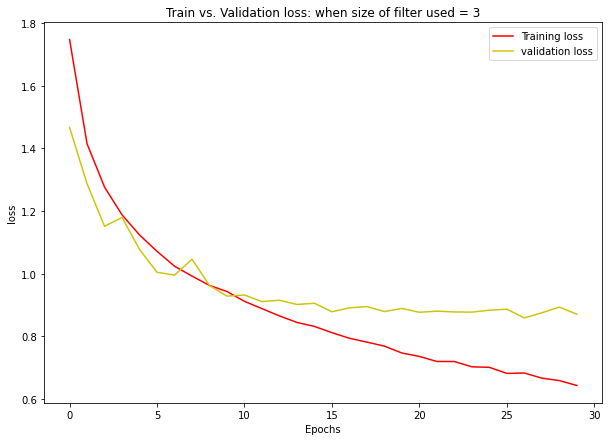

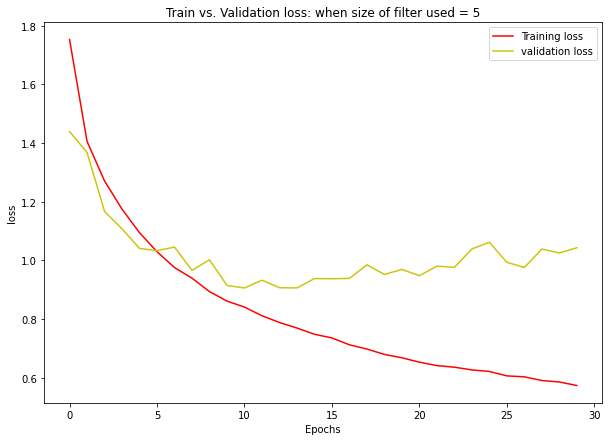

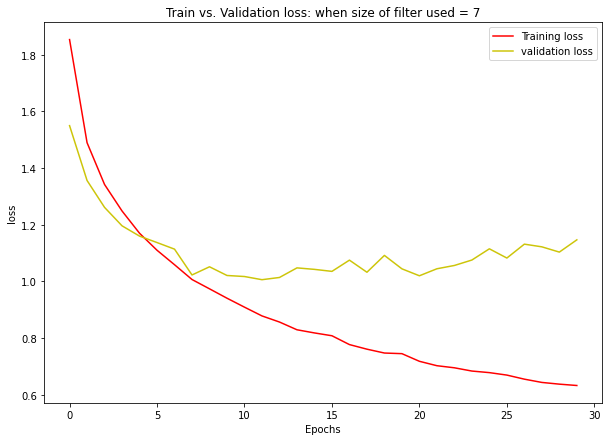

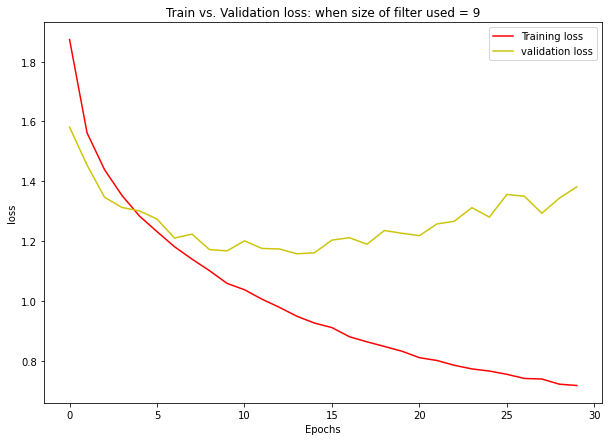

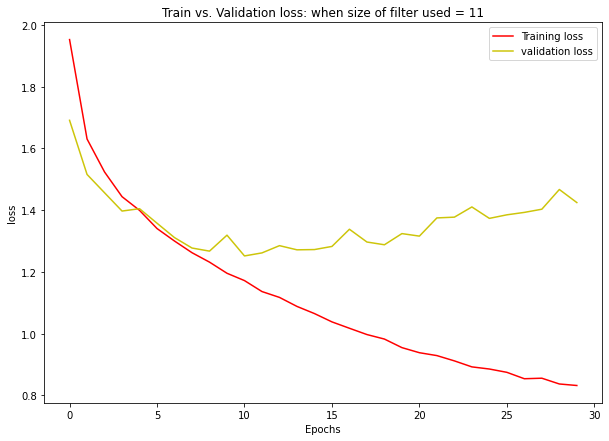

time: 1.22 s (started: 2022-05-29 11:17:50 +00:00)


In [ ]:
# a helper function used to prints the loss line charts for the different  number of filters used
generatePlot(history_D, 'size of filter used')

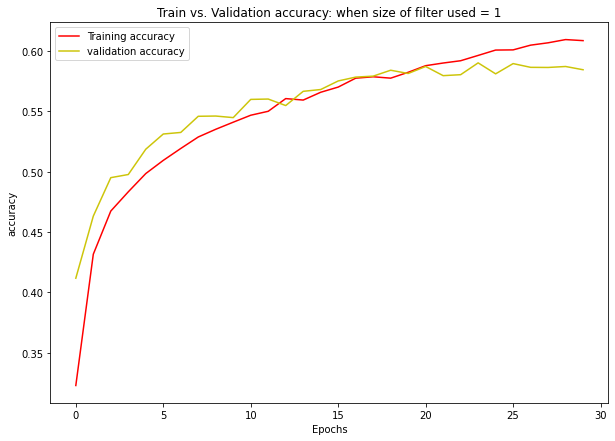

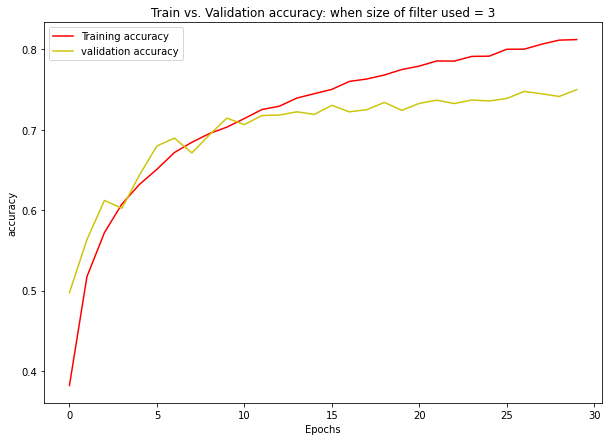

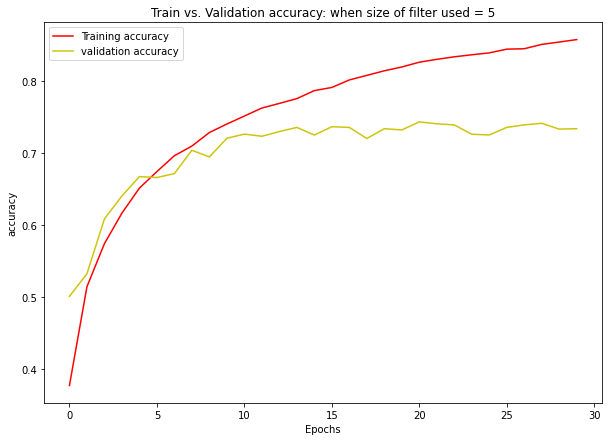

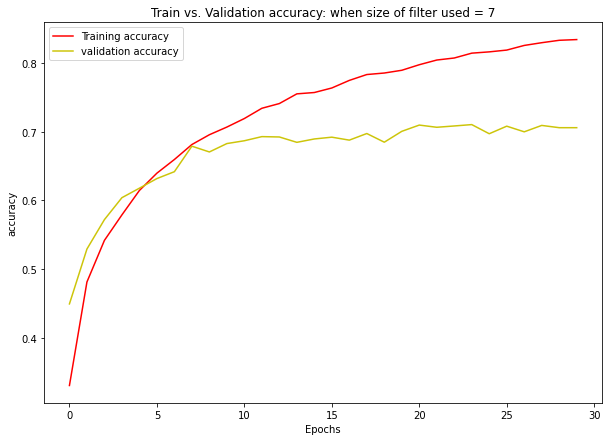

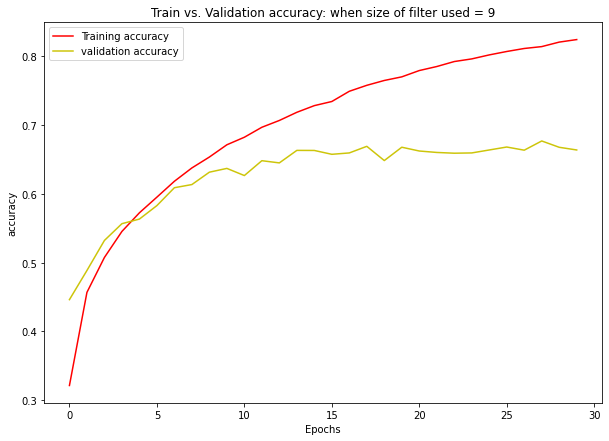

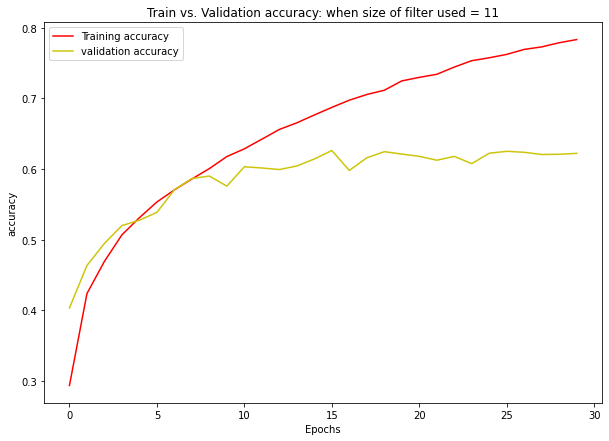

time: 1.74 s (started: 2022-05-29 11:17:51 +00:00)


In [ ]:
# a helper function used to prints the accuracy line charts for the different  number of filters used
generate_accuracy_Plot(history_D, 'size of filter used')

<p>We observe that as training epochs increases, both training and validation accuracy for the filter sizes 1, 3, 5, 7, and 11 increase. For filter size 1, the the validation accuracy is higher than the training accuracy, which might be a sign of underfitting. For 3, 5, 7, in the initial stages as the model is training the input neurons, the validation accuracy is high than training but at some point as the training epochs increase, training accuracy is higher than validation accuracy. Compared to 1, 5, 7 and 11, we see that the filter size 3 is the optimal size since it has a high validation accuracy with less overfitting. </p>

In [ ]:
# a helper function that returns data frames for for losss, accuracy and run time execution
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'size_of_filter')

time: 2.56 ms (started: 2022-05-29 11:17:53 +00:00)


In [ ]:
val_loss_df

size_of_filter  val_loss
0               1  1.228286
1               3  0.870897
2               5  1.042999
3               7  1.146323
4               9  1.381623
5              11  1.424615

time: 5.58 ms (started: 2022-05-29 11:17:53 +00:00)


In [ ]:
val_accuracy_df

size_of_filter  val_accuracy_L
0               1          0.5846
1               3          0.7499
2               5          0.7337
3               7          0.7058
4               9          0.6638
5              11          0.6223

time: 5.97 ms (started: 2022-05-29 11:17:53 +00:00)


We observe that 3 is the optimal size of filter to be because it has less overfitting and it has a high accuracy with a low validation score. 

### let's create a CNN, compile and train the model with the best optimal size of filter, 3, with the rest of the best hyperparameters we have explored. 

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
# first dropout
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

# last dropout
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))  # As noted above
# model.summary()

#print(learningRate_L[eta])
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# compile the model
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  
# train the model
history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))

Epoch 1/30
400/400 [==============================] - 3s 5ms/step - loss: 1.7593 - accuracy: 0.3798 - val_loss: 1.4986 - val_accuracy: 0.4841
Epoch 2/30
400/400 [==============================] - 2s 5ms/step - loss: 1.4256 - accuracy: 0.5114 - val_loss: 1.2706 - val_accuracy: 0.5718
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2909 - accuracy: 0.5661 - val_loss: 1.1820 - val_accuracy: 0.6092
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1970 - accuracy: 0.6030 - val_loss: 1.1074 - val_accuracy: 0.6306
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1199 - accuracy: 0.6326 - val_loss: 1.0784 - val_accuracy: 0.6453
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0691 - accuracy: 0.6536 - val_loss: 1.0350 - val_accuracy: 0.6645
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0176 - accuracy: 0.6731 - val_loss: 0.9914 - val_accuracy: 0.6794
Epoch 

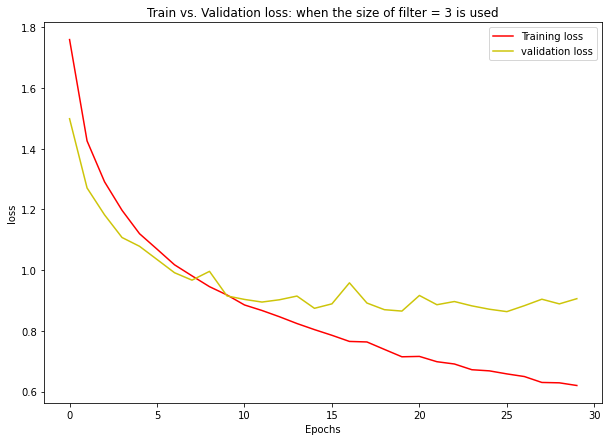

time: 178 ms (started: 2022-05-29 11:18:47 +00:00)


In [ ]:
# set the figure
plt.figure(figsize=(10, 7))
line_mse = plt.plot(range(0,EPOCHS), history.history['loss'], 'r')
line_crossEntropy = plt.plot(range(0,EPOCHS), history.history['val_loss'], '#cdc50a')
plt.title('Train vs. Validation loss: when the size of filter = 3 is used')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'validation loss'])
plt.show()


<p>Here notice that as in initial stage when the network is training the model, trainin loss is higher than validation loss. Around the 8th training epoch validation loss starts to get higher than training loss which indicates overfitting.</p>

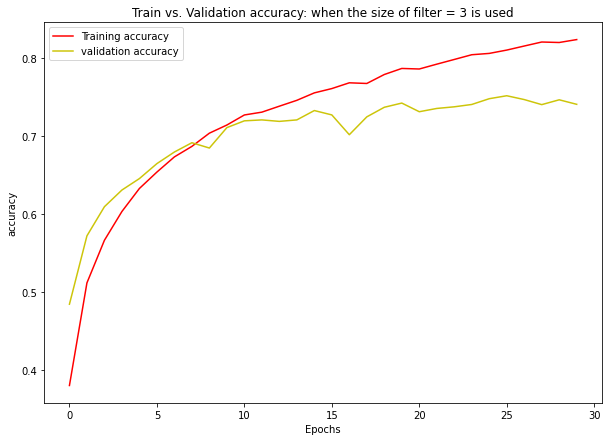

time: 168 ms (started: 2022-05-29 11:18:47 +00:00)


In [ ]:
# set the figure
plt.figure(figsize=(10, 7))
line_mse = plt.plot(range(0,EPOCHS), history.history['accuracy'], 'r')
line_crossEntropy = plt.plot(range(0,EPOCHS), history.history['val_accuracy'], '#cdc50a')
plt.title('Train vs. Validation accuracy: when the size of filter = 3 is used')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend(['Training accuracy', 'validation accuracy'])
plt.show()

<p>In initial stage when the network is training the model, validation accuracy is higher than training accuracy then between the 10th and 15th training epoch, training accuracy starts to get higher than the validation accuracy. </p>

In [ ]:
# create a data frame containing the loss and accuracy of the model

data = {'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
        'val_loss': history.history['val_loss'], 
        'val_accuracy': history.history['val_accuracy'],
        'loss':history.history['loss'],
        'training accuracy':history.history['accuracy']}
# create a data frame
val_accuracy_loss_df = pd.DataFrame(data)

time: 4.28 ms (started: 2022-05-29 11:18:48 +00:00)


In [ ]:
#sort the data frame by validation accuracy
val_accuracy_loss_df.sort_values(by=['val_accuracy'], inplace=True, ascending=False) # the first five records
print(val_accuracy_loss_df)

    Epoch  val_loss  val_accuracy      loss  training accuracy
25     26  0.863278        0.7516  0.658218           0.810200
24     25  0.871199        0.7478  0.668240           0.805925
26     27  0.882878        0.7467  0.649528           0.815400
28     29  0.888806        0.7464  0.628825           0.819925
19     20  0.865101        0.7422  0.714580           0.786625
29     30  0.905938        0.7406  0.620001           0.823675
23     24  0.882258        0.7404  0.671958           0.804225
27     28  0.904199        0.7402  0.630041           0.820550
22     23  0.896563        0.7374  0.690846           0.798150
18     19  0.869682        0.7368  0.738858           0.778850
21     22  0.886041        0.7353  0.698363           0.792125
14     15  0.874223        0.7326  0.804049           0.755275
20     21  0.916503        0.7311  0.715799           0.785925
15     16  0.888939        0.7270  0.785341           0.760800
17     18  0.891620        0.7245  0.763417           0

<p>We see that val_accuracy is 0.7556 and val_loss is 0.82.</p>

### Make the predictions and write the results to a csv file

In [ ]:
#let's make the required predictions
predictions = savedModel.predict([test_images])

time: 709 ms (started: 2022-05-29 11:18:48 +00:00)


In [ ]:
# let's convert a numpy array into a list
predictions_L = predictions.tolist()

# helper function that writes predictions Results to a csv file
writeResultsToCsv(predictions_L)

time: 152 ms (started: 2022-05-29 11:18:48 +00:00)


## Size of the stride

let's determine the optimal size of the stride of the filter on the input image to explore the actual size that can be used to downsample the size of the output feature.

### Create a CNN, compile and train the model with the different stride values

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
train_loss_L = []                             # list of train loss
train_accuracy_L = []                         # list of train accuracy
stride_L = [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3)]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(stride_L)):
  print('\n Exploring strides %s'%str(stride_L[fact]))
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), strides=(stride_L[fact][0], stride_L[fact][0]) ,padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), strides=(stride_L[fact][1], stride_L[fact][1]), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  # last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above
  # model.summary()

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((stride_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[stride_L[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  train_loss, train_accuracy = model.evaluate(train_images, train_labels)



  # append the train_loss, val_loss of the current execution to the list
  train_loss_L.append([stride_L[fact], train_loss])
  val_loss_L.append([stride_L[fact], val_loss])

  # append training and validation accuracy of the current execution to the different lists 
  train_accuracy_L.append([stride_L[fact], train_accuracy])
  val_accuracy_L.append([stride_L[fact], val_acc])


 Exploring strides (1, 1)
Epoch 1/30
400/400 [==============================] - 3s 5ms/step - loss: 1.7730 - accuracy: 0.3751 - val_loss: 1.4577 - val_accuracy: 0.5061
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4290 - accuracy: 0.5116 - val_loss: 1.2809 - val_accuracy: 0.5670
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2985 - accuracy: 0.5619 - val_loss: 1.1867 - val_accuracy: 0.6030
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2048 - accuracy: 0.6004 - val_loss: 1.1025 - val_accuracy: 0.6433
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1326 - accuracy: 0.6274 - val_loss: 1.0568 - val_accuracy: 0.6522
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0881 - accuracy: 0.6486 - val_loss: 1.0221 - val_accuracy: 0.6712
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0336 - accuracy: 0.6687 - val_loss: 1.0194 - 

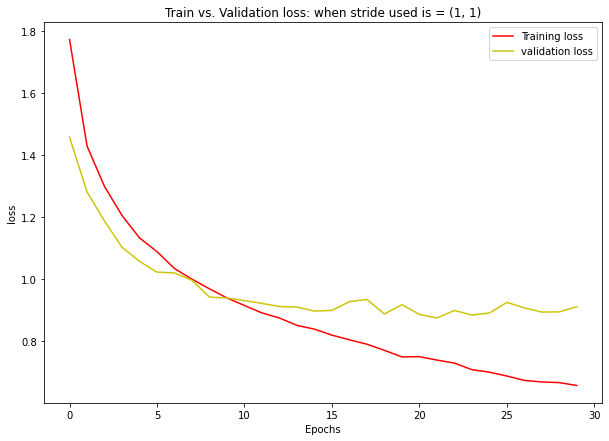

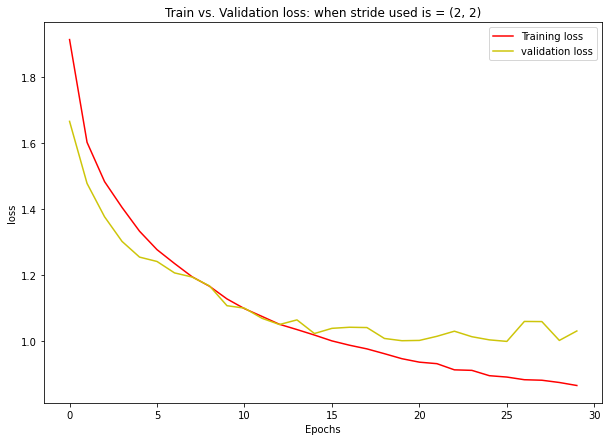

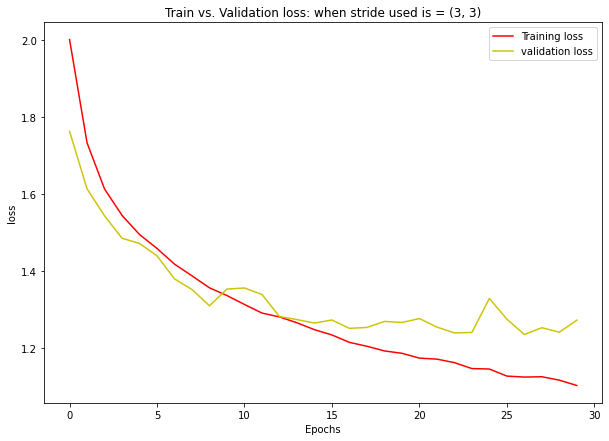

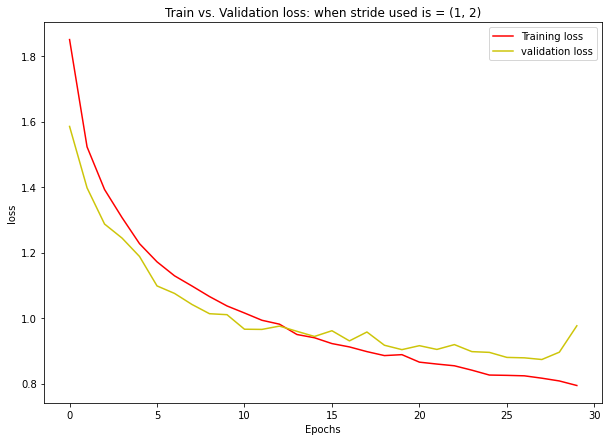

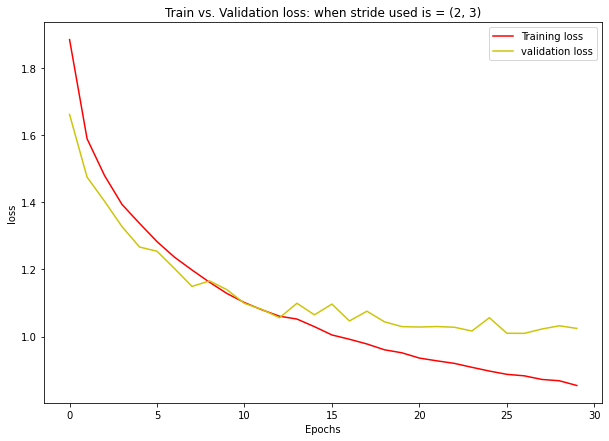

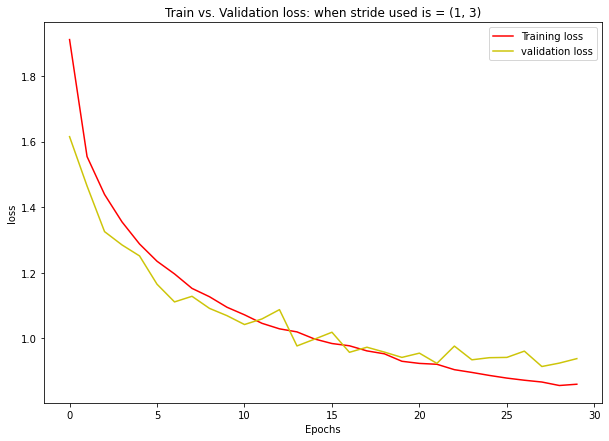

time: 1.19 s (started: 2022-05-29 11:24:29 +00:00)


In [ ]:
# a helper function used to prints the loss line charts for the different stride values used
generatePlot(history_D, 'stride used is')

<p>We observe that in the initial stages when the model is training, training loss is higher than validation loss but as the training epoch increases validation loss is higher than training loss, and amongst all the strides which have been used stride, (1, 1) has the best validation accuracy and low validation loss but with high overfitting when compared to stride (1, 2), which experiences less overfitting.  This explain that stride (1, 2) is the best optimal stride.</p>

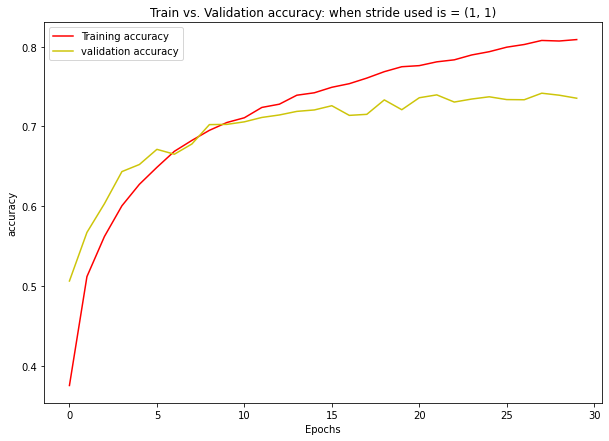

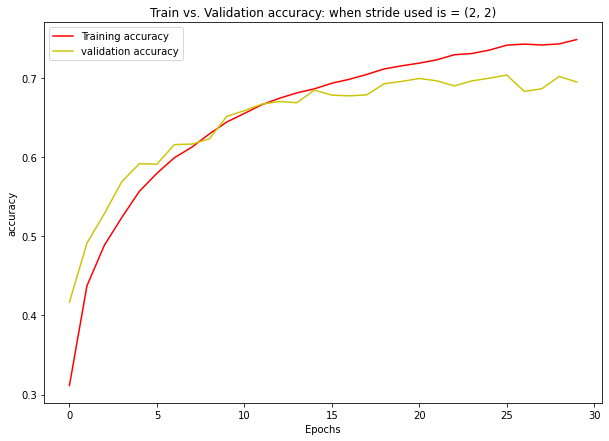

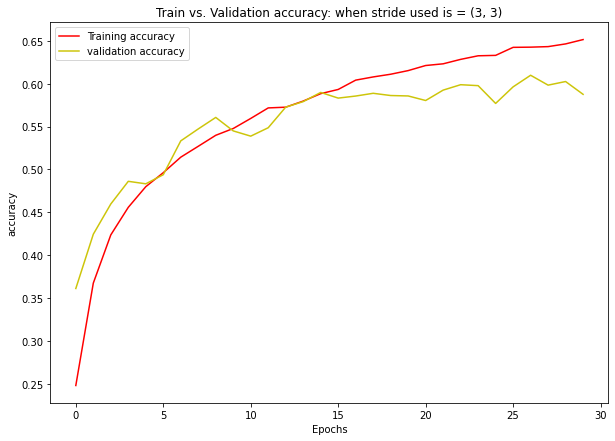

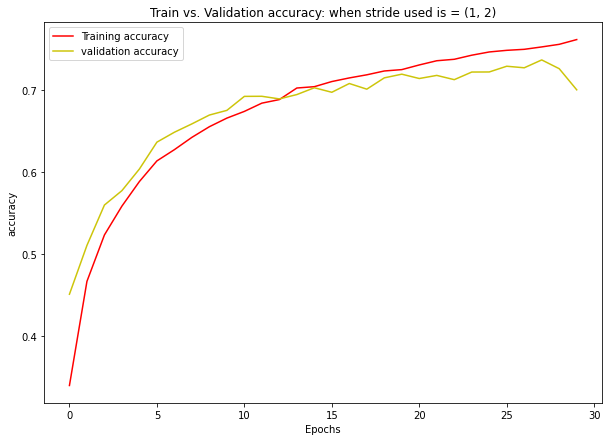

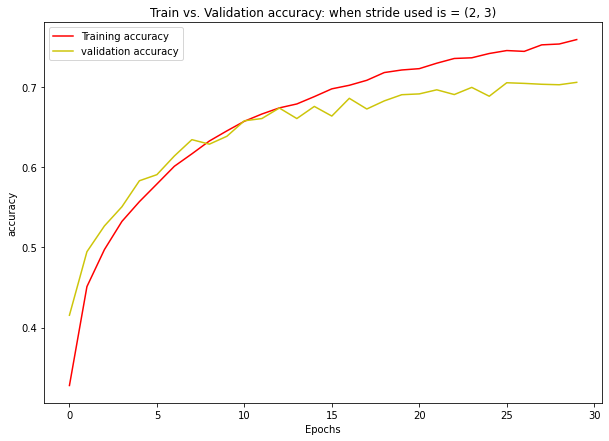

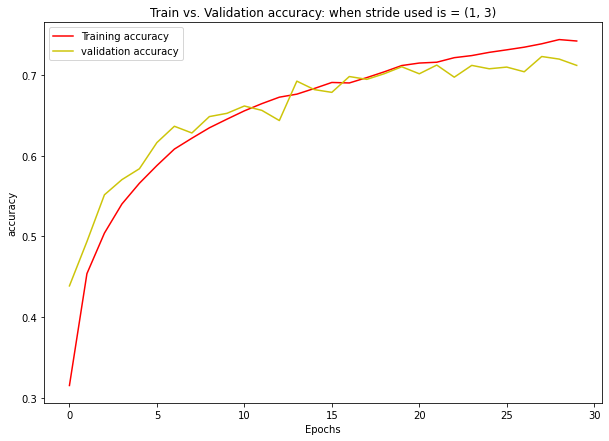

time: 1.67 s (started: 2022-05-29 11:24:30 +00:00)


In [ ]:
# a helper function used to prints the accuracy line charts for the different stride values used
generate_accuracy_Plot(history_D, 'stride used is')

<p>Compared to other sets of strides,  we observe that stride (1, 1) has the highest validation accuracy and low validation loss but stride (1, 2) less overfitting so we consider stride(1,2) as the optimal one.</p>

In [ ]:
# helper function that derives and return the different data frames for validation
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'size_of_stride')

time: 2.28 ms (started: 2022-05-29 11:24:32 +00:00)


In [ ]:
val_loss_df

size_of_stride  val_loss
0         (1, 1)  0.910408
1         (2, 2)  1.029606
2         (3, 3)  1.273488
3         (1, 2)  0.976380
4         (2, 3)  1.024249
5         (1, 3)  0.938504

time: 7.75 ms (started: 2022-05-29 11:24:32 +00:00)


In [ ]:
val_accuracy_df

size_of_stride  val_accuracy_L
0         (1, 1)          0.7353
1         (2, 2)          0.6951
2         (3, 3)          0.5875
3         (1, 2)          0.7005
4         (2, 3)          0.7054
5         (1, 3)          0.7118

time: 8.24 ms (started: 2022-05-29 11:24:32 +00:00)


In [ ]:
# helper function that returns the data frame for the train loss and accuracy
train_loss_df, train_accuracy_df= deriveAccuracy_df(train_loss_L, train_accuracy_L, 'size_of_stride')

time: 1.68 ms (started: 2022-05-29 11:24:32 +00:00)


In [ ]:
train_loss_df

size_of_stride  train_loss
0         (1, 1)    0.488292
1         (2, 2)    0.739526
2         (3, 3)    1.026762
3         (1, 2)    0.732871
4         (2, 3)    0.712047
5         (1, 3)    0.703984

time: 6.62 ms (started: 2022-05-29 11:24:32 +00:00)


In [ ]:
train_accuracy_df

size_of_stride  train_accuracy
0         (1, 1)        0.886425
1         (2, 2)        0.799425
2         (3, 3)        0.677475
3         (1, 2)        0.783075
4         (2, 3)        0.814225
5         (1, 3)        0.802900

time: 7.22 ms (started: 2022-05-29 11:24:32 +00:00)


### let's explore other sets of strides at all Convolutional layers

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
train_loss_L = []                             # list of train loss
train_accuracy_L = []                         # list of train accuracy
stride_L = [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3)]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(stride_L)):
  print('\n Exploring strides %s'%str(stride_L[fact]))
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), strides=(stride_L[fact][0], stride_L[fact][0]) ,padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), strides=(stride_L[fact][1], stride_L[fact][1]) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), strides=(stride_L[fact][1], stride_L[fact][1]), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  # last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above
  # model.summary()

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((stride_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[stride_L[fact]] = history

  val_loss, val_acc = model.evaluate(valid_images, valid_labels)

  train_loss, train_accuracy = model.evaluate(train_images, train_labels)



  # append the train_loss, val_loss of the current execution to the list
  train_loss_L.append([stride_L[fact], train_loss])
  val_loss_L.append([stride_L[fact], val_loss])

  # append training and validation accuracy of the current execution to the different lists 
  train_accuracy_L.append([stride_L[fact], train_accuracy])
  val_accuracy_L.append([stride_L[fact], val_acc])


 Exploring strides (1, 1)
Epoch 1/30
400/400 [==============================] - 3s 5ms/step - loss: 1.7601 - accuracy: 0.3778 - val_loss: 1.4364 - val_accuracy: 0.5176
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4237 - accuracy: 0.5125 - val_loss: 1.2870 - val_accuracy: 0.5697
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2932 - accuracy: 0.5662 - val_loss: 1.1748 - val_accuracy: 0.6150
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1937 - accuracy: 0.6074 - val_loss: 1.1115 - val_accuracy: 0.6345
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1359 - accuracy: 0.6313 - val_loss: 1.0410 - val_accuracy: 0.6586
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0748 - accuracy: 0.6543 - val_loss: 1.0206 - val_accuracy: 0.6739
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0325 - accuracy: 0.6702 - val_loss: 0.9812 - 

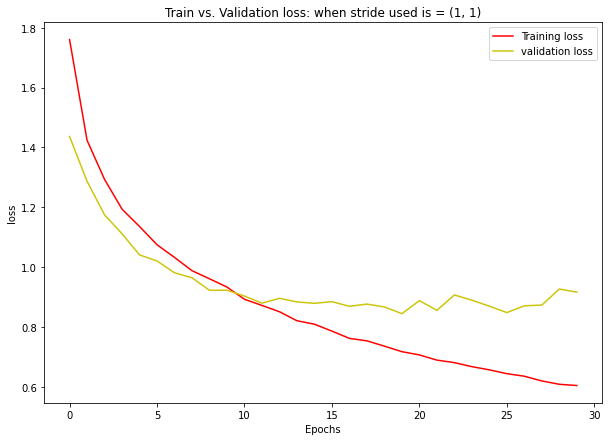

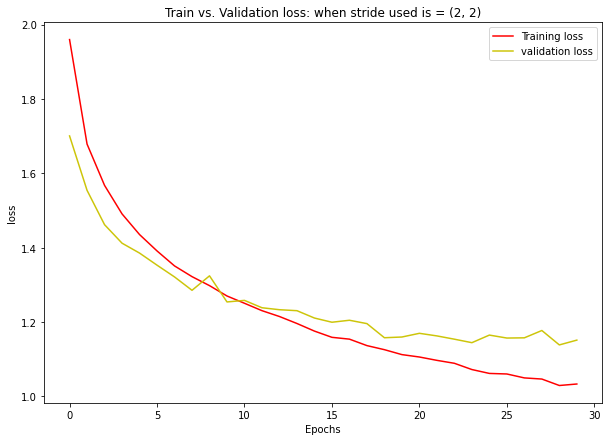

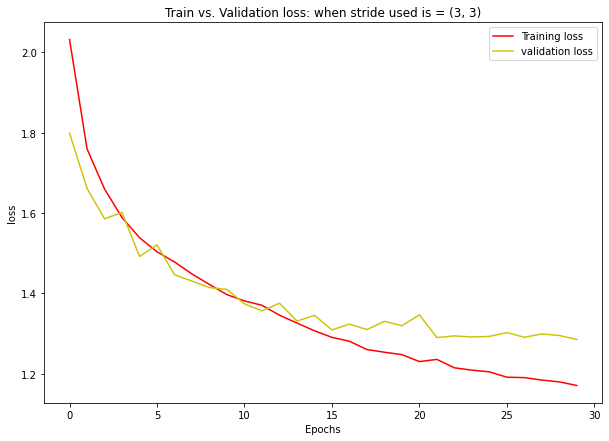

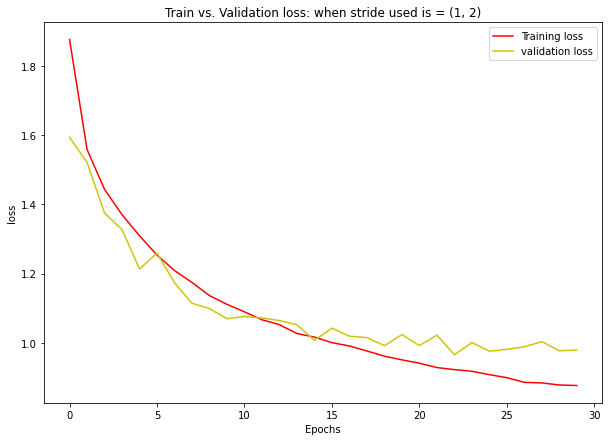

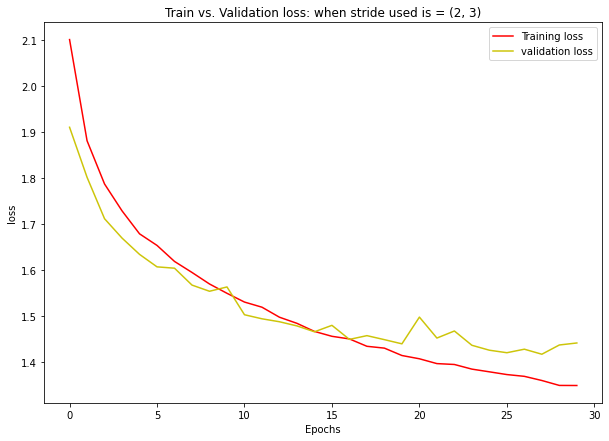

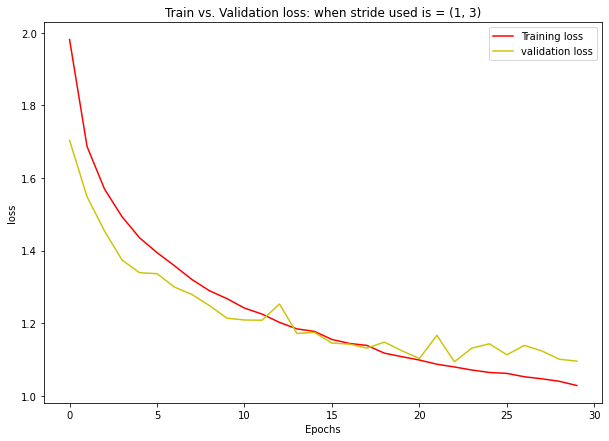

time: 1.16 s (started: 2022-05-29 11:29:59 +00:00)


In [ ]:
# a helper function used to prints the loss line charts for the different stride values used
generatePlot(history_D, 'stride used is')

<p>With the exception of the stride set (1,1), all other strides have fluactuating validation loss curves which is an indication that as training epochs increase we might start seeing some spikes. Overall, the stride set (1, 1), which is applied at all Convolutional layers has less overfitting, which makes it to the optimal value.</p>

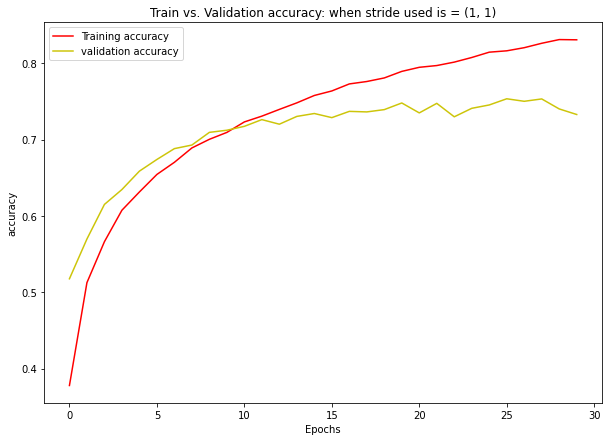

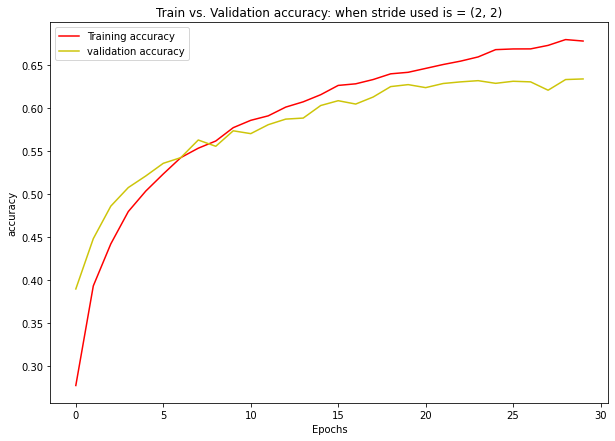

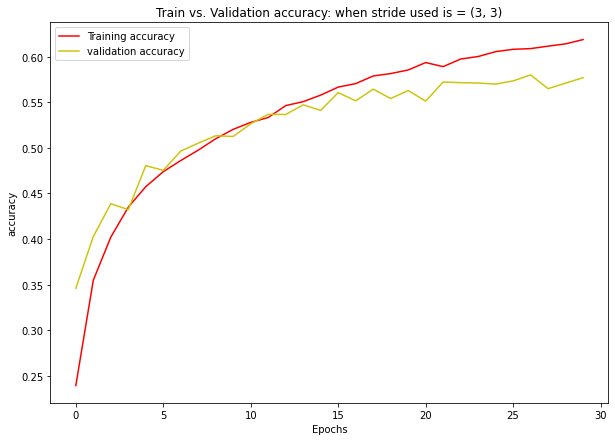

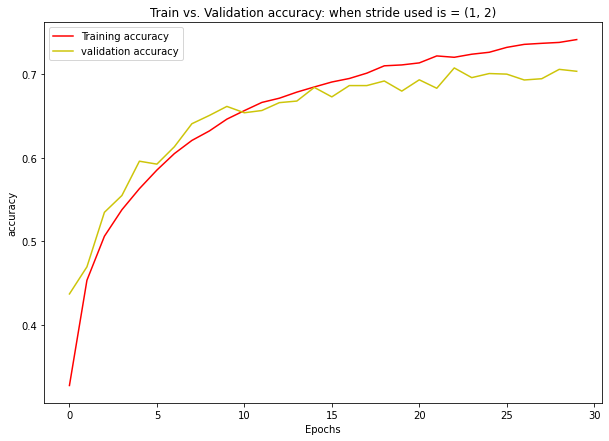

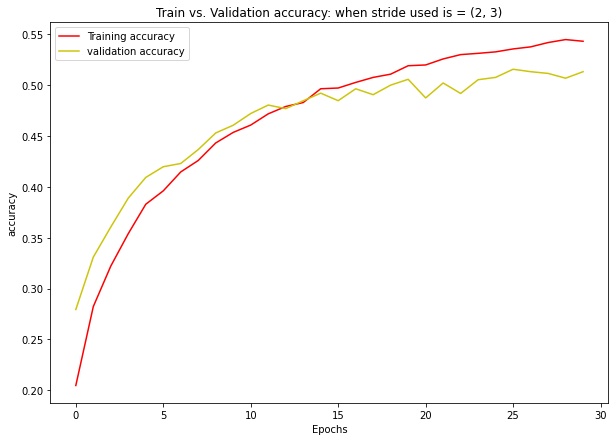

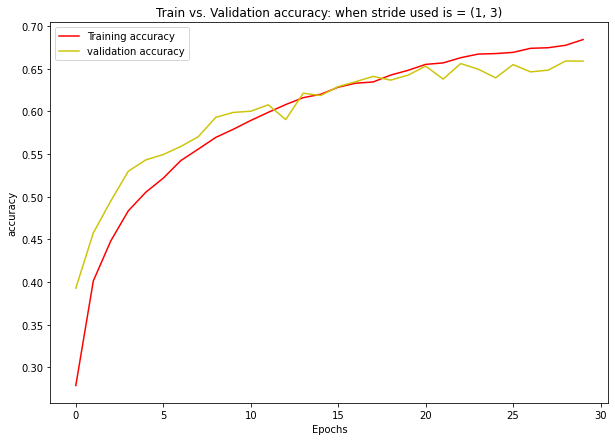

time: 1.72 s (started: 2022-05-29 11:30:00 +00:00)


In [ ]:
# a helper function used to prints the accuracy line charts for the different stride values used
generate_accuracy_Plot(history_D, 'stride used is')

In [ ]:
# helper function that derives and return the different data frames for validation
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'size_of_stride')

time: 2.55 ms (started: 2022-05-29 11:30:02 +00:00)


In [ ]:
val_loss_df

size_of_stride  val_loss
0         (1, 1)  0.916541
1         (2, 2)  1.151432
2         (3, 3)  1.285136
3         (1, 2)  0.978849
4         (2, 3)  1.442218
5         (1, 3)  1.095254

time: 7.74 ms (started: 2022-05-29 11:30:02 +00:00)


In [ ]:
val_accuracy_df

size_of_stride  val_accuracy_L
0         (1, 1)          0.7328
1         (2, 2)          0.6340
2         (3, 3)          0.5770
3         (1, 2)          0.7032
4         (2, 3)          0.5131
5         (1, 3)          0.6588

time: 7.26 ms (started: 2022-05-29 11:30:02 +00:00)


<p>Compared to other stride sets, (1,1) has the highest validation accuracy of 0.75.</p>

In [ ]:
# helper function that returns the data frame for the train loss and accuracy
train_loss_df, train_accuracy_df= deriveAccuracy_df(train_loss_L, train_accuracy_L, 'size_of_stride')

time: 1.49 ms (started: 2022-05-29 11:30:02 +00:00)


In [ ]:
train_loss_df

size_of_stride  train_loss
0         (1, 1)    0.473946
1         (2, 2)    0.906746
2         (3, 3)    1.080985
3         (1, 2)    0.728986
4         (2, 3)    1.277266
5         (1, 3)    0.855275

time: 7.08 ms (started: 2022-05-29 11:30:02 +00:00)


In [ ]:
train_accuracy_df

size_of_stride  train_accuracy
0         (1, 1)        0.892275
1         (2, 2)        0.722675
2         (3, 3)        0.646525
3         (1, 2)        0.794875
4         (2, 3)        0.575625
5         (1, 3)        0.747125

time: 7.04 ms (started: 2022-05-29 11:30:02 +00:00)


<p>Comparing the two experiments, applying strides to both the first  ,and last Convolutional layers and applying it to all layers, both experiments confirm that stride set (1, 1) is the optimal value so I will go a head and apply it to all layers. </p>

## Add more Convolution layers



#### Experiment 1: adding 1 more Convolution layer at each layer and including MaxPooling layer at the last Convolution layer and also testing for the optimal number of filters

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# first dropout
#model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

# last dropout
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))  # As noted above
model.summary()

#print(learningRate_L[eta])
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# compile the model
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])
  
history1 = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_249 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_250 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_166 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_251 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_252 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_167 (MaxPooli  (None, 8, 8, 64)         0         
 ng2D)                                               

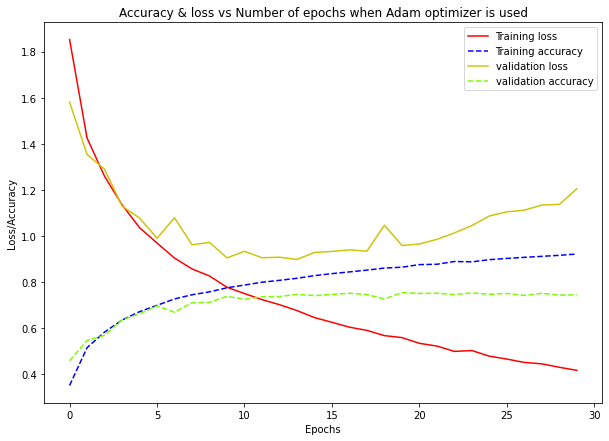

time: 229 ms (started: 2022-05-29 11:31:11 +00:00)


In [ ]:
# helper function that derives the loss and accuracy line charts
deriveLossAccuracyLineCharts(history1.history, 'adding one more Convolutional layer')

In [ ]:
history1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

time: 3.34 ms (started: 2022-05-29 11:31:12 +00:00)


In [ ]:
print('Max validation accuracy:  %.4f Min validation loss: %.4f Training accuracy: %.4f'%(max(history1.history['val_accuracy']), min(history1.history['val_loss']), max(history1.history['accuracy'])))

Max validation accuracy:  0.7538 Min validation loss: 0.8975 Training accuracy: 0.9211
time: 1.11 ms (started: 2022-05-29 11:31:12 +00:00)


#### Adjusting the number of filters

##### Added Convolutional layers on all existing CNN layers

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
train_loss_L = []                             # list of train loss
train_accuracy_L = []                         # list of train accuracy
num_filters_L = [(24, 48, 80),(32, 64, 64), (32, 64, 128), (64, 96, 128), (32, 96, 80), (32, 48, 128)]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(num_filters_L)):
  print('Number of filter pairs being used: %s, %s, %s' %(str(num_filters_L[fact][0]), str(num_filters_L[fact][1]), str(num_filters_L[fact][2])))
  model = models.Sequential()
  # get the first indice of the tuple - num_filters_L[fact][0]
  model.add(layers.Conv2D(num_filters_L[fact][0], (3, 3), strides=(1,1) ,padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(num_filters_L[fact][0], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(num_filters_L[fact][1], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(num_filters_L[fact][1], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(num_filters_L[fact][2], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(num_filters_L[fact][2], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  # last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((num_filters_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[num_filters_L[fact]] = history

  # compute the loss and accuracy
  val_loss, val_acc = model.evaluate(valid_images, valid_labels)
  train_loss, train_accuracy = model.evaluate(train_images, train_labels)

  # append the val_loss of the current execution to the list
  train_loss_L.append([num_filters_L[fact], train_loss])
  val_loss_L.append([num_filters_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  train_accuracy_L.append([num_filters_L[fact], train_accuracy])
  val_accuracy_L.append([num_filters_L[fact], val_acc])

Number of filter pairs being used: 24, 48, 80
Epoch 1/30
400/400 [==============================] - 3s 6ms/step - loss: 1.9320 - accuracy: 0.3040 - val_loss: 1.6809 - val_accuracy: 0.4019
Epoch 2/30
400/400 [==============================] - 2s 6ms/step - loss: 1.5490 - accuracy: 0.4566 - val_loss: 1.4004 - val_accuracy: 0.5166
Epoch 3/30
400/400 [==============================] - 2s 5ms/step - loss: 1.4017 - accuracy: 0.5215 - val_loss: 1.3267 - val_accuracy: 0.5463
Epoch 4/30
400/400 [==============================] - 2s 5ms/step - loss: 1.2913 - accuracy: 0.5687 - val_loss: 1.2028 - val_accuracy: 0.6017
Epoch 5/30
400/400 [==============================] - 2s 6ms/step - loss: 1.2127 - accuracy: 0.6030 - val_loss: 1.1597 - val_accuracy: 0.6196
Epoch 6/30
400/400 [==============================] - 2s 6ms/step - loss: 1.1515 - accuracy: 0.6308 - val_loss: 1.0974 - val_accuracy: 0.6467
Epoch 7/30
400/400 [==============================] - 2s 5ms/step - loss: 1.1044 - accuracy: 0.6490 - 

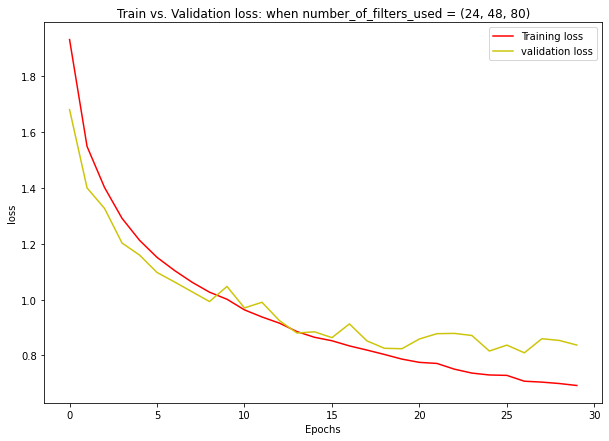

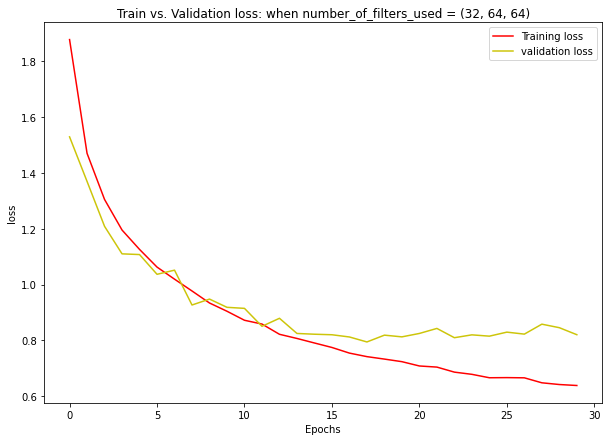

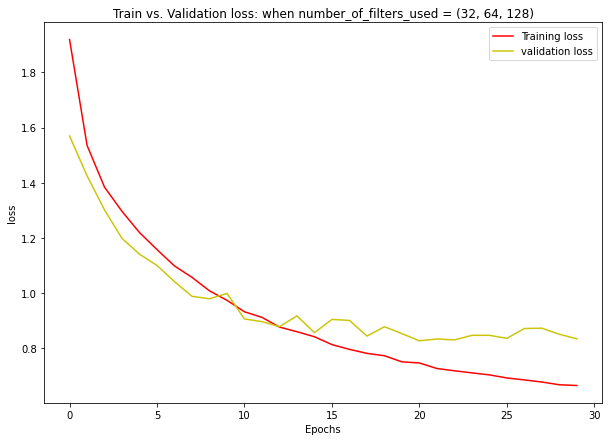

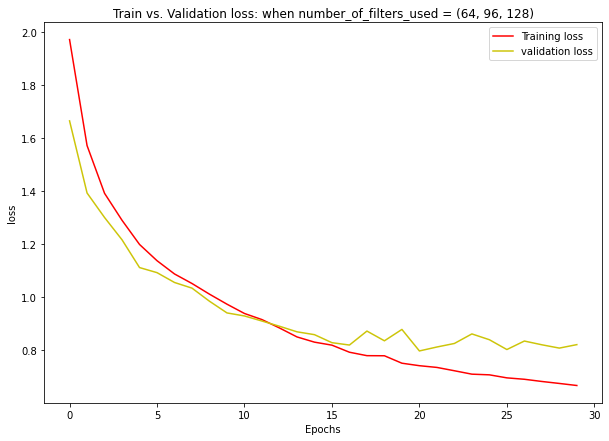

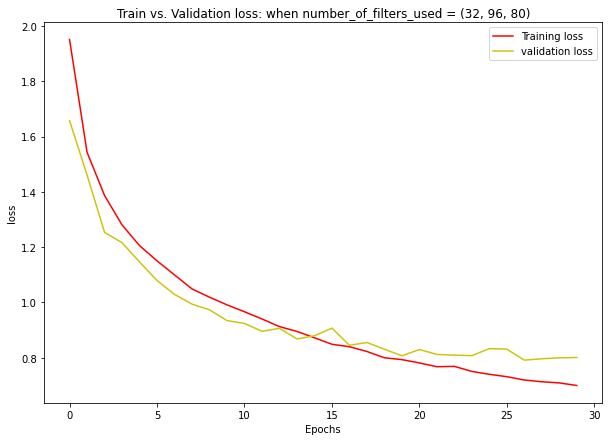

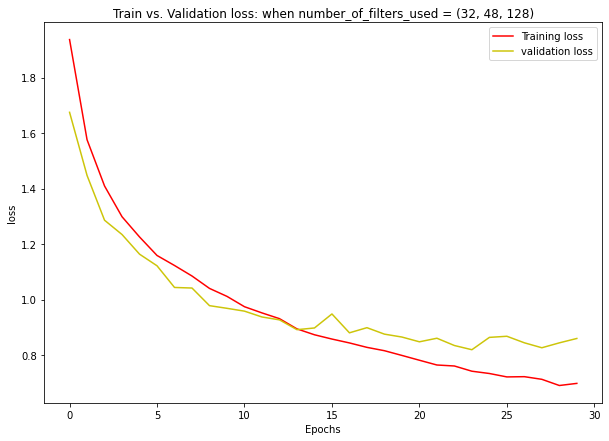

time: 1.2 s (started: 2022-05-29 11:39:18 +00:00)


In [ ]:
# a helper function used to prints the loss line charts for the different stride values used
generatePlot(history_D, 'number_of_filters_used')

<p>The plots show that training loss and validation loss are off by small margin becuase we have enabled dropout. We also see that validation loss is higher than training loss. Compared to other pairs of filters, (32, 64, 64) experiences less overfitting when there are used consecutively in  the Convolutional layers.</p>

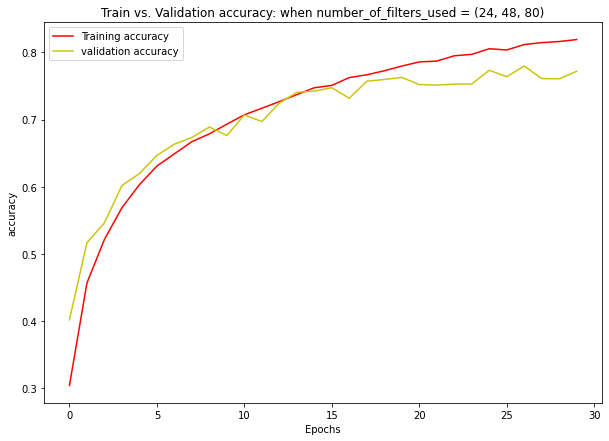

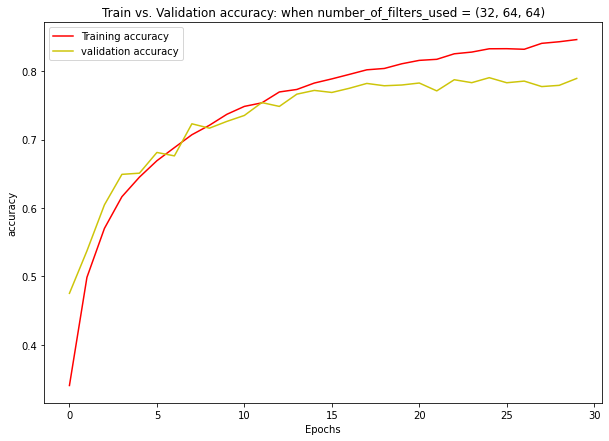

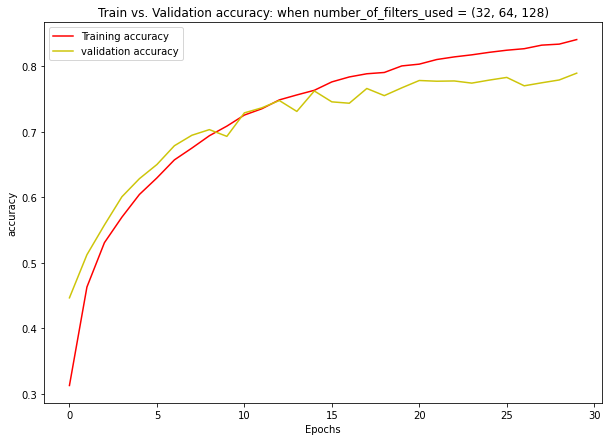

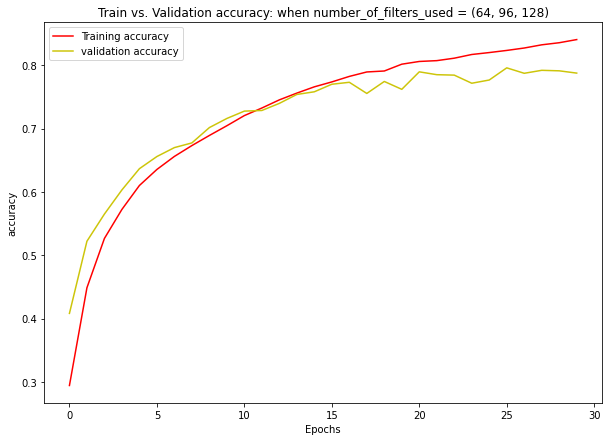

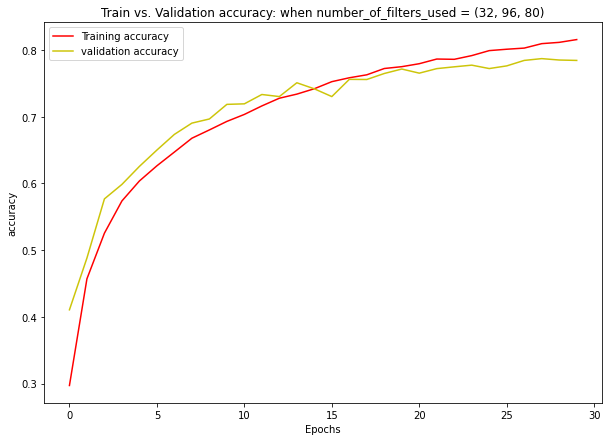

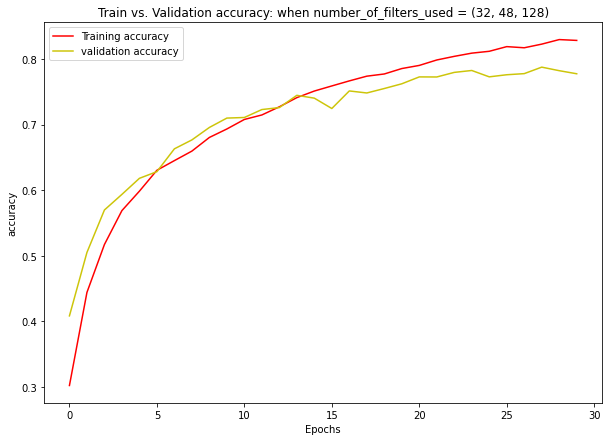

time: 1.21 s (started: 2022-05-29 11:39:19 +00:00)


In [ ]:
# a helper function used to prints the accuracy line charts for the different stride values used
generate_accuracy_Plot(history_D, 'number_of_filters_used')

Amongst all the pairs explored, (32, 64, 64) is the pair with highest validation accuracy and low validation loss.

In [ ]:
# helper function that derives and return the different data frames for validation
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'filter_pairs_used')

time: 3.46 ms (started: 2022-05-29 11:39:20 +00:00)


In [ ]:
val_loss_df

filter_pairs_used  val_loss
0      (24, 48, 80)  0.837126
1      (32, 64, 64)  0.820243
2     (32, 64, 128)  0.833314
3     (64, 96, 128)  0.821163
4      (32, 96, 80)  0.800278
5     (32, 48, 128)  0.859854

time: 8.15 ms (started: 2022-05-29 11:39:20 +00:00)


In [ ]:
val_accuracy_df

filter_pairs_used  val_accuracy_L
0      (24, 48, 80)          0.7719
1      (32, 64, 64)          0.7893
2     (32, 64, 128)          0.7892
3     (64, 96, 128)          0.7875
4      (32, 96, 80)          0.7845
5     (32, 48, 128)          0.7775

time: 6.61 ms (started: 2022-05-29 11:39:20 +00:00)


In [ ]:
# helper function that returns the data frame for the train loss and accuracy
train_loss_df, train_accuracy_df= deriveAccuracy_df(train_loss_L, train_accuracy_L, 'filter_pairs_used')

time: 1.79 ms (started: 2022-05-29 11:39:20 +00:00)


In [ ]:
train_loss_df

filter_pairs_used  train_loss
0      (24, 48, 80)    0.558230
1      (32, 64, 64)    0.502451
2     (32, 64, 128)    0.511553
3     (64, 96, 128)    0.543479
4      (32, 96, 80)    0.558839
5     (32, 48, 128)    0.579354

time: 6.33 ms (started: 2022-05-29 11:39:20 +00:00)


In [ ]:
train_accuracy_df

filter_pairs_used  train_accuracy
0      (24, 48, 80)        0.870675
1      (32, 64, 64)        0.900875
2     (32, 64, 128)        0.893850
3     (64, 96, 128)        0.885900
4      (32, 96, 80)        0.867000
5     (32, 48, 128)        0.874875

time: 8.03 ms (started: 2022-05-29 11:39:20 +00:00)


##### Removed a CNN layer from the middle layer

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
train_loss_L = []                             # list of train loss
train_accuracy_L = []                         # list of train accuracy
num_filters_L = [(24, 48, 80),(32, 64, 64), (32, 64, 128), (64, 96, 128), (32, 96, 80), (32, 48, 128)]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(num_filters_L)):
  print('Number of filter pairs being used: %s, %s, %s' %(str(num_filters_L[fact][0]), str(num_filters_L[fact][1]), str(num_filters_L[fact][2])))
  model = models.Sequential()
  # get the first indice of the tuple - num_filters_L[fact][0]
  model.add(layers.Conv2D(num_filters_L[fact][0], (3, 3), strides=(1,1) ,padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(num_filters_L[fact][0], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(num_filters_L[fact][1], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  
  # This Convolutional layer is removed from the network
  # model.add(layers.Conv2D(num_filters_L[fact][1], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(num_filters_L[fact][2], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(num_filters_L[fact][2], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  #last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((num_filters_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[num_filters_L[fact]] = history

  # compute the loss and accuracy
  val_loss, val_acc = model.evaluate(valid_images, valid_labels)
  train_loss, train_accuracy = model.evaluate(train_images, train_labels)

  # append the val_loss of the current execution to the list
  train_loss_L.append([num_filters_L[fact], train_loss])
  val_loss_L.append([num_filters_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  train_accuracy_L.append([num_filters_L[fact], train_accuracy])
  val_accuracy_L.append([num_filters_L[fact], val_acc])

Number of filter pairs being used: 24, 48, 80
Epoch 1/30
400/400 [==============================] - 3s 6ms/step - loss: 1.8896 - accuracy: 0.3205 - val_loss: 1.5979 - val_accuracy: 0.4278
Epoch 2/30
400/400 [==============================] - 2s 5ms/step - loss: 1.5342 - accuracy: 0.4645 - val_loss: 1.4166 - val_accuracy: 0.5181
Epoch 3/30
400/400 [==============================] - 2s 5ms/step - loss: 1.3689 - accuracy: 0.5383 - val_loss: 1.2587 - val_accuracy: 0.5771
Epoch 4/30
400/400 [==============================] - 2s 5ms/step - loss: 1.2560 - accuracy: 0.5877 - val_loss: 1.2146 - val_accuracy: 0.6013
Epoch 5/30
400/400 [==============================] - 2s 5ms/step - loss: 1.1714 - accuracy: 0.6226 - val_loss: 1.0841 - val_accuracy: 0.6527
Epoch 6/30
400/400 [==============================] - 2s 5ms/step - loss: 1.0979 - accuracy: 0.6513 - val_loss: 1.0511 - val_accuracy: 0.6644
Epoch 7/30
400/400 [==============================] - 2s 5ms/step - loss: 1.0456 - accuracy: 0.6736 - 

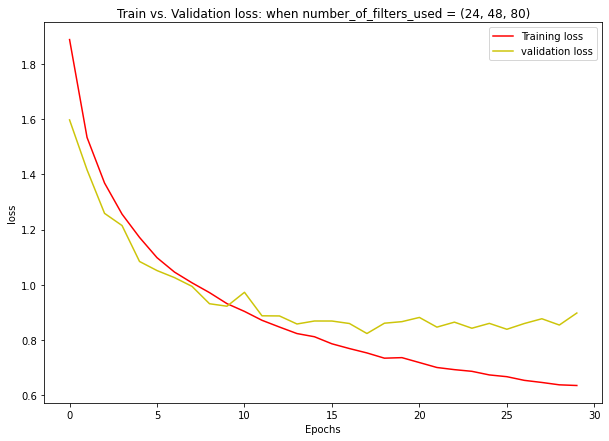

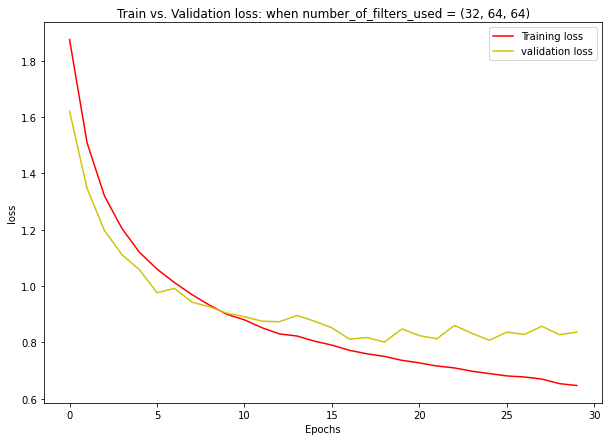

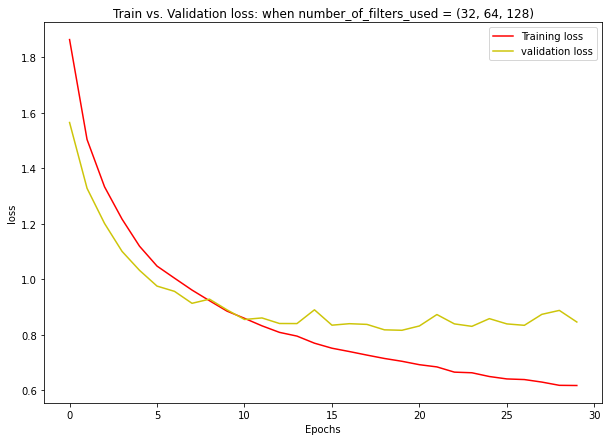

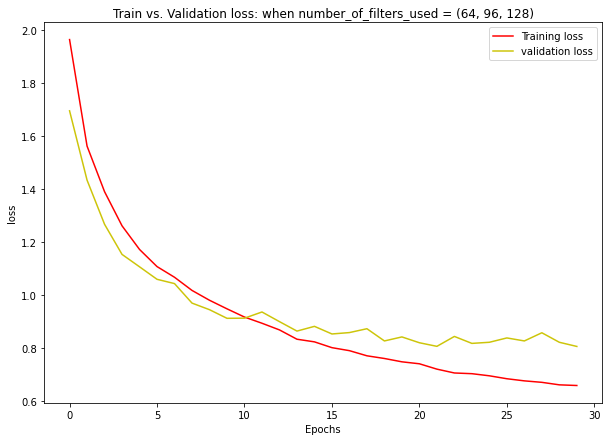

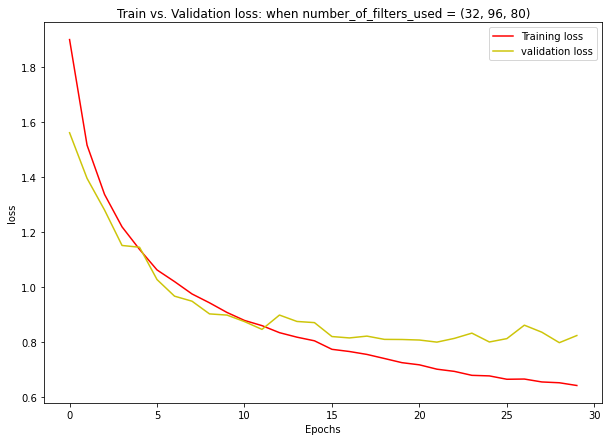

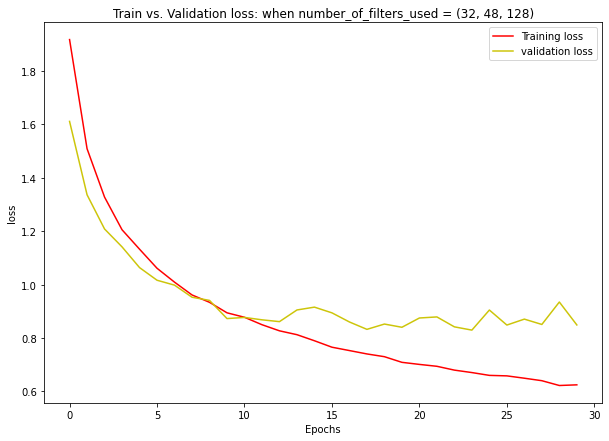

time: 1.18 s (started: 2022-05-29 11:46:34 +00:00)


In [ ]:
# a helper function used to prints the loss line charts for the different stride values used
generatePlot(history_D, 'number_of_filters_used')

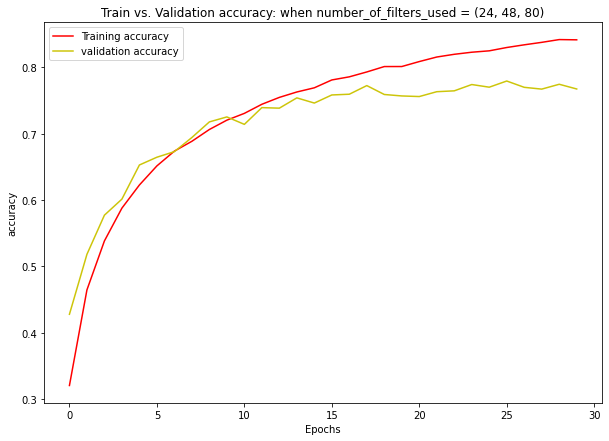

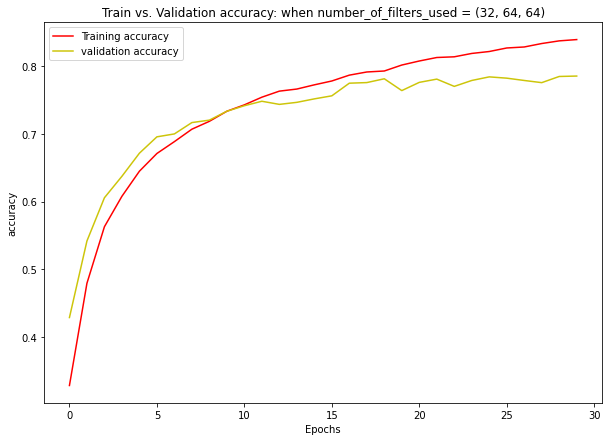

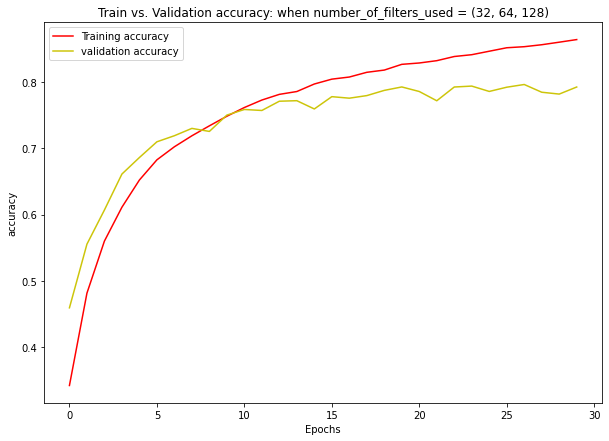

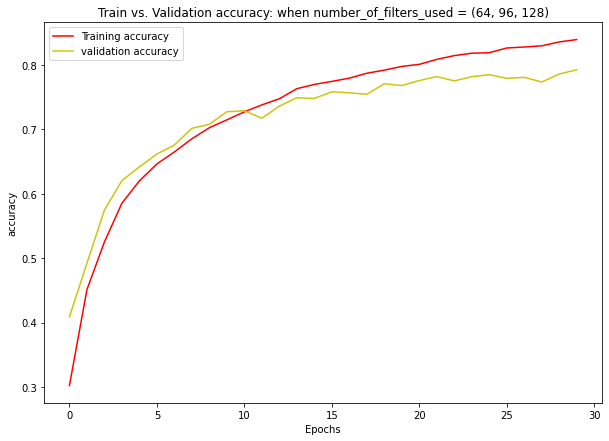

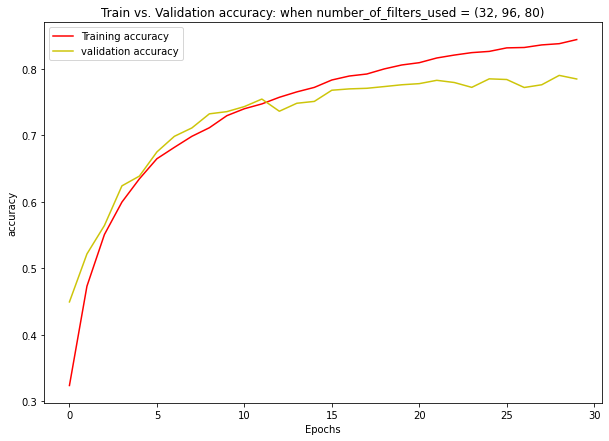

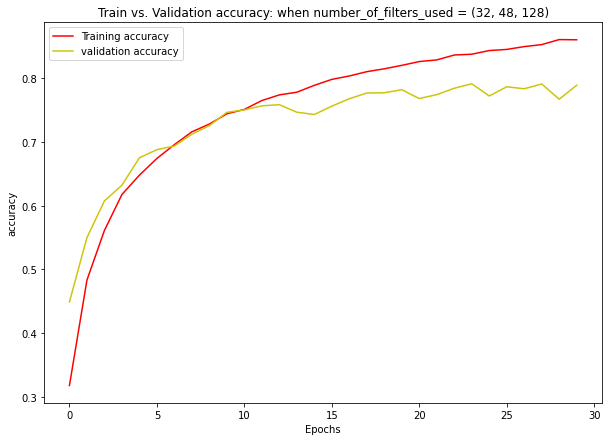

time: 1.21 s (started: 2022-05-29 11:46:35 +00:00)


In [ ]:
# a helper function used to prints the accuracy line charts for the different stride values used
generate_accuracy_Plot(history_D, 'number_of_filters_used')

<p>In this experiment we observer that pair (64, 96, 128) has the highest validation accuracy and low validation loss</p>

In [ ]:
# helper function that derives and return the different data frames for validation
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'filter_pairs_used')

time: 2.58 ms (started: 2022-05-29 11:46:36 +00:00)


In [ ]:
val_loss_df

filter_pairs_used  val_loss
0      (24, 48, 80)  0.897032
1      (32, 64, 64)  0.835785
2     (32, 64, 128)  0.846296
3     (64, 96, 128)  0.806088
4      (32, 96, 80)  0.824136
5     (32, 48, 128)  0.848728

time: 9.18 ms (started: 2022-05-29 11:46:36 +00:00)


In [ ]:
val_accuracy_df

filter_pairs_used  val_accuracy_L
0      (24, 48, 80)          0.7672
1      (32, 64, 64)          0.7848
2     (32, 64, 128)          0.7930
3     (64, 96, 128)          0.7927
4      (32, 96, 80)          0.7846
5     (32, 48, 128)          0.7890

time: 7.13 ms (started: 2022-05-29 11:46:36 +00:00)


In [ ]:
# helper function that returns the data frame for the train loss and accuracy
train_loss_df, train_accuracy_df= deriveAccuracy_df(train_loss_L, train_accuracy_L, 'filter_pairs_used')

time: 1.68 ms (started: 2022-05-29 11:46:36 +00:00)


In [ ]:
train_loss_df

filter_pairs_used  train_loss
0      (24, 48, 80)    0.529248
1      (32, 64, 64)    0.522195
2     (32, 64, 128)    0.474677
3     (64, 96, 128)    0.492062
4      (32, 96, 80)    0.501505
5     (32, 48, 128)    0.483298

time: 7.06 ms (started: 2022-05-29 11:46:36 +00:00)


In [ ]:
train_accuracy_df

filter_pairs_used  train_accuracy
0      (24, 48, 80)        0.884475
1      (32, 64, 64)        0.890225
2     (32, 64, 128)        0.923425
3     (64, 96, 128)        0.901875
4      (32, 96, 80)        0.899350
5     (32, 48, 128)        0.918000

time: 6.89 ms (started: 2022-05-29 11:46:36 +00:00)


##### Removing one Convolutional layer from the last CNN

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
train_loss_L = []                             # list of train loss
train_accuracy_L = []                         # list of train accuracy
num_filters_L = [(24, 48, 80),(32, 64, 64), (32, 64, 128), (64, 96, 128), (32, 96, 80), (32, 48, 128)]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(num_filters_L)):
  print('Number of filter pairs being used: %s, %s, %s' %(str(num_filters_L[fact][0]), str(num_filters_L[fact][1]), str(num_filters_L[fact][2])))
  model = models.Sequential()
  # get the first indice of the tuple - num_filters_L[fact][0]
  model.add(layers.Conv2D(num_filters_L[fact][0], (3, 3), strides=(1,1) ,padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(num_filters_L[fact][0], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(num_filters_L[fact][1], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(num_filters_L[fact][2], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  #last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((num_filters_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[num_filters_L[fact]] = history

  # compute the loss and accuracy
  val_loss, val_acc = model.evaluate(valid_images, valid_labels)
  train_loss, train_accuracy = model.evaluate(train_images, train_labels)

  # append the val_loss of the current execution to the list
  train_loss_L.append([num_filters_L[fact], train_loss])
  val_loss_L.append([num_filters_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  train_accuracy_L.append([num_filters_L[fact], train_accuracy])
  val_accuracy_L.append([num_filters_L[fact], val_acc])

Number of filter pairs being used: 24, 48, 80
Epoch 1/30
400/400 [==============================] - 3s 5ms/step - loss: 1.7981 - accuracy: 0.3668 - val_loss: 1.5142 - val_accuracy: 0.4834
Epoch 2/30
400/400 [==============================] - 2s 5ms/step - loss: 1.4221 - accuracy: 0.5146 - val_loss: 1.2825 - val_accuracy: 0.5689
Epoch 3/30
400/400 [==============================] - 2s 5ms/step - loss: 1.2630 - accuracy: 0.5854 - val_loss: 1.1563 - val_accuracy: 0.6285
Epoch 4/30
400/400 [==============================] - 2s 5ms/step - loss: 1.1464 - accuracy: 0.6301 - val_loss: 1.1053 - val_accuracy: 0.6542
Epoch 5/30
400/400 [==============================] - 2s 5ms/step - loss: 1.0691 - accuracy: 0.6611 - val_loss: 0.9896 - val_accuracy: 0.6891
Epoch 6/30
400/400 [==============================] - 2s 5ms/step - loss: 1.0134 - accuracy: 0.6814 - val_loss: 0.9542 - val_accuracy: 0.7016
Epoch 7/30
400/400 [==============================] - 2s 5ms/step - loss: 0.9757 - accuracy: 0.6965 - 

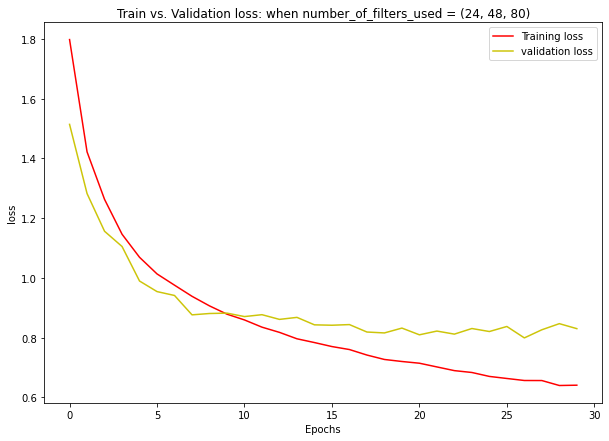

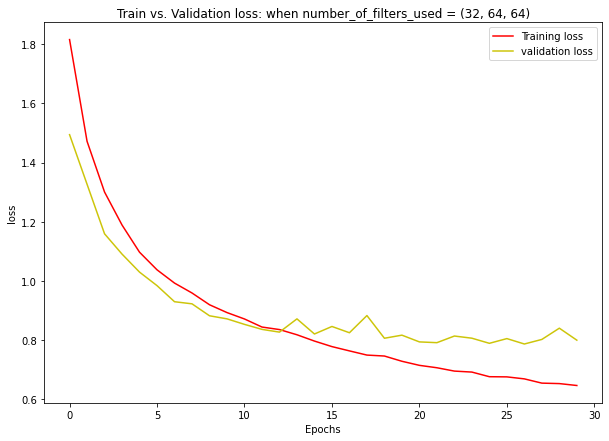

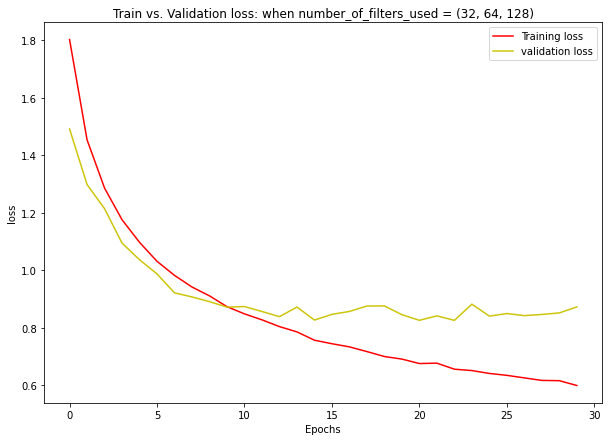

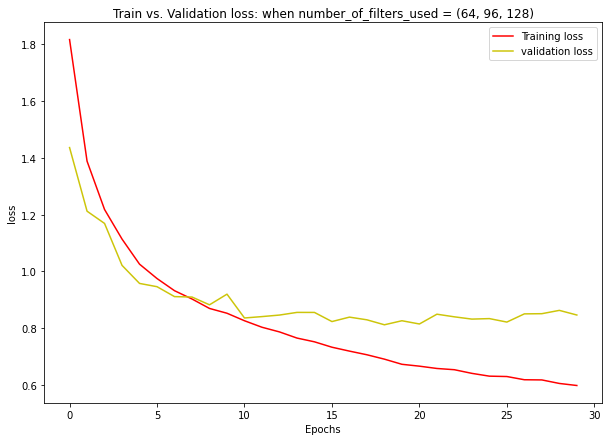

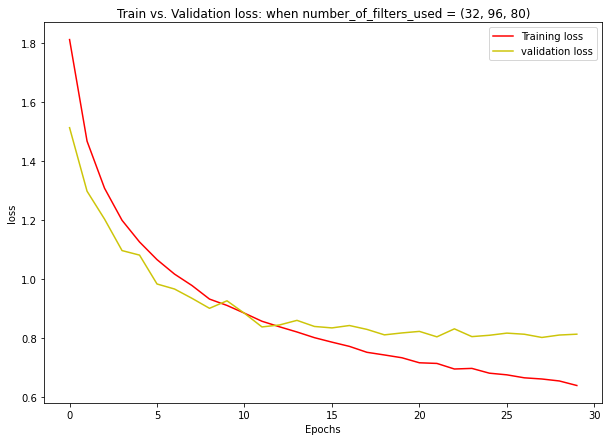

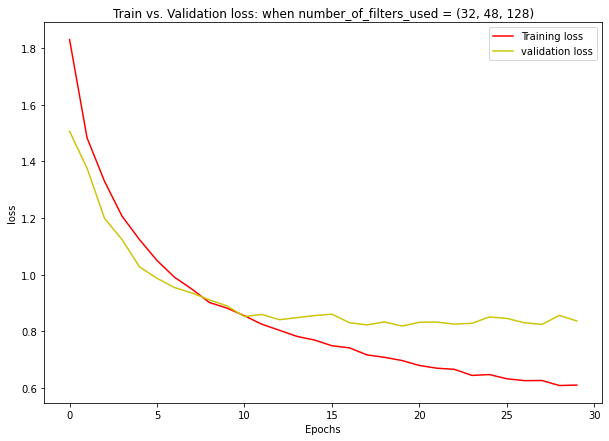

time: 1.76 s (started: 2022-05-29 11:53:24 +00:00)


In [ ]:
# a helper function used to prints the loss line charts for the different stride values used
generatePlot(history_D, 'number_of_filters_used')

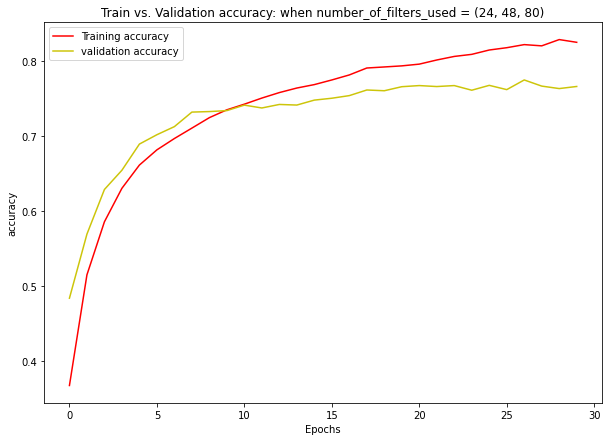

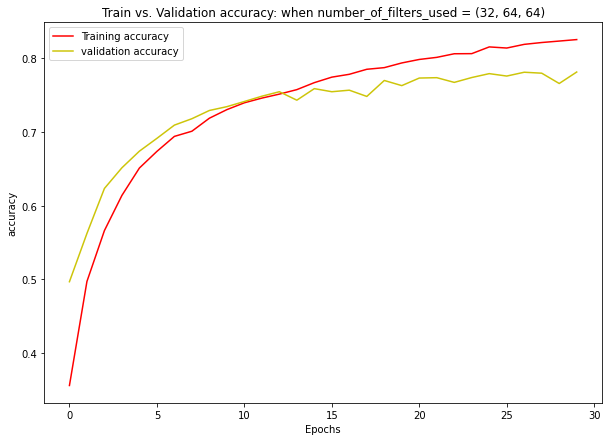

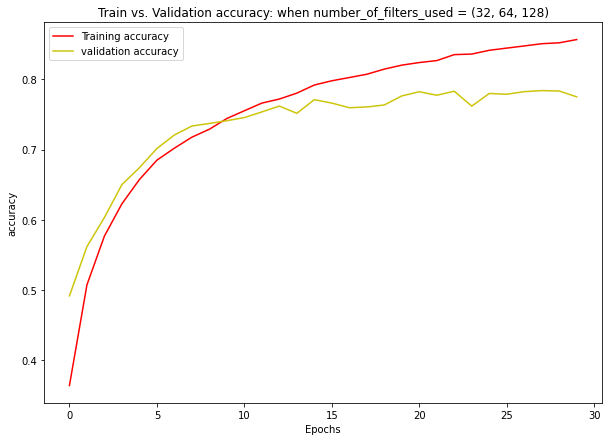

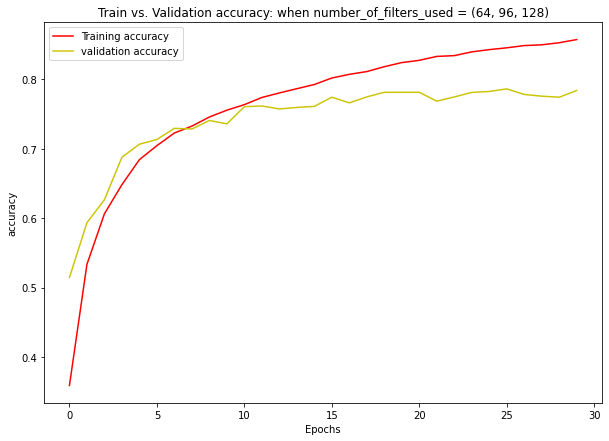

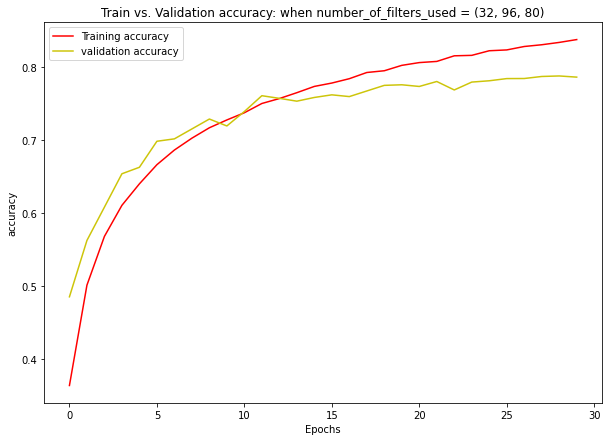

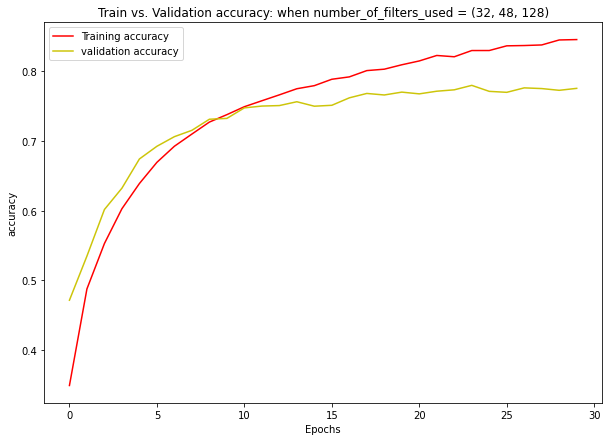

time: 1.3 s (started: 2022-05-29 11:53:26 +00:00)


In [ ]:
# a helper function used to prints the accuracy line charts for the different stride values used
generate_accuracy_Plot(history_D, 'number_of_filters_used')

<p>In this experiment we observer that pair (64, 96, 128) has the highest validation accuracy and low validation loss</p>

In [ ]:
# helper function that derives and return the different data frames for validation
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'filter_pairs_used')

time: 2.96 ms (started: 2022-05-29 11:53:27 +00:00)


In [ ]:
val_loss_df

filter_pairs_used  val_loss
0      (24, 48, 80)  0.830114
1      (32, 64, 64)  0.799095
2     (32, 64, 128)  0.872185
3     (64, 96, 128)  0.846632
4      (32, 96, 80)  0.812222
5     (32, 48, 128)  0.836155

time: 7.29 ms (started: 2022-05-29 11:53:27 +00:00)


In [ ]:
val_accuracy_df

filter_pairs_used  val_accuracy_L
0      (24, 48, 80)          0.7660
1      (32, 64, 64)          0.7816
2     (32, 64, 128)          0.7751
3     (64, 96, 128)          0.7839
4      (32, 96, 80)          0.7862
5     (32, 48, 128)          0.7756

time: 7.57 ms (started: 2022-05-29 11:53:27 +00:00)


In [ ]:
# helper function that returns the data frame for the train loss and accuracy
train_loss_df, train_accuracy_df= deriveAccuracy_df(train_loss_L, train_accuracy_L, 'filter_pairs_used')

time: 1.98 ms (started: 2022-05-29 11:53:27 +00:00)


In [ ]:
train_loss_df

filter_pairs_used  train_loss
0      (24, 48, 80)    0.468251
1      (32, 64, 64)    0.469916
2     (32, 64, 128)    0.471672
3     (64, 96, 128)    0.422730
4      (32, 96, 80)    0.476162
5     (32, 48, 128)    0.433782

time: 7.96 ms (started: 2022-05-29 11:53:27 +00:00)


In [ ]:
train_accuracy_df

filter_pairs_used  train_accuracy
0      (24, 48, 80)        0.897225
1      (32, 64, 64)        0.896800
2     (32, 64, 128)        0.912950
3     (64, 96, 128)        0.928400
4      (32, 96, 80)        0.910650
5     (32, 48, 128)        0.918675

time: 7.73 ms (started: 2022-05-29 11:53:27 +00:00)


<ul>We peformed three experiments namely:
<li>Added Convolution layers on the existing CNN layers in the network where we explored the different number of filters.</li>
<li>Removed a Convolution layer from the middle layer explored the different number of filters optimal for the network.</li>
<li>Removed one Convolution layer from the last Convolutional layer then explored the different number of filters optimal for the network.<li>
</ul>

<p>Through the different experiments carried out, we discovered that the set (32, 64, 64) had the highest validation accuracy and lowest validation loss amongest all pairs we used. 32 was applied to the first set of Convolution layer, 64 was applied to the second (in the middle) and third set of Convolution layer.<p>

##### Removing the middle Convolutional layer from the network. 

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
train_loss_L = []                             # list of train loss
train_accuracy_L = []                         # list of train accuracy
num_filters_L = [(24, 48, 80),(32, 64, 64), (32, 64, 128), (64, 96, 128), (32, 96, 80), (32, 48, 128)]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(num_filters_L)):
  print('Number of filter pairs being used: %s, %s, %s' %(str(num_filters_L[fact][0]), str(num_filters_L[fact][1]), str(num_filters_L[fact][2])))
  model = models.Sequential()
  # get the first indice of the tuple - num_filters_L[fact][0]
  model.add(layers.Conv2D(num_filters_L[fact][0], (3, 3), strides=(1,1) ,padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(num_filters_L[fact][0], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # get the second indice of the tuple - num_filters_L[fact][1]
  #model.add(layers.Conv2D(num_filters_L[fact][1], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  #model.add(layers.MaxPooling2D((2, 2)))

  # get the second indice of the tuple - num_filters_L[fact][1]
  model.add(layers.Conv2D(num_filters_L[fact][2], (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  #last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((num_filters_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[num_filters_L[fact]] = history

  # compute the loss and accuracy
  val_loss, val_acc = model.evaluate(valid_images, valid_labels)
  train_loss, train_accuracy = model.evaluate(train_images, train_labels)

  # append the val_loss of the current execution to the list
  train_loss_L.append([num_filters_L[fact], train_loss])
  val_loss_L.append([num_filters_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  train_accuracy_L.append([num_filters_L[fact], train_accuracy])
  val_accuracy_L.append([num_filters_L[fact], val_acc])

Number of filter pairs being used: 24, 48, 80
Epoch 1/30
400/400 [==============================] - 3s 5ms/step - loss: 1.7623 - accuracy: 0.3686 - val_loss: 1.4293 - val_accuracy: 0.5176
Epoch 2/30
400/400 [==============================] - 2s 4ms/step - loss: 1.4113 - accuracy: 0.5077 - val_loss: 1.2539 - val_accuracy: 0.5740
Epoch 3/30
400/400 [==============================] - 2s 4ms/step - loss: 1.2493 - accuracy: 0.5759 - val_loss: 1.1288 - val_accuracy: 0.6217
Epoch 4/30
400/400 [==============================] - 2s 4ms/step - loss: 1.1502 - accuracy: 0.6142 - val_loss: 1.0754 - val_accuracy: 0.6404
Epoch 5/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0939 - accuracy: 0.6363 - val_loss: 1.0337 - val_accuracy: 0.6567
Epoch 6/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0448 - accuracy: 0.6532 - val_loss: 0.9846 - val_accuracy: 0.6820
Epoch 7/30
400/400 [==============================] - 2s 4ms/step - loss: 1.0052 - accuracy: 0.6704 - 

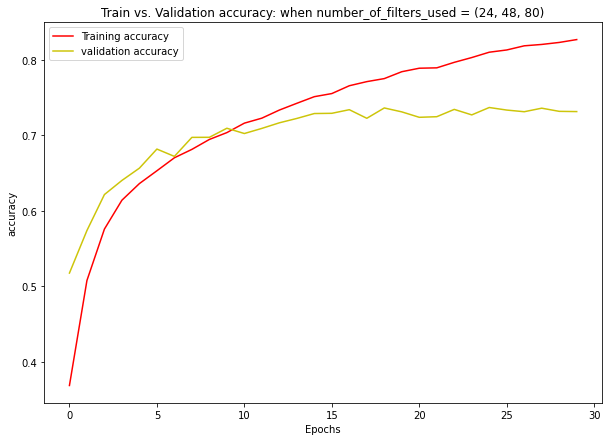

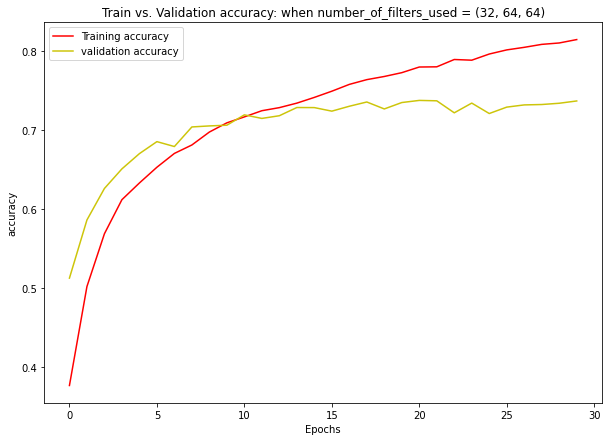

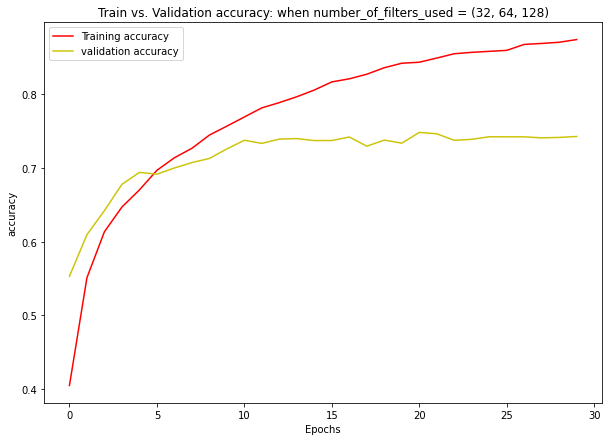

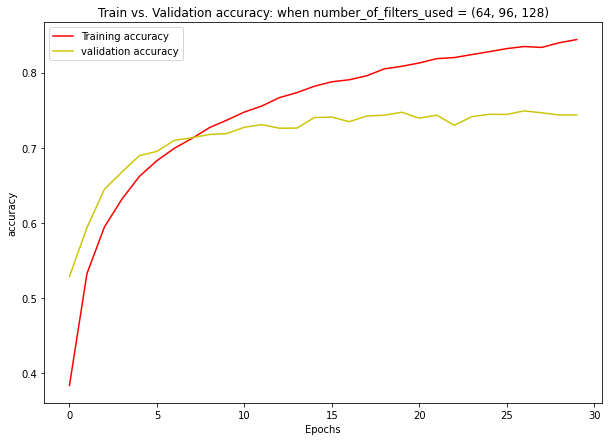

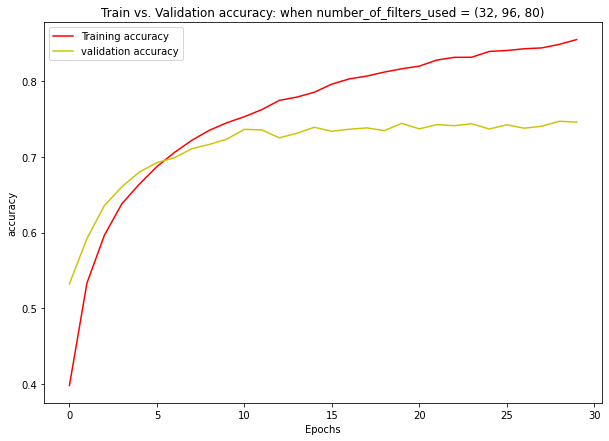

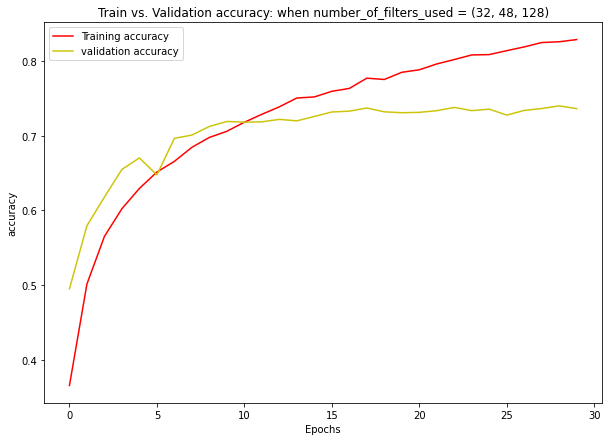

time: 1.71 s (started: 2022-05-29 11:59:45 +00:00)


In [ ]:
# a helper function used to prints the accuracy line charts for the different stride values used
generate_accuracy_Plot(history_D, 'number_of_filters_used')

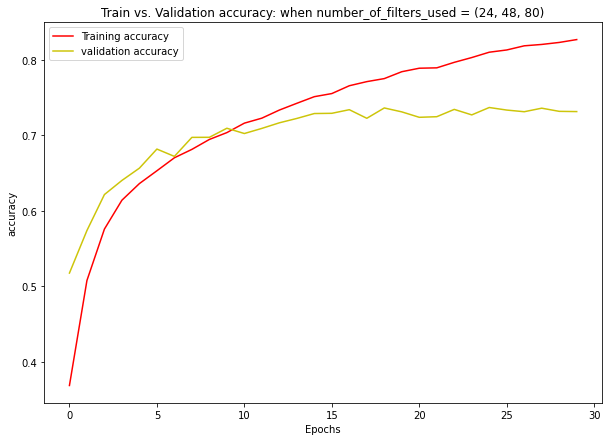

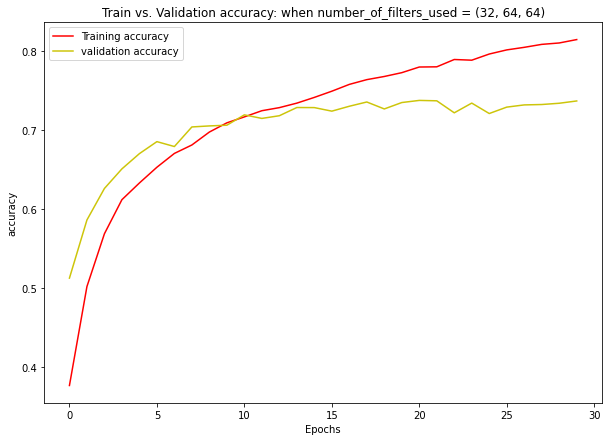

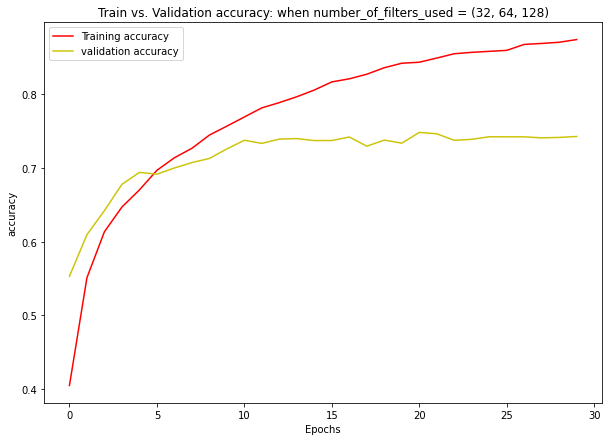

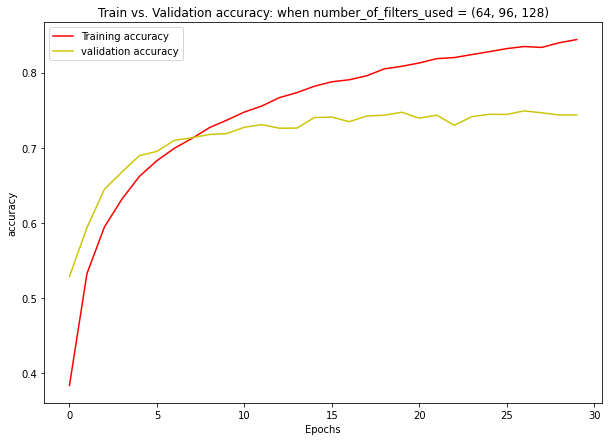

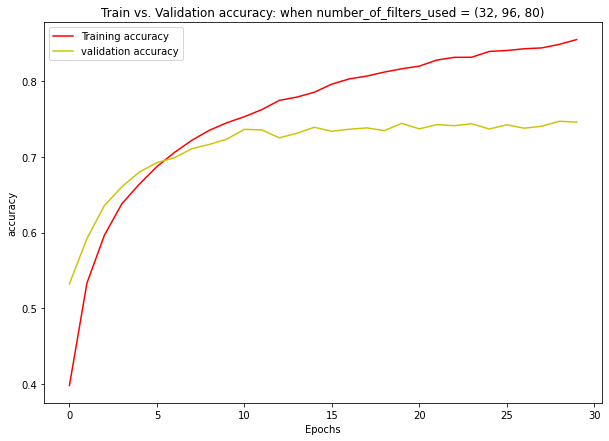

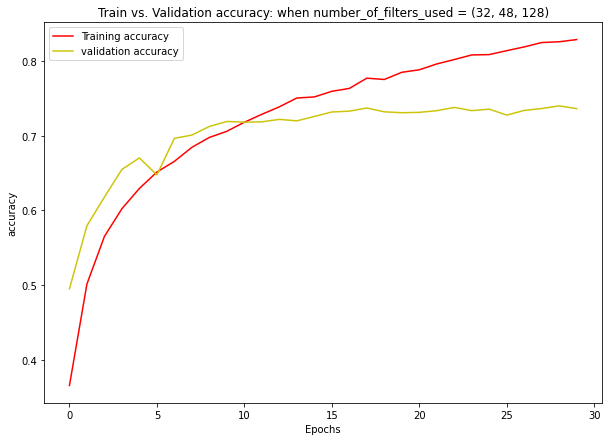

time: 1.24 s (started: 2022-05-29 11:59:47 +00:00)


In [ ]:
# a helper function used to prints the accuracy line charts for the different stride values used
generate_accuracy_Plot(history_D, 'number_of_filters_used')

we see that the filter pairs (32, 64, 64) are the best filters here because they experience less overfitting.

In [ ]:
# helper function that derives and return the different data frames for validation
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'filter_pairs_used')

time: 2.54 ms (started: 2022-05-29 11:59:48 +00:00)


In [ ]:
val_loss_df

filter_pairs_used  val_loss
0      (24, 48, 80)  0.923194
1      (32, 64, 64)  0.884830
2     (32, 64, 128)  1.027870
3     (64, 96, 128)  0.930318
4      (32, 96, 80)  0.922270
5     (32, 48, 128)  0.940223

time: 8.16 ms (started: 2022-05-29 11:59:48 +00:00)


In [ ]:
val_accuracy_df

filter_pairs_used  val_accuracy_L
0      (24, 48, 80)          0.7317
1      (32, 64, 64)          0.7367
2     (32, 64, 128)          0.7430
3     (64, 96, 128)          0.7435
4      (32, 96, 80)          0.7457
5     (32, 48, 128)          0.7363

time: 8.79 ms (started: 2022-05-29 11:59:48 +00:00)


#### Let's create a network with the best model parameters including the Convolution layers added.

In [ ]:
# a helper function that returns model's history after compiling the network, train and fit the model with the data
history_withMoreLayers = buildbestModel(100, 0.001, 0.001, 0.2, 'Added more Convolution layers')

Debugging if statement: Added more Convolution layers
Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_363 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_364 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_235 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_365 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_366 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_236 (MaxPooli  (None, 8, 8, 64)         0        

In [ ]:
print('The validation accuracy is %.4f.' %(max(history_withMoreLayers.history['val_accuracy'])))
print('The validation loss is %.4f.' %(min(history_withMoreLayers.history['val_loss'])))

The validation accuracy is 0.7803.
The validation loss is 0.8304.
time: 1.47 ms (started: 2022-05-29 12:00:59 +00:00)


##### Save the model to the drive and reload it

In [ ]:
# helper function that saves the current model to the file system.
saveModel('CNN_image_classification_WithMoreLayers.model')

INFO:tensorflow:Assets written to: CNN_image_classification_WithMoreLayers.model/assets
time: 2.22 s (started: 2022-05-29 12:00:59 +00:00)


##### Make the predictions and write the results to a csv file

In [ ]:
# let's make the required predictions
predictions = model.predict([test_images])

time: 767 ms (started: 2022-05-29 12:01:01 +00:00)


In [ ]:
# let's convert a numpy array into a list
predictions_L = predictions.tolist()

# helper function that writes predictions Results to a csv file
writeResultsToCsv(predictions_L)

time: 168 ms (started: 2022-05-29 12:01:02 +00:00)


#### Number of units to be used in the dense layer

<p>Since we increased the number of Convolutional layers, we need to determine the optimal number of units to be used in the dense layer once again.</p>

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
train_loss_L = []                             # list of train loss
train_accuracy_L = []                         # list of train accuracy
dense_units_L = [16, 32, 64, 128, 256, 512, 1024, 2048]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(dense_units_L)):
  print('Dense units being used are : %s' %(str(dense_units_L[fact])))
  model = models.Sequential()
  
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(128, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(dense_units_L[fact], activation='relu'))

  #last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((dense_units_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[dense_units_L[fact]] = history

  # compute the loss and accuracy
  val_loss, val_acc = model.evaluate(valid_images, valid_labels)
  train_loss, train_accuracy = model.evaluate(train_images, train_labels)

  # append the val_loss of the current execution to the list
  train_loss_L.append([dense_units_L[fact], train_loss])
  val_loss_L.append([dense_units_L[fact], val_loss])

  # append the validation accuracy of the current execution to the list 
  train_accuracy_L.append([dense_units_L[fact], train_accuracy])
  val_accuracy_L.append([dense_units_L[fact], val_acc])

Dense units being used are : 16
Epoch 1/30
400/400 [==============================] - 3s 7ms/step - loss: 2.1515 - accuracy: 0.2129 - val_loss: 1.9355 - val_accuracy: 0.3135
Epoch 2/30
400/400 [==============================] - 2s 6ms/step - loss: 1.8609 - accuracy: 0.3153 - val_loss: 1.7090 - val_accuracy: 0.4086
Epoch 3/30
400/400 [==============================] - 2s 6ms/step - loss: 1.7271 - accuracy: 0.3731 - val_loss: 1.5963 - val_accuracy: 0.4378
Epoch 4/30
400/400 [==============================] - 2s 6ms/step - loss: 1.6225 - accuracy: 0.4094 - val_loss: 1.4766 - val_accuracy: 0.4901
Epoch 5/30
400/400 [==============================] - 2s 6ms/step - loss: 1.5428 - accuracy: 0.4459 - val_loss: 1.3975 - val_accuracy: 0.5197
Epoch 6/30
400/400 [==============================] - 2s 6ms/step - loss: 1.4718 - accuracy: 0.4804 - val_loss: 1.3216 - val_accuracy: 0.5550
Epoch 7/30
400/400 [==============================] - 2s 6ms/step - loss: 1.4167 - accuracy: 0.5056 - val_loss: 1.23

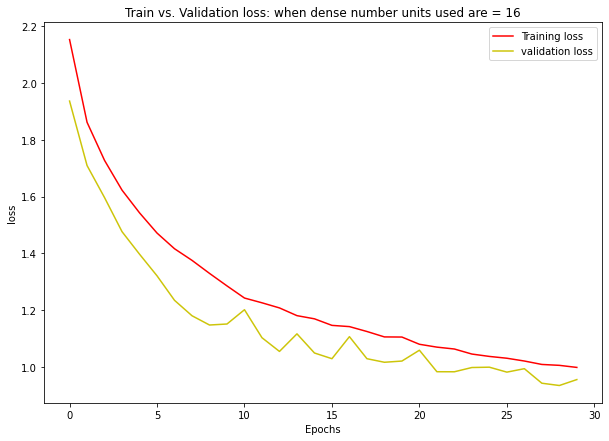

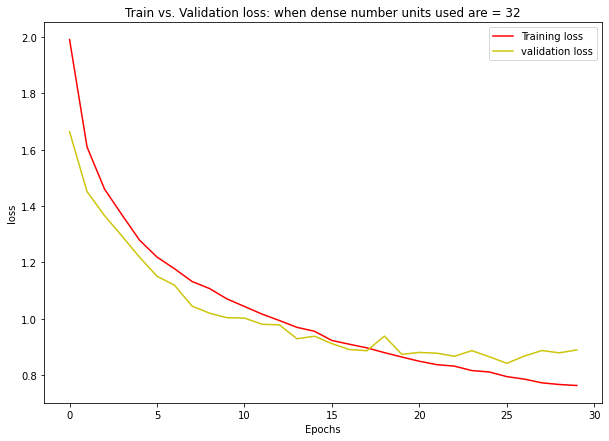

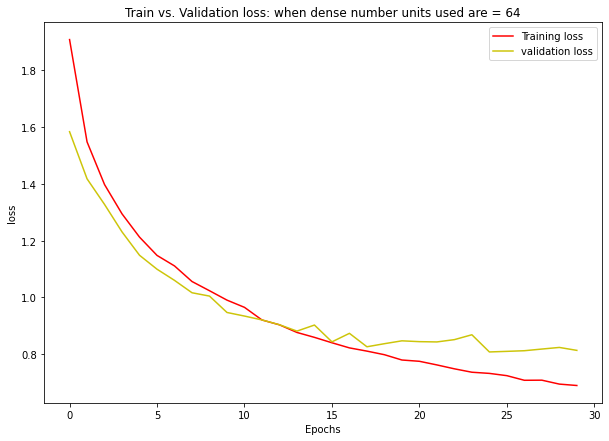

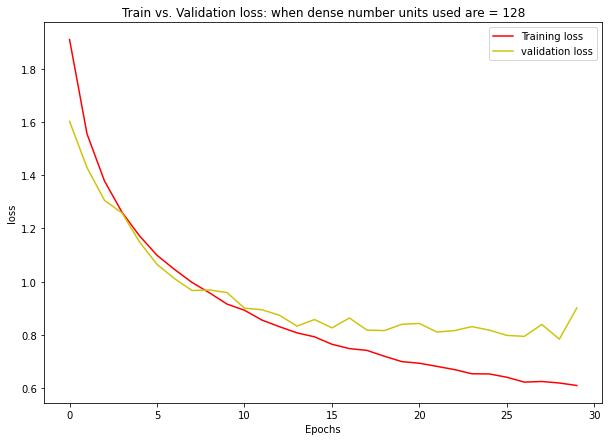

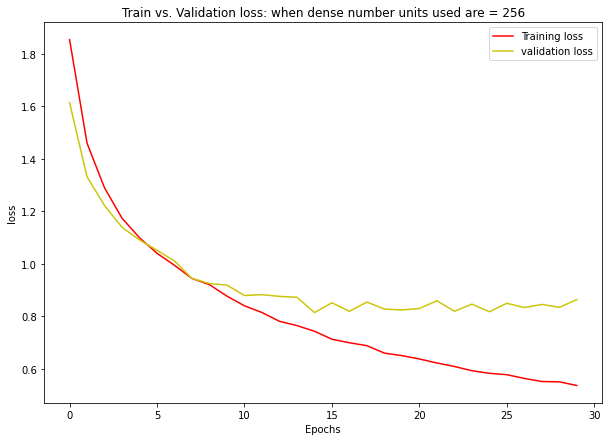

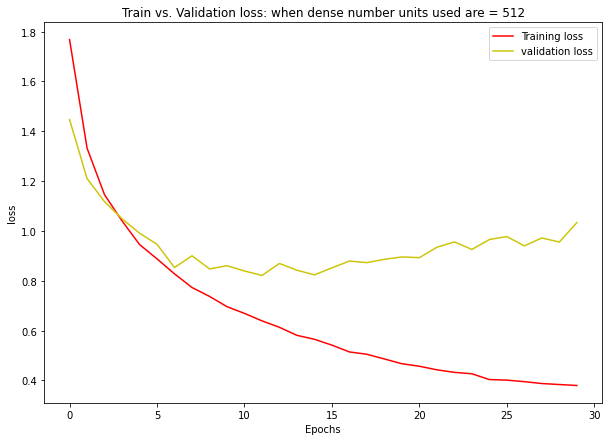

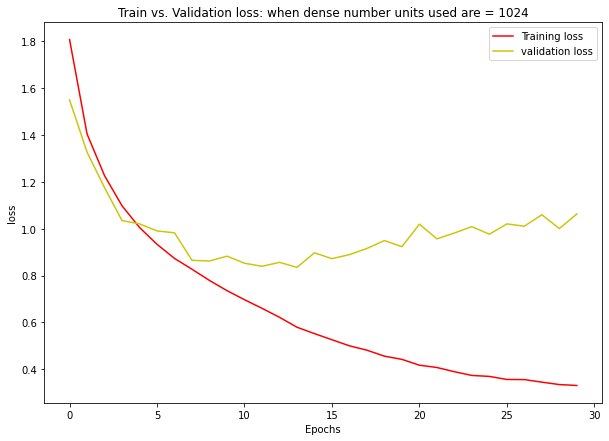

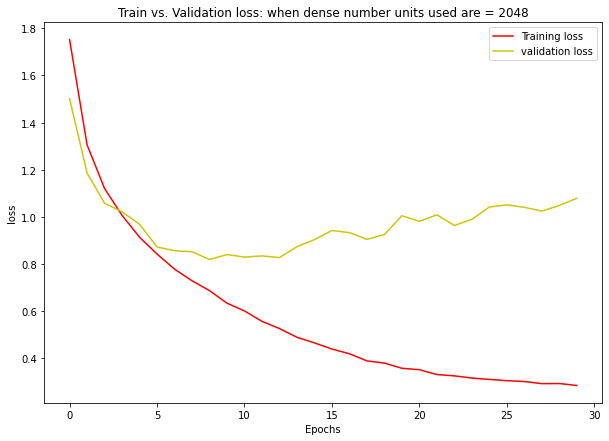

time: 1.58 s (started: 2022-05-29 12:11:22 +00:00)


In [ ]:
# a helper function used to prints the loss line charts for the different stride values used
generatePlot(history_D, 'dense number units used are')

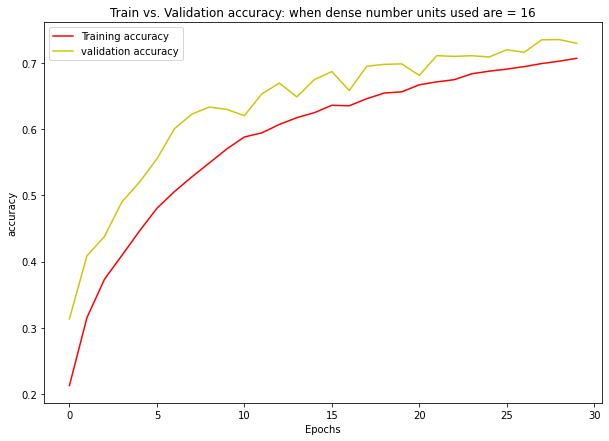

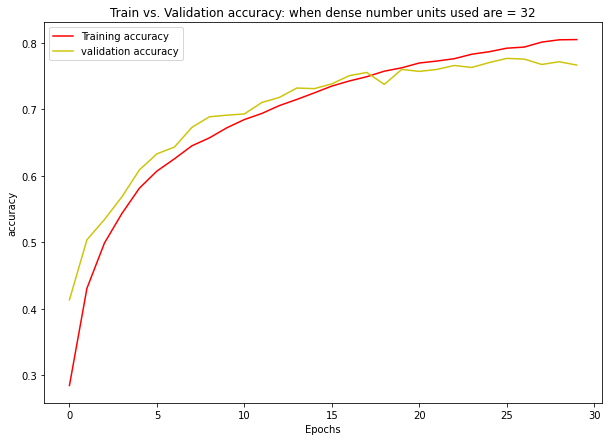

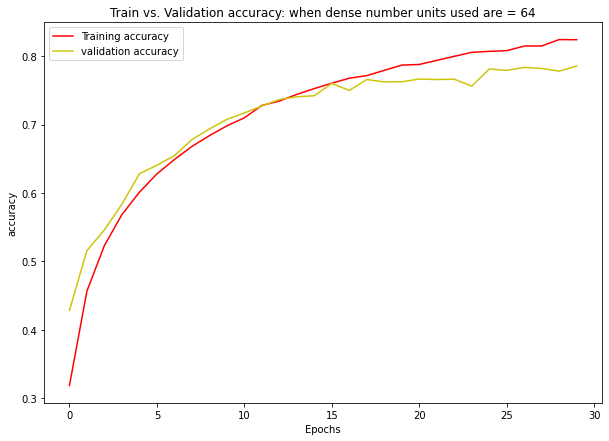

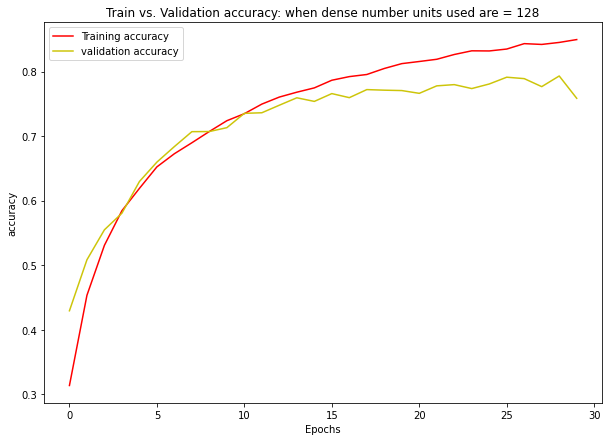

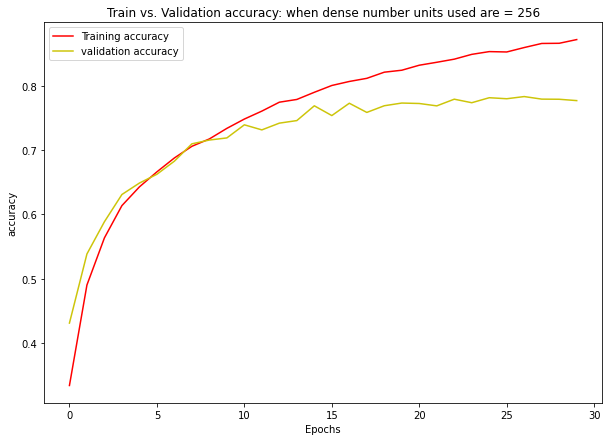

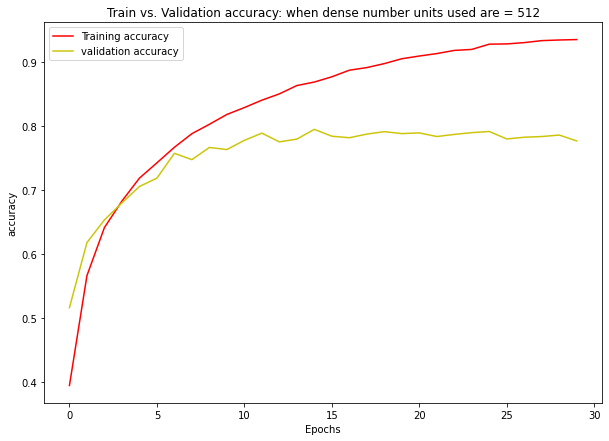

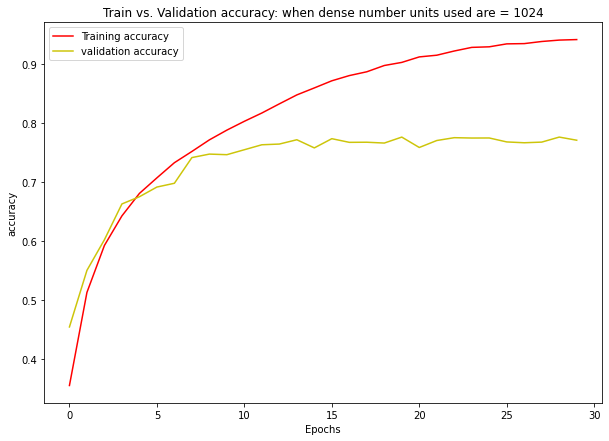

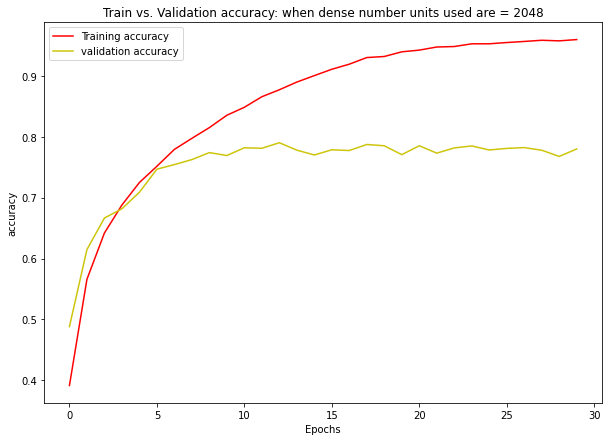

time: 1.59 s (started: 2022-05-29 12:11:24 +00:00)


In [ ]:
# a helper function used to prints the accuracy line charts for the different stride values used
generate_accuracy_Plot(history_D, 'dense number units used are')

<p>When we compare the dense units used: 32, 64 and 128, 128 has a high validation accuracy but with alot of overfitting. 64 which is optimal has the lowest validation loss and it experiences less overfitting so we shall continue using 64 as the number of dense units. </p>

In [ ]:
# helper function that derives and return the different data frames for validation
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'number_of_units_used')


time: 2.82 ms (started: 2022-05-29 12:11:25 +00:00)


In [ ]:
val_loss_df

number_of_units_used  val_loss
0                    16  0.957046
1                    32  0.889755
2                    64  0.814017
3                   128  0.901182
4                   256  0.863408
5                   512  1.033386
6                  1024  1.062909
7                  2048  1.079305

time: 6.31 ms (started: 2022-05-29 12:11:25 +00:00)


In [ ]:
val_accuracy_df

number_of_units_used  val_accuracy_L
0                    16          0.7295
1                    32          0.7663
2                    64          0.7856
3                   128          0.7585
4                   256          0.7773
5                   512          0.7771
6                  1024          0.7713
7                  2048          0.7798

time: 6.62 ms (started: 2022-05-29 12:11:25 +00:00)


In [ ]:
# helper function that returns the data frame for the train loss and accuracy
train_loss_df, train_accuracy_df= deriveAccuracy_df(train_loss_L, train_accuracy_L, 'number_of_units_used')

time: 1.46 ms (started: 2022-05-29 12:11:25 +00:00)


In [ ]:
train_loss_df

number_of_units_used  train_loss
0                    16    0.780717
1                    32    0.642090
2                    64    0.538692
3                   128    0.566299
4                   256    0.413920
5                   512    0.292357
6                  1024    0.226020
7                  2048    0.209748

time: 4.62 ms (started: 2022-05-29 12:11:25 +00:00)


In [ ]:
train_accuracy_df

number_of_units_used  train_accuracy
0                    16        0.793875
1                    32        0.852625
2                    64        0.880000
3                   128        0.866400
4                   256        0.920950
5                   512        0.971500
6                  1024        0.985200
7                  2048        0.989800

time: 5.97 ms (started: 2022-05-29 12:11:25 +00:00)


#### let's explore the dropout rate since we just increased the number of Convolution layers.

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
train_loss_L = []                             # list of train loss
train_accuracy_L = []                         # list of train accuracy
dropout_L = [round((i *0.1), 3) for i in range(1, 9)]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(dropout_L)):
  print('Dropout rate being used is %.3f' %dropout_L[fact])
  model = models.Sequential()
  
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # added
  # To be model.add(layers.Dropout(dropout_L[fact]))

  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # To be added
  # model.add(layers.Dropout(dropout_L[fact]))

  model.add(layers.Conv2D(128, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(128, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #first dropout
  model.add(layers.Dropout(dropout_L[fact]))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  #last dropout
  model.add(layers.Dropout(dropout_L[fact]))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((dropout_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[dropout_L[fact]] = history

  # compute the loss and accuracy
  val_loss, val_acc = model.evaluate(valid_images, valid_labels)
  train_loss, train_accuracy = model.evaluate(train_images, train_labels)

  # append the train_loss val_loss of the current execution to the list
  train_loss_L.append([dropout_L[fact], train_loss])
  val_loss_L.append([dropout_L[fact], val_loss])

  # append the validation and training accuracy of the current execution to the list 
  train_accuracy_L.append([dropout_L[fact], train_accuracy])
  val_accuracy_L.append([dropout_L[fact], val_acc])

Dropout rate being used is 0.100
Epoch 1/30
400/400 [==============================] - 4s 6ms/step - loss: 1.8905 - accuracy: 0.3286 - val_loss: 1.5871 - val_accuracy: 0.4447
Epoch 2/30
400/400 [==============================] - 2s 6ms/step - loss: 1.5035 - accuracy: 0.4785 - val_loss: 1.5341 - val_accuracy: 0.4818
Epoch 3/30
400/400 [==============================] - 2s 6ms/step - loss: 1.3517 - accuracy: 0.5467 - val_loss: 1.2798 - val_accuracy: 0.5723
Epoch 4/30
400/400 [==============================] - 2s 6ms/step - loss: 1.2306 - accuracy: 0.5946 - val_loss: 1.1694 - val_accuracy: 0.6204
Epoch 5/30
400/400 [==============================] - 2s 6ms/step - loss: 1.1415 - accuracy: 0.6349 - val_loss: 1.0942 - val_accuracy: 0.6515
Epoch 6/30
400/400 [==============================] - 2s 6ms/step - loss: 1.0730 - accuracy: 0.6621 - val_loss: 1.0575 - val_accuracy: 0.6687
Epoch 7/30
400/400 [==============================] - 2s 6ms/step - loss: 1.0200 - accuracy: 0.6839 - val_loss: 1.0

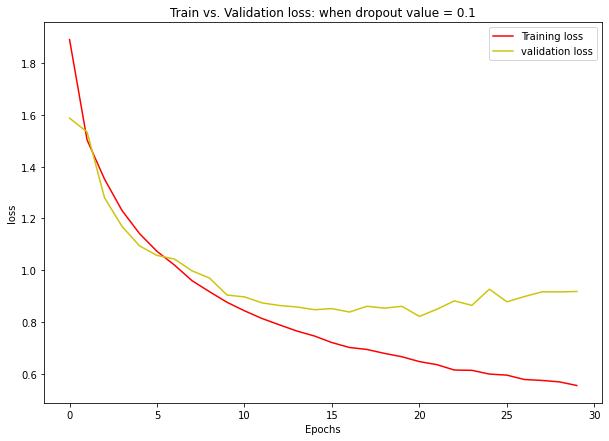

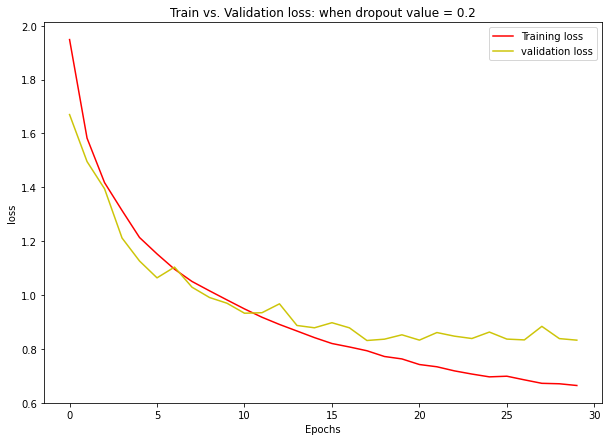

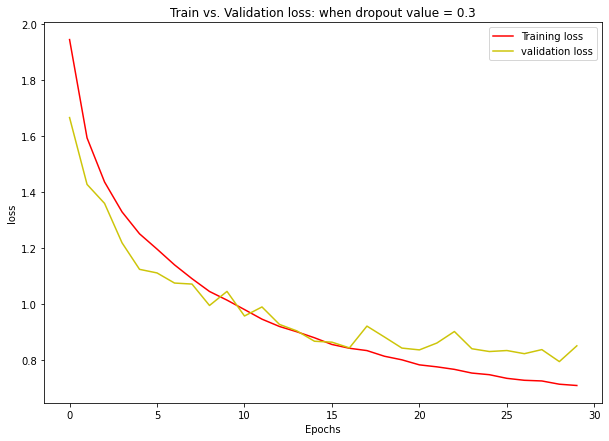

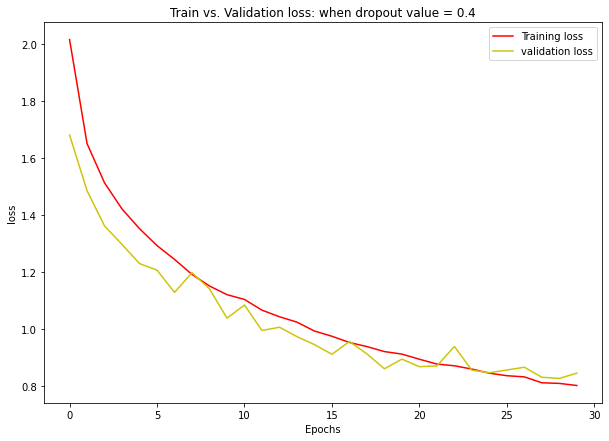

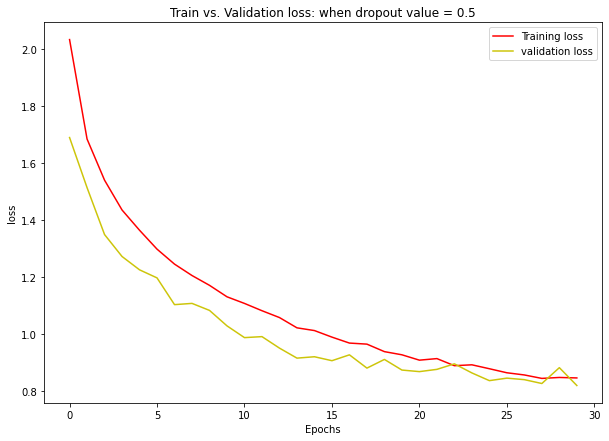

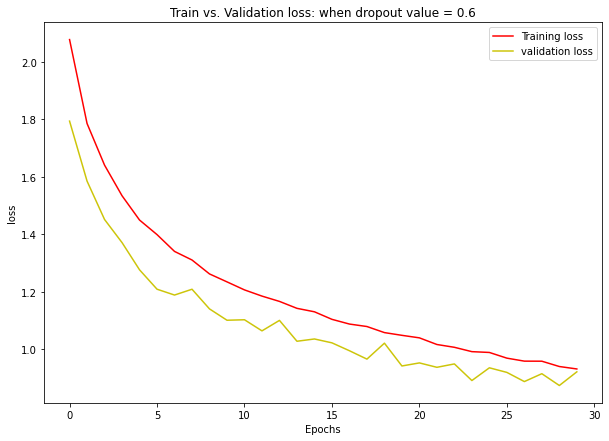

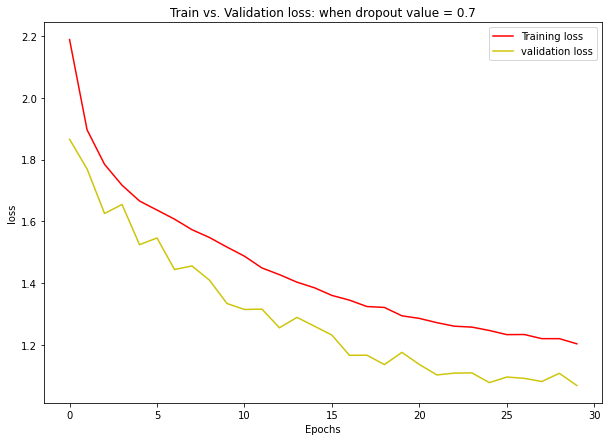

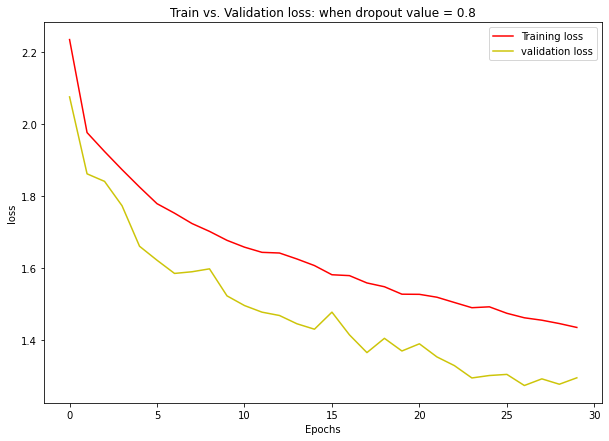

time: 1.62 s (started: 2022-05-29 12:21:43 +00:00)


In [ ]:
# a helper function used to prints the loss line charts for the different dropout rates used
generatePlot(history_D, 'dropout value')

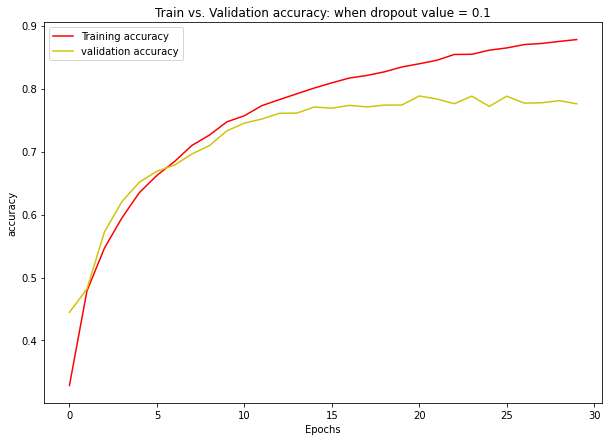

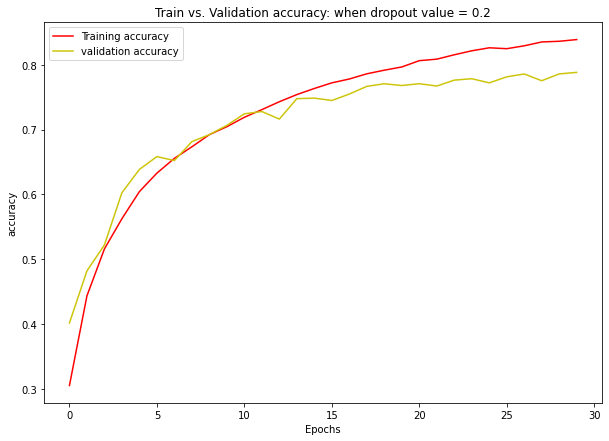

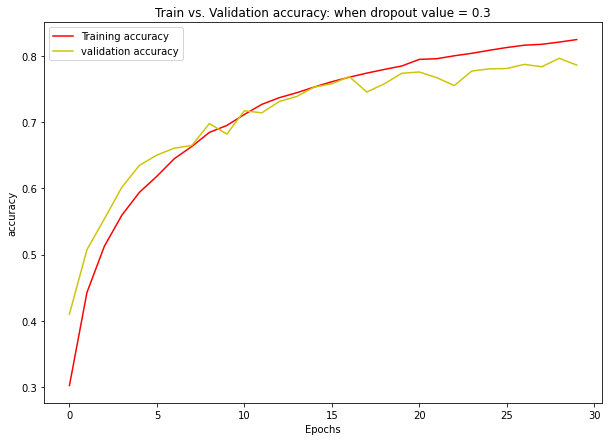

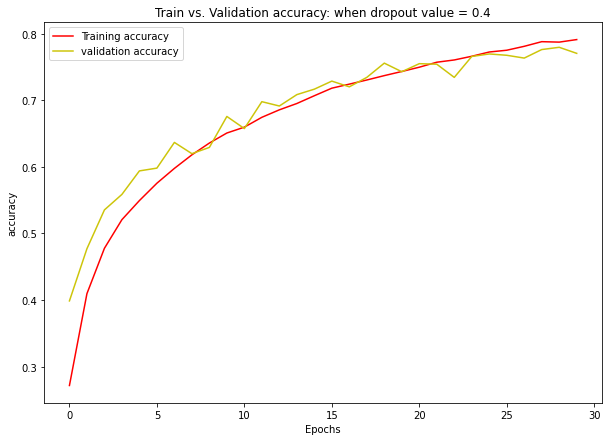

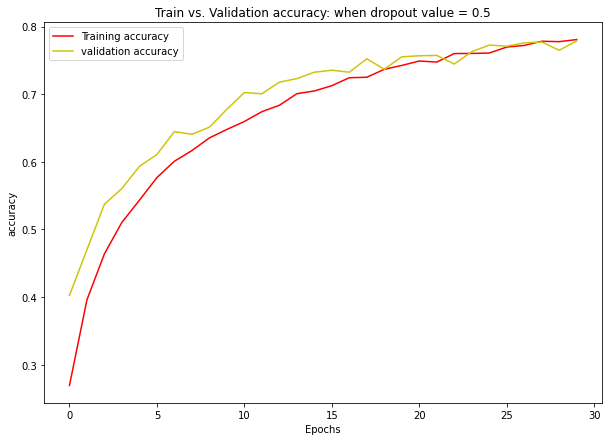

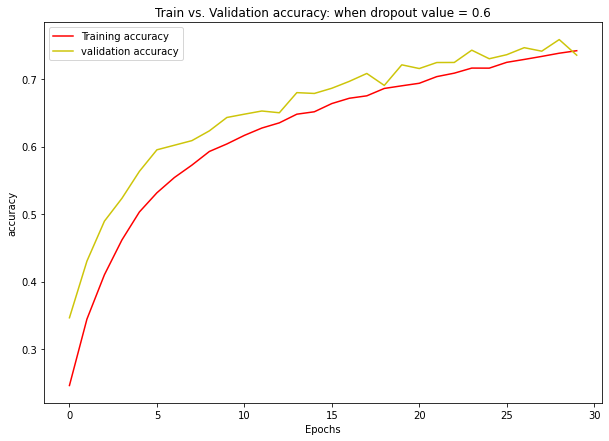

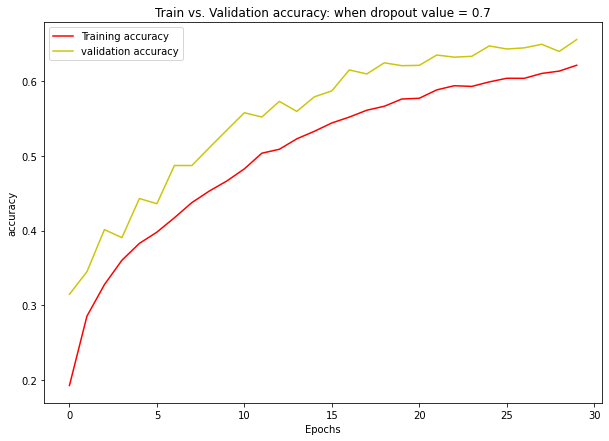

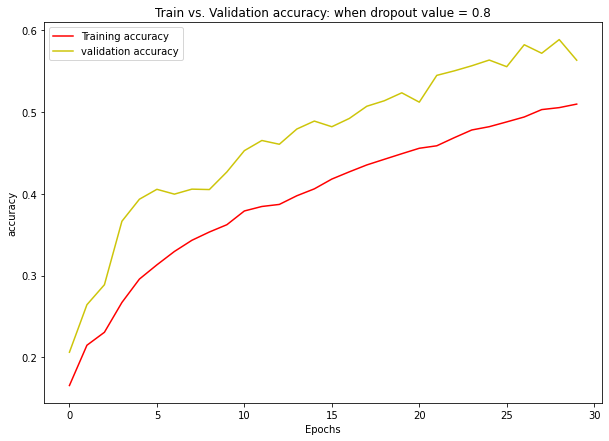

time: 1.58 s (started: 2022-05-29 12:21:45 +00:00)


In [ ]:
# a helper function used to prints the accuracy line charts for the different dropout rates used
generate_accuracy_Plot(history_D, 'dropout value')

<p> As we shown above, the dropout rate of 0.8's training and validation accuracy  is so bumpy and unstable, which makes it unsuitable to be used as the optimal value. With 0.5, 0.6 and 0.7, the validation accuracy is higher than the training accuracy implying that the model is under training data. With 0.1, 0.2, 0.3 and  0.4, as the training epochs increases the training accuracy is higher than the validation accuracy. We observe 0.3 is the optimal dropout rate in this experiment since it experience less overfitting. </p>

In [ ]:
# helper function that derives and return the different data frames for dropout rates
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'dropout')

time: 2.49 ms (started: 2022-05-29 12:21:46 +00:00)


In [ ]:
val_loss_df

dropout  val_loss
0      0.1  0.918239
1      0.2  0.832059
2      0.3  0.849635
3      0.4  0.844265
4      0.5  0.820055
5      0.6  0.920814
6      0.7  1.067412
7      0.8  1.294656

time: 6.37 ms (started: 2022-05-29 12:21:46 +00:00)


In [ ]:
val_accuracy_df

dropout  val_accuracy_L
0      0.1          0.7758
1      0.2          0.7882
2      0.3          0.7857
3      0.4          0.7706
4      0.5          0.7789
5      0.6          0.7353
6      0.7          0.6555
7      0.8          0.5629

time: 6.24 ms (started: 2022-05-29 12:21:46 +00:00)


<p>We observe that 0.2 is the optimal dropout rate, however, we didnot see any changes in the validation loss since we are gettting a high value. So, we would rather move forward with results where added extra Convolutional layers to the network.</p>

In [ ]:
# helper function that returns the data frame for the train loss and accuracy
train_loss_df, train_accuracy_df= deriveAccuracy_df(train_loss_L, train_accuracy_L, 'dropout')

time: 1.53 ms (started: 2022-05-29 12:21:46 +00:00)


In [ ]:
train_loss_df

dropout  train_loss
0      0.1    0.469749
1      0.2    0.506716
2      0.3    0.571268
3      0.4    0.650919
4      0.5    0.641728
5      0.6    0.783914
6      0.7    0.992038
7      0.8    1.242535

time: 7.61 ms (started: 2022-05-29 12:21:46 +00:00)


In [ ]:
train_accuracy_df

dropout  train_accuracy
0      0.1        0.917900
1      0.2        0.899350
2      0.3        0.870425
3      0.4        0.839625
4      0.5        0.842925
5      0.6        0.778200
6      0.7        0.678450
7      0.8        0.580950

time: 6.46 ms (started: 2022-05-29 12:21:46 +00:00)


#### More dropout rate exploration when the dropout layer is added after every activation layer. 

In [ ]:
seed = 7                                      # random seed to reproduce the same output
history_D = {}
val_loss_L = []                               # list of val_loss
val_accuracy_L = []                           # list of val accuracy
train_loss_L = []                             # list of train loss
train_accuracy_L = []                         # list of train accuracy
dropout_L = [round((i *0.1), 3) for i in range(1, 9)]
recordTime_L = []                             # list of run time execution for each mini batch size
for fact in range(len(dropout_L)):
  print('Dropout rate being used is %.3f' %dropout_L[fact])
  model = models.Sequential()
  
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # This is added
  model.add(layers.Dropout(dropout_L[fact]))

  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # This is added
  model.add(layers.Dropout(dropout_L[fact]))

  model.add(layers.Conv2D(128, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(128, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #first dropout
  model.add(layers.Dropout(dropout_L[fact]))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

  #last dropout
  model.add(layers.Dropout(dropout_L[fact]))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above

  #print(learningRate_L[eta])
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  # compile the model
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])
  # startime
  startTime = time.time()
  # train the model
  history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))
  # endtime
  endTime = time.time()

  recordTime_L.append((dropout_L[fact], endTime - startTime))
  # insert the history of the current execution into a dictionary.
  history_D[dropout_L[fact]] = history

  # compute the loss and accuracy
  val_loss, val_acc = model.evaluate(valid_images, valid_labels)
  train_loss, train_accuracy = model.evaluate(train_images, train_labels)

  # append the train_loss val_loss of the current execution to the list
  train_loss_L.append([dropout_L[fact], train_loss])
  val_loss_L.append([dropout_L[fact], val_loss])

  # append the validation and training accuracy of the current execution to the list 
  train_accuracy_L.append([dropout_L[fact], train_accuracy])
  val_accuracy_L.append([dropout_L[fact], val_acc])

Dropout rate being used is 0.100
Epoch 1/30
400/400 [==============================] - 3s 7ms/step - loss: 1.9079 - accuracy: 0.3337 - val_loss: 1.7211 - val_accuracy: 0.4054
Epoch 2/30
400/400 [==============================] - 2s 6ms/step - loss: 1.5006 - accuracy: 0.4855 - val_loss: 1.3530 - val_accuracy: 0.5480
Epoch 3/30
400/400 [==============================] - 2s 6ms/step - loss: 1.3310 - accuracy: 0.5576 - val_loss: 1.2087 - val_accuracy: 0.6068
Epoch 4/30
400/400 [==============================] - 2s 6ms/step - loss: 1.2201 - accuracy: 0.6046 - val_loss: 1.1478 - val_accuracy: 0.6315
Epoch 5/30
400/400 [==============================] - 2s 6ms/step - loss: 1.1449 - accuracy: 0.6362 - val_loss: 1.1233 - val_accuracy: 0.6450
Epoch 6/30
400/400 [==============================] - 2s 6ms/step - loss: 1.0821 - accuracy: 0.6626 - val_loss: 1.0391 - val_accuracy: 0.6788
Epoch 7/30
400/400 [==============================] - 2s 6ms/step - loss: 1.0416 - accuracy: 0.6823 - val_loss: 1.0

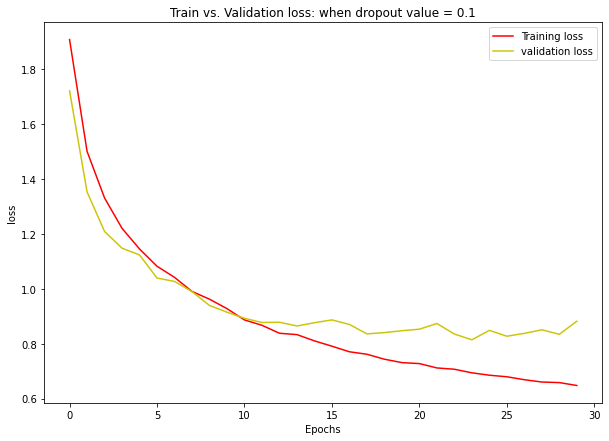

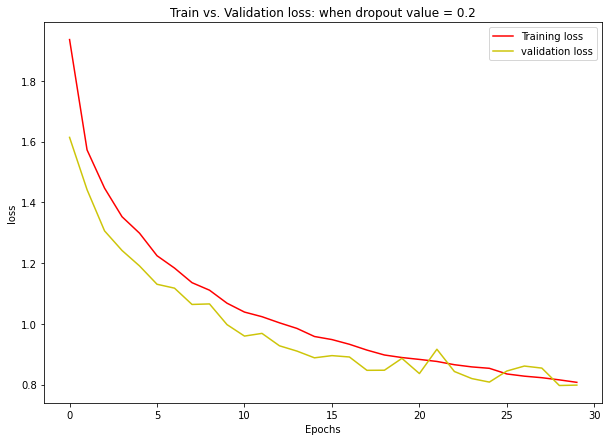

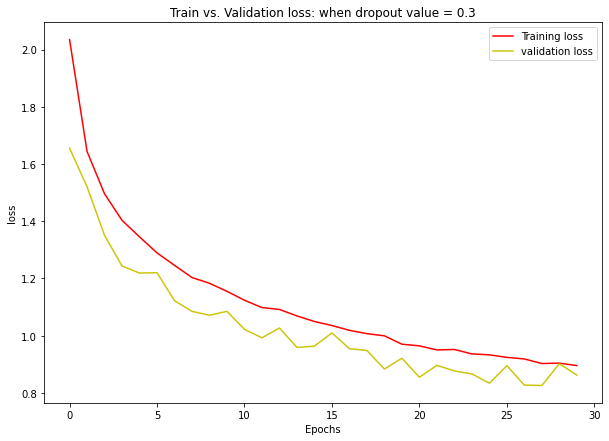

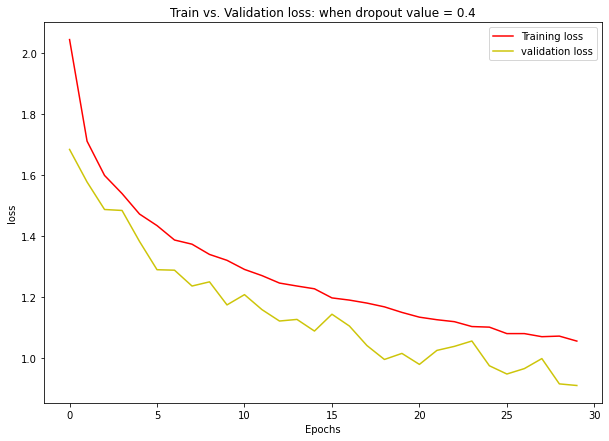

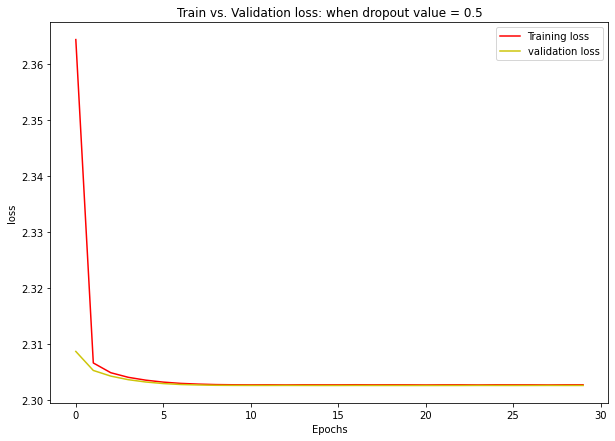

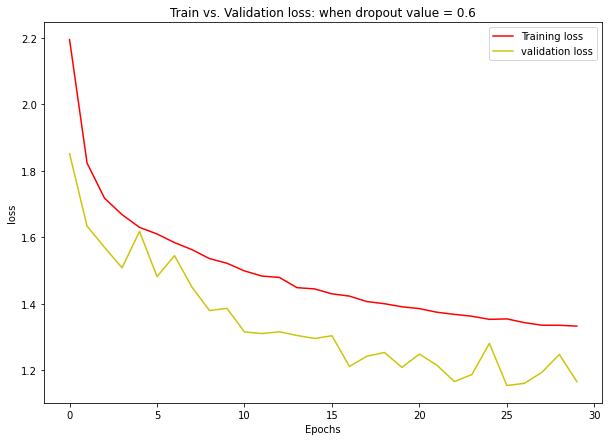

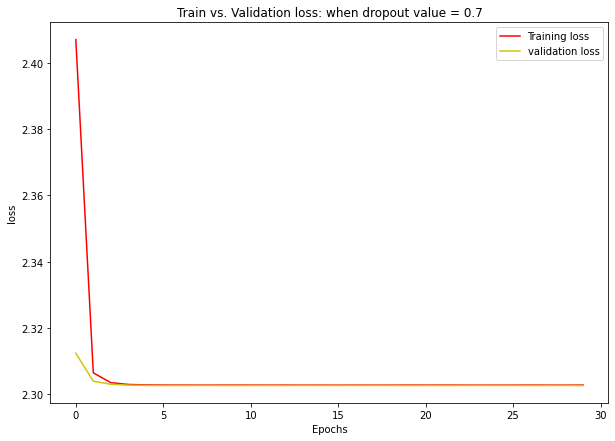

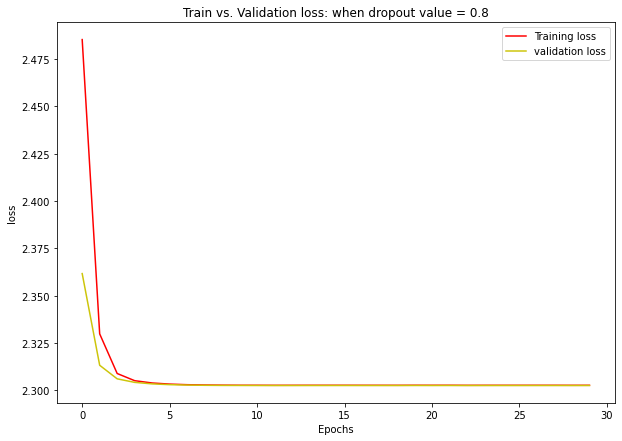

time: 1.55 s (started: 2022-05-29 12:32:12 +00:00)


In [ ]:
# a helper function used to prints the loss line charts for the different dropout rates used
generatePlot(history_D, 'dropout value')

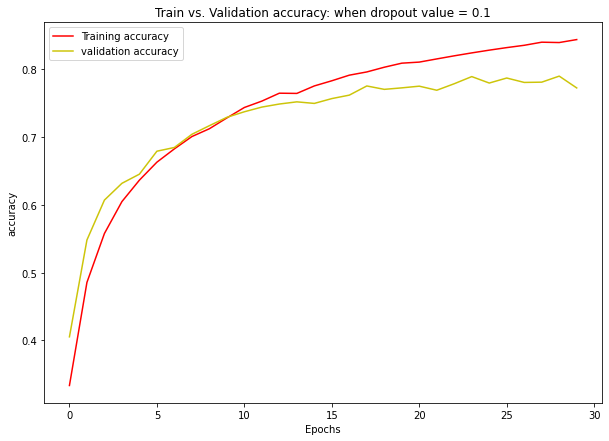

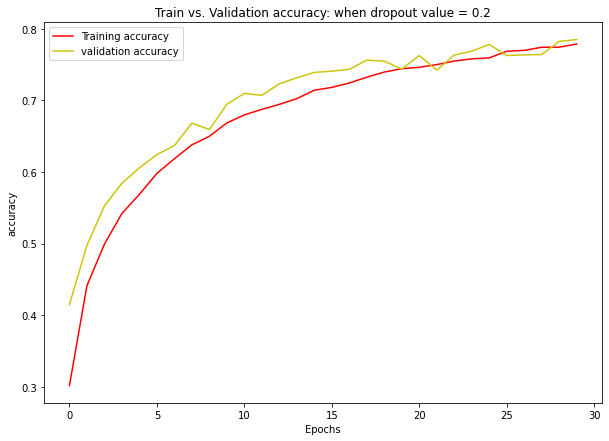

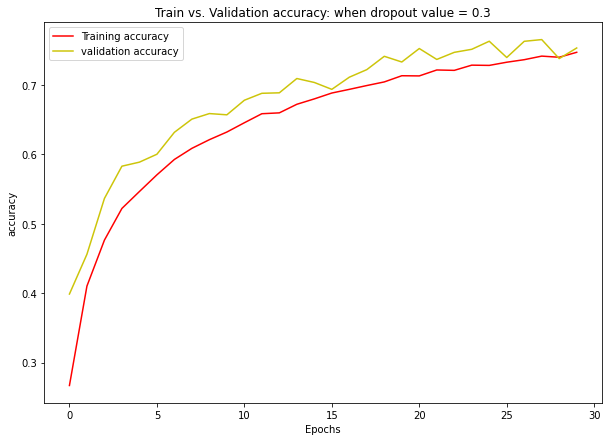

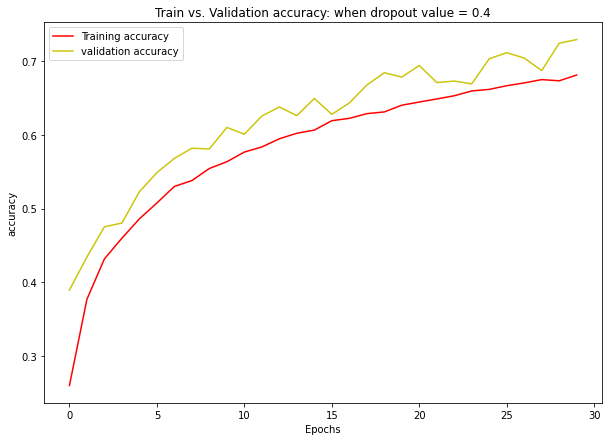

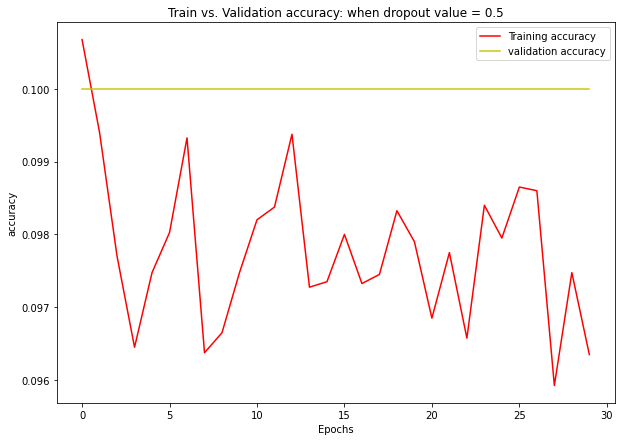

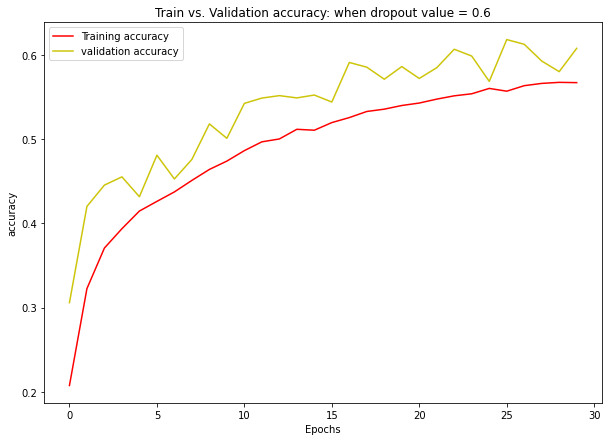

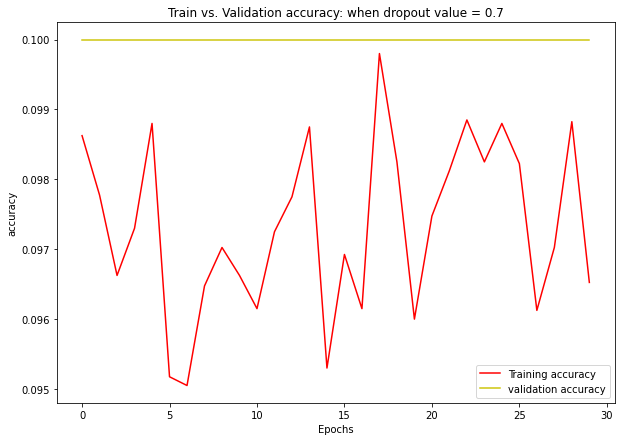

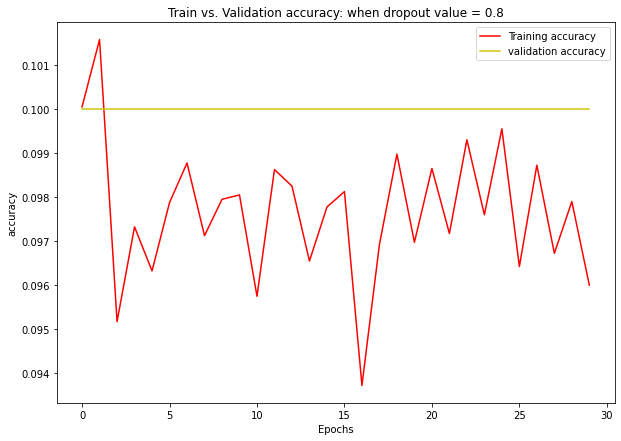

time: 1.63 s (started: 2022-05-29 12:32:14 +00:00)


In [ ]:
# a helper function used to prints the accuracy line charts for the different dropout rates used
generate_accuracy_Plot(history_D, 'dropout value')

In [ ]:
# helper function that derives and return the different data frames for dropout rates
val_loss_df, val_accuracy_df, recordTime_df = deriveDataFrame(val_loss_L, val_accuracy_L, recordTime_L, 'dropout')

time: 2.23 ms (started: 2022-05-29 12:32:16 +00:00)


In [ ]:
val_loss_df

dropout  val_loss
0      0.1  0.881706
1      0.2  0.798017
2      0.3  0.862237
3      0.4  0.910638
4      0.5  2.302594
5      0.6  1.165571
6      0.7  2.302591
7      0.8  2.302595

time: 6.75 ms (started: 2022-05-29 12:32:16 +00:00)


In [ ]:
val_accuracy_df

dropout  val_accuracy_L
0      0.1          0.7720
1      0.2          0.7847
2      0.3          0.7532
3      0.4          0.7297
4      0.5          0.1000
5      0.6          0.6080
6      0.7          0.1000
7      0.8          0.1000

time: 6.06 ms (started: 2022-05-29 12:32:16 +00:00)


In [ ]:
# helper function that returns the data frame for the train loss and accuracy
train_loss_df, train_accuracy_df= deriveAccuracy_df(train_loss_L, train_accuracy_L, 'dropout')

time: 1.65 ms (started: 2022-05-29 12:32:16 +00:00)


In [ ]:
train_accuracy_df

dropout  train_accuracy
0      0.1        0.878200
1      0.2        0.841875
2      0.3        0.803450
3      0.4        0.759300
4      0.5        0.100000
5      0.6        0.629350
6      0.7        0.100000
7      0.8        0.100000

time: 6.65 ms (started: 2022-05-29 12:32:16 +00:00)


## Adding Batch Normalization

Batch Normalization is used to standardize the input images before or after the activation of the previous layer, in our case we shall add it after the activation function of the previous layer so that the model can attain the best peformance.

In [ ]:
#seed = 7                                      # random seed to reproduce the same output
model = models.Sequential()
  
model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), strides=(1,1),padding='same', kernel_regularizer=l2(0.001), activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
 

model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#first dropout
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
  
#last dropout
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))  # As noted above

#print(learningRate_L[eta])
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# compile the model
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])

# train the model
history_batchNorm = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, 
                      validation_data=(valid_images, valid_labels))


Epoch 1/30
400/400 [==============================] - 4s 8ms/step - loss: 1.7994 - accuracy: 0.4540 - val_loss: 2.3488 - val_accuracy: 0.2839
Epoch 2/30
400/400 [==============================] - 3s 7ms/step - loss: 1.2956 - accuracy: 0.6283 - val_loss: 1.4974 - val_accuracy: 0.5505
Epoch 3/30
400/400 [==============================] - 3s 6ms/step - loss: 1.0802 - accuracy: 0.6980 - val_loss: 1.2800 - val_accuracy: 0.6527
Epoch 4/30
400/400 [==============================] - 3s 6ms/step - loss: 0.9599 - accuracy: 0.7363 - val_loss: 0.9909 - val_accuracy: 0.7294
Epoch 5/30
400/400 [==============================] - 3s 7ms/step - loss: 0.8765 - accuracy: 0.7656 - val_loss: 1.4045 - val_accuracy: 0.6071
Epoch 6/30
400/400 [==============================] - 3s 7ms/step - loss: 0.8123 - accuracy: 0.7860 - val_loss: 1.0350 - val_accuracy: 0.7194
Epoch 7/30
400/400 [==============================] - 3s 6ms/step - loss: 0.7691 - accuracy: 0.8018 - val_loss: 1.0928 - val_accuracy: 0.7048
Epoch 

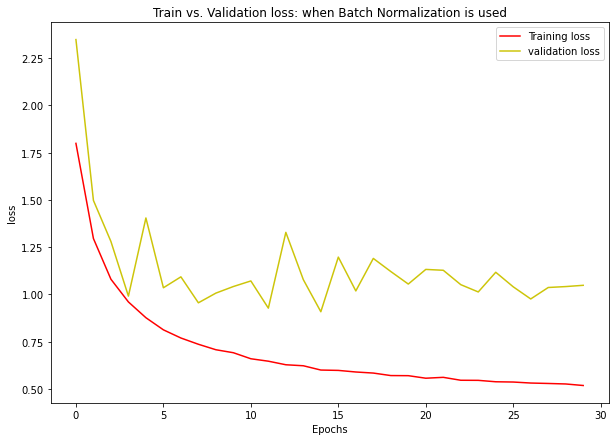

time: 167 ms (started: 2022-05-29 12:33:37 +00:00)


In [ ]:
# set the figure
plt.figure(figsize=(10, 7))
line_mse = plt.plot(range(0,EPOCHS), history_batchNorm.history['loss'], 'r')
line_crossEntropy = plt.plot(range(0,EPOCHS), history_batchNorm.history['val_loss'], '#cdc50a')
plt.title('Train vs. Validation loss: when Batch Normalization is used')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'validation loss'])
plt.show()

<Figure size 720x504 with 0 Axes>

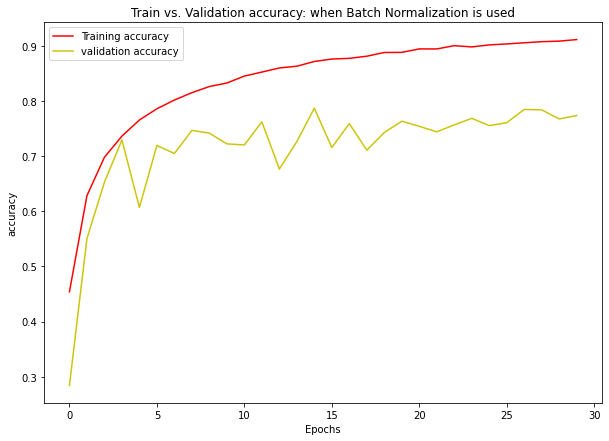

time: 480 ms (started: 2022-05-29 12:33:37 +00:00)


In [ ]:
# set the figure
plt.figure(figsize=(10, 7))
plt.figure(figsize=(10, 7))
line_mse = plt.plot(range(0,EPOCHS), history_batchNorm.history['accuracy'], 'r')
line_crossEntropy = plt.plot(range(0,EPOCHS), history_batchNorm.history['val_accuracy'], '#cdc50a')
plt.title('Train vs. Validation accuracy: when Batch Normalization is used')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend(['Training accuracy', 'validation accuracy'])
plt.show()

Added batch normalization, but from what I notice is that it introduces more overfitting to the training data.

In [ ]:
# create a data frame containing the loss and accuracy of the model
data = {'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
        'val_loss': history_batchNorm.history['val_loss'], 
        'val_accuracy': history_batchNorm.history['val_accuracy'],
        'loss':history_batchNorm.history['loss'],
        'training accuracy':history_batchNorm.history['accuracy']}
# create a data frame
val_accuracy_loss_df = pd.DataFrame(data)

time: 3.69 ms (started: 2022-05-29 12:33:37 +00:00)


In [ ]:
# sort the data frame by validation accuracy
val_accuracy_loss_df.sort_values(by=['val_accuracy'], inplace=True, ascending=False) # the first five records
print(val_accuracy_loss_df)

    Epoch  val_loss  val_accuracy      loss  training accuracy
14     15  0.908080        0.7870  0.599467           0.871800
26     27  0.975783        0.7848  0.530704           0.905725
27     28  1.036455        0.7840  0.528442           0.907700
29     30  1.048026        0.7738  0.517647           0.911525
23     24  1.012856        0.7687  0.544935           0.898225
28     29  1.041340        0.7675  0.525758           0.908725
19     20  1.054698        0.7634  0.569657           0.888325
11     12  0.927124        0.7624  0.646315           0.852525
25     26  1.040018        0.7607  0.536023           0.903600
16     17  1.018337        0.7591  0.589150           0.877450
22     23  1.051494        0.7567  0.545426           0.900450
24     25  1.117082        0.7554  0.537422           0.901850
20     21  1.132175        0.7542  0.556233           0.894575
7       8  0.955390        0.7467  0.735929           0.815175
21     22  1.127626        0.7442  0.560863           0

## Data Augmentation

### Using data augmentation, derive batches of tensor images.

In [ ]:
"""
datagen=ImageDataGenerator(
    # Set input mean to 0 over the dataset, featurewise
    #featurewise_center=True,

    # Set each sample mean to 0 
    #samplewise_center=False, 
    
    # Divide inputs by the std of the dataset, feature-wise
    #featurewise_std_normalization=True, 
    
    # Apply ZCA whitening
    zca_whitening=True, 
    
    # Degree range of random rotations
    # it was 20
    rotation_range=20, 
    
    # Range for random zoom
    zoom_range=0.2, 
    
    # fraction of total width
    width_shift_range=0.1, 
    
    # fraction of total height
    height_shift_range=0.1, 
    
    # randomly flip inputs horizontally
    horizontal_flip=True,
    
    # randomly flips inputs vertically
    # vertical_flip=True

    # fraction of images reversed for validation 
    #validation_split=0.2,

    shear_range=0.2,
    # fill_mode='constant',
    # fill_mode='reflect'
    # cval=125
    # values greater than 1.0 make the image brighter [0.5, 1.0]
    # values greater than 1.0 make a darker image like [1.0, 2.0] 
    brightness_range=[2.0,1.0]

 )

# computes the internal data stats related to the data-dependent transformations.
datagen.fit(train_images)
"""

"\ndatagen=ImageDataGenerator(\n    # Set input mean to 0 over the dataset, featurewise\n    #featurewise_center=True,\n\n    # Set each sample mean to 0 \n    #samplewise_center=False, \n    \n    # Divide inputs by the std of the dataset, feature-wise\n    #featurewise_std_normalization=True, \n    \n    # Apply ZCA whitening\n    zca_whitening=True, \n    \n    # Degree range of random rotations\n    # it was 20\n    rotation_range=20, \n    \n    # Range for random zoom\n    zoom_range=0.2, \n    \n    # fraction of total width\n    width_shift_range=0.1, \n    \n    # fraction of total height\n    height_shift_range=0.1, \n    \n    # randomly flip inputs horizontally\n    horizontal_flip=True,\n    \n    # randomly flips inputs vertically\n    # vertical_flip=True\n\n    # fraction of images reversed for validation \n    #validation_split=0.2,\n\n    shear_range=0.2,\n    # fill_mode='constant',\n    # fill_mode='reflect'\n    # cval=125\n    # values greater than 1.0 make the im

time: 5.88 ms (started: 2022-05-29 13:14:48 +00:00)


In [ ]:
"""
seed = 7
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), strides=(1,1),padding='same', kernel_regularizer=l2(0.001), activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#first dropout
#model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
  
#last dropout
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))  # As noted above
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train the model
#history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, validation_data=(valid_images, valid_labels))
history = model.fit(datagen.flow(train_images, to_categorical(train_labels), batch_size=32), 
                              epochs=EPOCHS, 
                              validation_data=datagen.flow(valid_images, to_categorical(valid_labels)), steps_per_epoch= train_images.shape[0]/32
                              )
"""

In [ ]:
"""
seed = 7
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), strides=(1,1),padding='same', kernel_regularizer=l2(0.001), activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#first dropout
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# adding Batch Normalization layers
model.add(layers.BatchNormalization())
  
#last dropout
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))  # As noted above
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train the model
#history = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=100, validation_data=(valid_images, valid_labels))
history = model.fit(datagen.flow(train_images, to_categorical(train_labels), batch_size=32), 
                              epochs=30, 
                              validation_data=datagen.flow(valid_images, to_categorical(valid_labels)), 
                    steps_per_epoch= train_images.shape[0]/32
                              )
"""

"\nseed = 7\nmodel = models.Sequential()\nmodel.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))\nmodel.add(layers.Conv2D(32, (3, 3), strides=(1,1),padding='same', kernel_regularizer=l2(0.001), activation='relu'))\n# adding Batch Normalization layers\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.MaxPooling2D((2, 2)))\n\n\nmodel.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))\nmodel.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))\n# adding Batch Normalization layers\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.MaxPooling2D((2, 2)))\n\nmodel.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))\nmodel.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activati

time: 7.42 ms (started: 2022-05-29 13:14:48 +00:00)


## GridSearchCV/RandomSearchCV

I was supposed to have used GridSearchCV, but the peformance of the module is dissapointing so I decided to use RandomSearchCV, which also ran for hours because it constructs and evaluates  one model for each combination of parameters.

### batch size and epoch

I started with these two, since it is always advisable to hypertune them together.

In [ ]:
def deriveModelWithDropout():
  """Function that derives and return the network model"""
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1),padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # adding Batch Normalization layers
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))


  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # adding Batch Normalization layers
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # adding Batch Normalization layers
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  #first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  # adding Batch Normalization layers
  model.add(layers.BatchNormalization())
  
  #last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above
  # model.summary()

  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

'\nhistory = model.fit(datagen.flow(train_images, to_categorical(train_labels), batch_size=32), \n                              epochs=10, \n                              validation_data=datagen.flow(valid_images, to_categorical(valid_labels)), \n                    steps_per_epoch= train_images.shape[0]/32\n                              )\n'

time: 33.7 ms (started: 2022-05-29 13:14:49 +00:00)


In [ ]:
# define the parameters
grid_parameters = {
    'batch_size' : [32, 64, 96, 100], 
    #'dropout_rate' : [0.1, 0.2, 0.3],
    'epochs' : [10, 30, 80, 100]
    }

time: 987 µs (started: 2022-05-29 13:14:49 +00:00)


In [ ]:
# create the model 
# keep the verbose to zero so that we don't display all the details of each epoc
model_history_dropout =  KerasClassifier(build_fn=deriveModelWithDropout,  verbose=2)

time: 2.18 ms (started: 2022-05-29 13:14:49 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# create an estimator object
grid_est = RandomizedSearchCV(estimator=model_history_dropout, param_distributions=grid_parameters, cv=3, n_jobs=-10, n_iter=100)

time: 934 µs (started: 2022-05-29 13:14:49 +00:00)


In [ ]:
# search the whole space with fit
gridSearch_res = grid_est.fit(train_images, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Streaming output truncated to the last 5000 lines.
Epoch 42/80
834/834 - 4s - loss: 0.6518 - accuracy: 0.8865 - 4s/epoch - 5ms/step
Epoch 43/80
834/834 - 4s - loss: 0.6551 - accuracy: 0.8837 - 4s/epoch - 5ms/step
Epoch 44/80
834/834 - 4s - loss: 0.6410 - accuracy: 0.8889 - 4s/epoch - 5ms/step
Epoch 45/80
834/834 - 4s - loss: 0.6511 - accuracy: 0.8859 - 4s/epoch - 5ms/step
Epoch 46/80
834/834 - 4s - loss: 0.6421 - accuracy: 0.8895 - 4s/epoch - 5ms/step
Epoch 47/80
834/834 - 4s - loss: 0.6481 - accuracy: 0.8860 - 4s/epoch - 5ms/step
Epoch 48/80
834/834 - 4s - loss: 0.6560 - accuracy: 0.8842 - 4s/epoch - 5ms/step
Epoch 49/80
834/834 - 4s - loss: 0.6316 - accuracy: 0.8937 - 4s/epoch - 5ms/step
Epoch 50/80
834/834 - 4s - loss: 0.6417 - accuracy: 0.8906 - 4s/epoch - 5ms/step
Epoch 51/80
834/834 - 4s - loss: 0.6403 - accuracy: 0.8898 - 4s/epoch - 5ms/step
Epoch 52/80
834/834 - 4s - loss: 0.6379 - accuracy: 0.8910 - 4s/epoch - 5ms/step
Epoch 53/80
834/834 - 4s - loss: 0.6251 - accuracy: 0.8957

In [ ]:
# grid search results:
print('The best mini_batch_size: %d ' %gridSearch_res.best_params_['batch_size'])
print('The best epoch value: %d' %gridSearch_res.best_params_['epochs'])
randomSearch_estimator = gridSearch_res.best_estimator_

The best mini_batch_size: 32 
The best epoch value: 80
time: 1.65 ms (started: 2022-05-29 15:08:40 +00:00)


In [ ]:
# write the Random Search results to a file.
import joblib
filename='gridSearch_res_best_estimator.pkl'
joblib.dump(gridSearch_res.best_estimator_, filename)

INFO:tensorflow:Assets written to: ram://f70ef055-d837-43e3-9f09-611c2b7999e6/assets


['gridSearch_res_best_estimator.pkl']

time: 2.81 s (started: 2022-05-29 15:08:40 +00:00)


### learning rate

<p>We shall create a dictionary of the following values: 0.001, 0.01, 0.1, 0.3 and determine the optimal value using Random SearchCV.</p>

In [ ]:
#from tensorflow.keras.optimizers import Adam
def deriveModelWithlearn_rate(optimizer='adam', learning_rate=0.001):
  """Function that derives and return the network model"""
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1),padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # adding Batch Normalization layers
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))


  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # adding Batch Normalization layers
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # adding Batch Normalization layers
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  #first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  # adding Batch Normalization layers
  model.add(layers.BatchNormalization())
  
  #last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above
  # model.summary()
  
   
  if optimizer == 'rmsprop':
    opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif optimizer == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

time: 32.3 ms (started: 2022-05-29 16:22:31 +00:00)


In [ ]:
# define the parameters
grid_parameters = {
    'learning_rate' : [0.001, 0.01, 0.1, 0.3], 
    }

time: 999 µs (started: 2022-05-29 16:22:36 +00:00)


In [ ]:
# keep the verbose to 2 so that we see all the details of each epoch
# using the batchsize of 32 and epoch 80
model_history_learnRate =  KerasClassifier(build_fn=deriveModelWithlearn_rate,  epochs=80, batch_size=32, verbose=2)

time: 1.75 ms (started: 2022-05-29 16:22:38 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
# create an estimator object
random_est_Lr = RandomizedSearchCV(estimator=model_history_learnRate, param_distributions=grid_parameters, cv=3, n_jobs=-2, n_iter=100)


time: 1.1 ms (started: 2022-05-29 16:22:41 +00:00)


In [ ]:
# search the whole space with fit
randSearch_res_lr = random_est_Lr.fit(train_images, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 23

Epoch 1/80
1250/1250 - 7s - loss: 1.8476 - accuracy: 0.4190 - 7s/epoch - 5ms/step
Epoch 2/80
1250/1250 - 6s - loss: 1.3754 - accuracy: 0.5762 - 6s/epoch - 4ms/step
Epoch 3/80
1250/1250 - 6s - loss: 1.1819 - accuracy: 0.6457 - 6s/epoch - 5ms/step
Epoch 4/80
1250/1250 - 6s - loss: 1.0961 - accuracy: 0.6776 - 6s/epoch - 4ms/step
Epoch 5/80
1250/1250 - 6s - loss: 1.0049 - accuracy: 0.7125 - 6s/epoch - 5ms/step
Epoch 6/80
1250/1250 - 6s - loss: 0.9721 - accuracy: 0.7254 - 6s/epoch - 5ms/step
Epoch 7/80
1250/1250 - 6s - loss: 0.9806 - accuracy: 0.7232 - 6s/epoch - 4ms/step
Epoch 8/80
1250/1250 - 6s - loss: 0.9515 - accuracy: 0.7365 - 6s/epoch - 4ms/step
Epoch 9/80
1250/1250 - 6s - loss: 0.9204 - accuracy: 0.7484 - 6s/epoch - 4ms/step
Epoch 10/80
1250/1250 - 6s - loss: 0.9957 - accuracy: 0.7262 - 6s/epoch - 4ms/step
Epoch 11/80
1250/1250 - 6s - loss: 0.9387 - accuracy: 0.7413 - 6s/epoch - 5ms/step
Epoch 12/80
1250/1250 - 6s - loss: 0.9119 - accuracy: 0.7520 - 6s/epoch - 4ms/step
Epoch 13/80
1

In [ ]:
# write the Random Search results to a file.
import joblib
randSearch_filename='randSearch_res_lr_best_estimator.pkl'
joblib.dump(randSearch_res_lr.best_estimator_, randSearch_filename)

INFO:tensorflow:Assets written to: ram://6db735df-bce3-478a-9574-244d13454905/assets


['randSearch_res_lr_best_estimator.pkl']

time: 2.28 s (started: 2022-05-29 16:38:30 +00:00)


In [ ]:
# load the results
import joblib
randSearch_filename='randSearch_res_lr_best_estimator.pkl'
randSearch_results_lr = joblib.load(randSearch_filename)



time: 1.03 s (started: 2022-05-29 16:38:49 +00:00)


In [ ]:
# grid search results:
print('The best learning rate: %.5f ' %randSearch_res_lr.best_params_['learning_rate'])
randSearch_res_lr_estimator = randSearch_res_lr.best_estimator_

The best learning rate: 0.00100 
time: 1.6 ms (started: 2022-05-29 16:43:04 +00:00)


In [ ]:
random_est_Lr.best_params_

{'learning_rate': 0.001}

time: 5.15 ms (started: 2022-05-29 16:42:40 +00:00)


### neurons in the fully connected layer

<p>Using values of 24, 32, 48, 64, 96, 80, and 128 we shall use Random SearchCV to find the optimal value. </p>

In [ ]:
#from tensorflow.keras.optimizers import Adam
def deriveModelWith_neurons(optimizer='adam', learning_rate=0.0010, unit=16):
  """Function that derives and return the network model"""
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1),padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # adding Batch Normalization layers
  #model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))


  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # adding Batch Normalization layers
  #model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # adding Batch Normalization layers
  #model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  #first dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(unit, activation='relu'))
  # adding Batch Normalization layers
  #model.add(layers.BatchNormalization())
  
  #last dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above
  # model.summary()
  
   
  if optimizer == 'rmsprop':
    opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif optimizer == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

time: 31.5 ms (started: 2022-05-29 16:56:57 +00:00)


In [ ]:
# define the parameters
grid_parameters = {
    'unit' : [24, 32, 48, 64, 96, 80, 128]
    }

time: 956 µs (started: 2022-05-29 16:57:01 +00:00)


In [ ]:
	# create the model 
# keep the verbose to zero so that we don't display all the details of each epoc
model_history_neurons =  KerasClassifier(build_fn=deriveModelWith_neurons, epochs=80, batch_size=32,  verbose=2)

time: 1.54 ms (started: 2022-05-29 16:57:04 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# create an estimator object
random_est_neurons = RandomizedSearchCV(estimator=model_history_neurons, param_distributions=grid_parameters, cv=3, n_jobs=-10, n_iter=100)


time: 917 µs (started: 2022-05-29 16:57:08 +00:00)


In [ ]:
# search the whole space with fit
randSearch_res_neurons = random_est_neurons.fit(train_images, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 7 is smaller than n_iter=100. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Epoch 1/80
834/834 - 4s - loss: 2.3108 - accuracy: 0.0936 - 4s/epoch - 5ms/step
Epoch 2/80
834/834 - 3s - loss: 2.3027 - accuracy: 0.0992 - 3s/epoch - 4ms/step
Epoch 3/80
834/834 - 3s - loss: 2.3027 - accuracy: 0.0987 - 3s/epoch - 4ms/step
Epoch 4/80
834/834 - 3s - loss: 2.3027 - accuracy: 0.0995 - 3s/epoch - 4ms/step
Epoch 5/80
834/834 - 3s - loss: 2.3027 - accuracy: 0.0983 - 3s/epoch - 4ms/step
Epoch 6/80
834/834 - 3s - loss: 2.3027 - accuracy: 0.1015 - 3s/epoch - 4ms/step
Epoch 7/80
834/834 - 3s - loss: 2.3027 - accuracy: 0.0985 - 3s/epoch - 4ms/step
Epoch 8/80
834/834 - 3s - loss: 2.3027 - accuracy: 0.0970 - 3s/epoch - 4ms/step
Epoch 9/80
834/834 - 3s - loss: 2.3027 - accuracy: 0.1006 - 3s/epoch - 4ms/step
Epoch 10/80
834/834 - 3s - loss: 2.3027 - accuracy: 0.0972 - 3s/epoch - 4ms/step
Epoch 11/80
834/834 - 3s - loss: 2.3027 - accuracy: 0.1004 - 3s/epoch - 4ms/step
Epoch 12/80
834/834 - 3s - loss: 2.3027 - accuracy: 0.0993 - 3s/epoch - 4ms/step
Epoch 13/80
834/834 - 3s - loss: 2.30

In [ ]:
# write the Random Search results to a file.
import joblib
randSearch_filename='randSearch_res_neurons_best_estimator.pkl'
joblib.dump(randSearch_res_neurons.best_estimator_, randSearch_filename)

INFO:tensorflow:Assets written to: ram://7a8609cc-f2f9-4f6c-9bfb-46957f9676d7/assets


['randSearch_res_neurons_best_estimator.pkl']

time: 1.64 s (started: 2022-05-29 18:44:59 +00:00)


In [ ]:
# load the results
import joblib
randSearch_results_neurons = joblib.load(randSearch_filename)

time: 1.46 s (started: 2022-05-29 18:45:50 +00:00)


In [ ]:
# grid search results:
print('The best units for the fully connected layer: %d ' %randSearch_res_neurons.best_params_['unit'])
# randSearch_res_neurons_estimator = randSearch_res_neurons.best_estimator_

The best units for the fully connected layer: 64 
time: 1.61 ms (started: 2022-05-29 18:49:20 +00:00)


### Gridsearch dropout regularization

<p>To get good results, it’s always advisable to combine dropout with weight constraints like the max norm constraint and this involves fitting both the dropout percentage and weight constraint as suggested by <a id=https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/>Jason Brownlee PhD</a><p>

<p>So, using various values of dropout rate: 0.0, 0.1, 0.2, 0.3, 0.4, and 0.5 and for weight constraint: values from 1 to 5, we shall use Random SearchCV to find the optiomal values. </p>

In [ ]:
from keras.constraints import maxnorm
def deriveModelWith_dropout(optimizer='adam', learning_rate=0.0010, dropout_rate=0.0, weight_constraint=1):
  """Function that derives and return the network model"""
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1),padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # adding Batch Normalization layers
  #model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))


  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001), activation='relu'))
  # adding Batch Normalization layers
  #model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(0.001), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  # adding Batch Normalization layers
  #model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  #first dropout
  model.add(layers.Dropout(dropout_rate))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  # adding Batch Normalization layers
  #model.add(layers.BatchNormalization())
  
  #last dropout
  model.add(layers.Dropout(dropout_rate))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above
  # model.summary()
  
   
  if optimizer == 'rmsprop':
    opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif optimizer == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

time: 37.2 ms (started: 2022-05-29 21:23:56 +00:00)


In [ ]:
# define the parameters
grid_parameters = {
    'dropout_rate' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'weight_constraint' : [1, 2, 3, 4, 5]
    }
	

time: 1.39 ms (started: 2022-05-29 21:23:59 +00:00)


In [ ]:
# create the model 
model_history_dropout =  KerasClassifier(build_fn=deriveModelWith_dropout, epochs=80, batch_size=32,  verbose=2)

time: 1.55 ms (started: 2022-05-29 21:24:01 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
# create an estimator object
random_est_dropout = RandomizedSearchCV(estimator=model_history_dropout, param_distributions=grid_parameters, cv=3, n_jobs=1, n_iter=100)

time: 1.07 ms (started: 2022-05-29 21:24:06 +00:00)


In [ ]:
# search the whole space with fit
randSearch_res_dropout = random_est_dropout.fit(train_images, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Epoch 1/80
834/834 - 4s - loss: 2.3102 - accuracy: 0.0986 - 4s/epoch - 5ms/step
Epoch 2/80
834/834 - 4s - loss: 2.3027 - accuracy: 0.0989 - 4s/epoch - 5ms/step
Epoch 3/80
834/834 - 4s - loss: 2.3027 - accuracy: 0.1007 - 4s/epoch - 5ms/step
Epoch 4/80
834/834 - 4s - loss: 2.3027 - accuracy: 0.0998 - 4s/epoch - 4ms/step
Epoch 5/80
834/834 - 4s - loss: 2.3027 - accuracy: 0.0996 - 4s/epoch - 4ms/step
Epoch 6/80
834/834 - 4s - loss: 2.3027 - accuracy: 0.1002 - 4s/epoch - 4ms/step
Epoch 7/80


KeyboardInterrupt: ignored

time: 25.7 s (started: 2022-05-29 21:24:14 +00:00)


### Finding the optimal dropout rate and weight constraint without using RandomSearchCV

<p>Testing for the optimal dropout rate  while using all the best optimal parameters derived by Random SearchCV </p>

In [ ]:
def deriveBestModelRandomSearch(lambda_v=0.001, learningRate=0.001,dropout_rate=0.0):
  """Function that derives and return the network model"""
  model = models.Sequential()
      
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', activation='relu', kernel_regularizer=l2(lambda_v),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

    
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

    
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
    # first dropout
  model.add(layers.Dropout(dropout_rate))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))

    # last dropout
  model.add(layers.Dropout(dropout_rate))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above
  model.summary()

  opt = tf.keras.optimizers.Adam(learning_rate=learningRate)
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])

  # train the model
  history = model.fit(train_images, train_labels, epochs=80, batch_size=32, 
                      validation_data=(valid_images, valid_labels))

  return model

time: 25.5 ms (started: 2022-05-29 22:27:07 +00:00)


In [ ]:
# Create and compile the network using the best parameters derived from GridSearch
history_afterRandom_SearchCV1 = deriveBestModelRandomSearch(0.001, 0.001,0.2)

Model: "sequential_274"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1305 (Conv2D)        (None, 32, 32, 32)        896       
                                                                 
 conv2d_1306 (Conv2D)        (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_713 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_1307 (Conv2D)        (None, 16, 16, 64)        18496     
                                                                 
 conv2d_1308 (Conv2D)        (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_714 (MaxPooli  (None, 8, 8, 64)         0         
 ng2D)                                              

In [ ]:
print('The validation accuracy is %.4f.' %(max(history_afterRandom_SearchCV1.history.history['val_accuracy'])))
print('The validation loss is %.4f.' %(min(history_afterRandom_SearchCV1.history.history['val_loss'])))

The validation accuracy is 0.7822.
The validation loss is 0.8408.
time: 3.38 ms (started: 2022-05-30 03:40:18 +00:00)


<p>The above results were an improvement in my results.</p>

In [ ]:
# let's look at the keys
history_afterRandom_SearchCV1.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

time: 3.64 ms (started: 2022-05-30 04:04:56 +00:00)


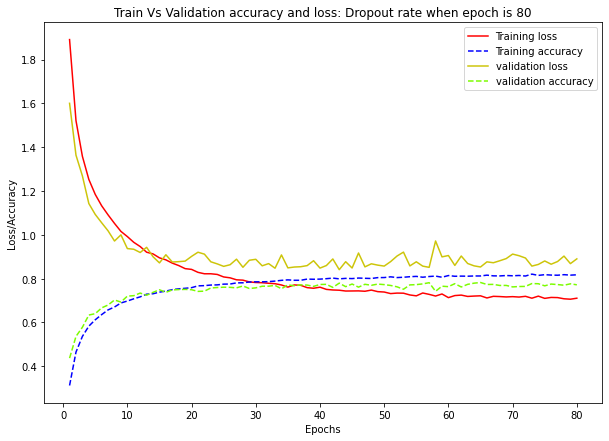

time: 222 ms (started: 2022-05-30 04:22:23 +00:00)


In [ ]:
# plot the training and validation accuracy and loss line charts
plt.figure(figsize=(10, 7))
line_mse = plt.plot(range(1,81), history_afterRandom_SearchCV1.history.history['loss'], 'r')
line_accuracy = plt.plot(range(1,81), history_afterRandom_SearchCV1.history.history['accuracy'],linestyle = 'dashed', color = 'b')
line_crossEntropy = plt.plot(range(1,81), history_afterRandom_SearchCV1.history.history['val_loss'], '#cdc50a')
line_valaccuracy = plt.plot(range(1,81), history_afterRandom_SearchCV1.history.history['val_accuracy'], linestyle = 'dashed', color='#7CFC00')
plt.title('Train Vs Validation accuracy and loss: Dropout rate when epoch is 80')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Training accuracy', 'validation loss', 'validation accuracy'])
print('\n')

<p>When network starts to run train the neurons validation accuracy is higher than training accuracy, but around the 17 epoch, training accuracy is higher than validation accuracy. The training accuracy is not bumpy as the validation accuracy.</p>

<p>Function that accepts all the RandomSearch optimal parameters and manually testing the optimal weight constraint</p>

In [ ]:
def deriveBestModelRandomSearch_kc(lambda_v=0.001, learningRate=0.001,dropout_rate=0.0, weight_constraint=1):
  """Function that derives and returns the network model"""
  model = models.Sequential()
  
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(lambda_v),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(dropout_rate))

  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(dropout_rate))

  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  # first dropout
  model.add(layers.Dropout(dropout_rate))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu', kernel_constraint=maxnorm(weight_constraint)))

  # last dropout
  model.add(layers.Dropout(dropout_rate))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above
  model.summary()

  opt = tf.keras.optimizers.Adam(learning_rate=learningRate)
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])

  # train the model
  history = model.fit(train_images, train_labels, epochs=80, batch_size=32, 
                      validation_data=(valid_images, valid_labels))

  return model

time: 28.6 ms (started: 2022-05-30 04:11:14 +00:00)


In [ ]:
history_afterRandom_SearchCV3 = deriveBestModelRandomSearch_kc(0.001, 0.001,0.2, 3)

Model: "sequential_275"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1311 (Conv2D)        (None, 32, 32, 32)        896       
                                                                 
 conv2d_1312 (Conv2D)        (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_716 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_484 (Dropout)       (None, 16, 16, 32)        0         
                                                                 
 conv2d_1313 (Conv2D)        (None, 16, 16, 64)        18496     
                                                                 
 conv2d_1314 (Conv2D)        (None, 16, 16, 64)        36928     
                                                    

In [ ]:
print('The validation accuracy is %.4f.' %(max(history_afterRandom_SearchCV3.history.history['val_accuracy'])))
print('The validation loss is %.4f.' %(min(history_afterRandom_SearchCV3.history.history['val_loss'])))

The validation accuracy is 0.7931.
The validation loss is 0.7804.
time: 3.71 ms (started: 2022-05-30 04:22:02 +00:00)


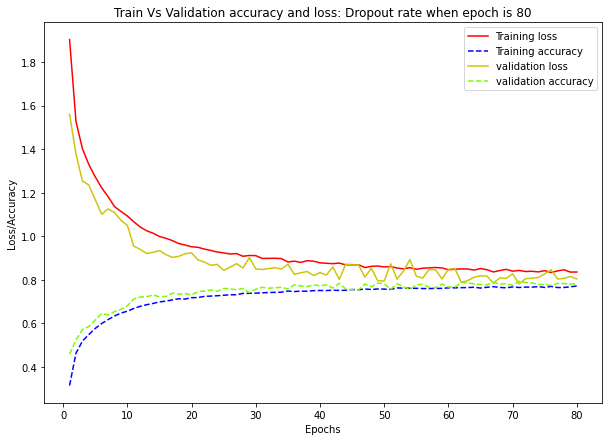

time: 223 ms (started: 2022-05-30 04:22:11 +00:00)


In [ ]:
plt.figure(figsize=(10, 7))
line_mse = plt.plot(range(1,81), history_afterRandom_SearchCV3.history.history['loss'], 'r')
line_accuracy = plt.plot(range(1,81), history_afterRandom_SearchCV3.history.history['accuracy'],linestyle = 'dashed', color = 'b')
line_crossEntropy = plt.plot(range(1,81), history_afterRandom_SearchCV3.history.history['val_loss'], '#cdc50a')
line_valaccuracy = plt.plot(range(1,81), history_afterRandom_SearchCV3.history.history['val_accuracy'], linestyle = 'dashed', color='#7CFC00')
plt.title('Train Vs Validation accuracy and loss: Dropout rate when epoch is 80')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Training accuracy', 'validation loss', 'validation accuracy'])
print('\n')

<p>Here we observe that validation accuracy is higher than training accuracy then the validation loss is so bumpy.</p>

In [ ]:
history_afterRandom_SearchCV4 = deriveBestModelRandomSearch_kc(0.001, 0.001,0.2, 4)

Model: "sequential_276"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1317 (Conv2D)        (None, 32, 32, 32)        896       
                                                                 
 conv2d_1318 (Conv2D)        (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_719 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_488 (Dropout)       (None, 16, 16, 32)        0         
                                                                 
 conv2d_1319 (Conv2D)        (None, 16, 16, 64)        18496     
                                                                 
 conv2d_1320 (Conv2D)        (None, 16, 16, 64)        36928     
                                                    

In [ ]:
print('The validation accuracy is %.4f.' %(max(history_afterRandom_SearchCV4.history.history['val_accuracy'])))
print('The validation loss is %.4f.' %(min(history_afterRandom_SearchCV4.history.history['val_loss'])))

The validation accuracy is 0.7826.
The validation loss is 0.8062.
time: 1.64 ms (started: 2022-05-30 04:32:53 +00:00)


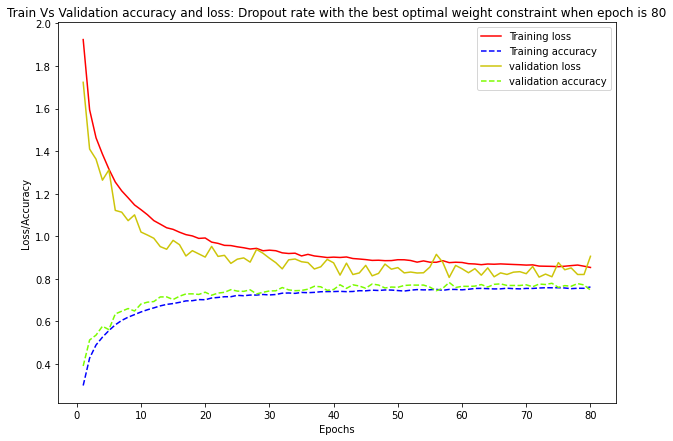

time: 236 ms (started: 2022-05-30 04:32:56 +00:00)


In [ ]:
plt.figure(figsize=(10, 7))
line_mse = plt.plot(range(1,81), history_afterRandom_SearchCV4.history.history['loss'], 'r')
line_accuracy = plt.plot(range(1,81), history_afterRandom_SearchCV4.history.history['accuracy'],linestyle = 'dashed', color = 'b')
line_crossEntropy = plt.plot(range(1,81), history_afterRandom_SearchCV4.history.history['val_loss'], '#cdc50a')
line_valaccuracy = plt.plot(range(1,81), history_afterRandom_SearchCV4.history.history['val_accuracy'], linestyle = 'dashed', color='#7CFC00')
plt.title('Train Vs Validation accuracy and loss: Dropout rate with the best optimal weight constraint when epoch is 80')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Training accuracy', 'validation loss', 'validation accuracy'])
print('\n')

<p>We see that validation accuracy is slighly higher than the validation accuracy. At some epochs, they touch each other., but over this is the best model with a good validation accuracy and a low validation loss and it is the oen I used for my final submission.</p>

In [ ]:
# let's make the required predictions
predictions = history_afterRandom_SearchCV4.predict([test_images])

time: 921 ms (started: 2022-05-29 23:58:17 +00:00)


In [ ]:
# let's convert a numpy array into a list
predictions_L = predictions.tolist()

# helper function that writes predictions Results to a csv file
writeResultsToCsv(predictions_L)

time: 159 ms (started: 2022-05-29 23:58:19 +00:00)


### Adding batch normalization 

In [ ]:
def deriveBestModelRandomSearch_kc(lambda_v=0.001, learningRate=0.001,dropout_rate=0.0, weight_constraint=1):
  """Function that derives and returns the network model"""
  model = models.Sequential()
  
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(lambda_v),input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(dropout_rate))

  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(dropout_rate))

  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.Conv2D(64, (3, 3), strides=(1,1) ,padding='same', kernel_regularizer=l2(lambda_v), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.MaxPooling2D((2, 2)))
  # first dropout
  model.add(layers.Dropout(dropout_rate))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model.add(layers.BatchNormalization())

  # last dropout
  model.add(layers.Dropout(dropout_rate))
  model.add(layers.Dense(10, activation='softmax'))  # As noted above
  model.summary()

  opt = tf.keras.optimizers.Adam(learning_rate=learningRate)
  model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # For TF2
              #loss='sparse_categorical_crossentropy', # For TF1
              metrics=['accuracy'])

  # train the model
  history = model.fit(train_images, train_labels, epochs=80, batch_size=32, 
                      validation_data=(valid_images, valid_labels))

  return model

time: 29.7 ms (started: 2022-05-30 04:35:51 +00:00)


In [ ]:
history_afterRandom_SearchCV5 = deriveBestModelRandomSearch_kc(0.001, 0.001,0.2, 4)

Model: "sequential_277"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1323 (Conv2D)        (None, 32, 32, 32)        896       
                                                                 
 conv2d_1324 (Conv2D)        (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_722 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_492 (Dropout)       (None, 16, 16, 32)        0         
                                                                 
 conv2d_1325 (Conv2D)        (None, 16, 16, 64)        18496     
                                                                 
 conv2d_1326 (Conv2D)        (None, 16, 16, 64)        36928     
                                                    

In [ ]:
print('The validation accuracy is %.4f.' %(max(history_afterRandom_SearchCV5.history.history['val_accuracy'])))
print('The validation loss is %.4f.' %(min(history_afterRandom_SearchCV5.history.history['val_loss'])))

The validation accuracy is 0.8058.
The validation loss is 0.7921.
time: 1.55 ms (started: 2022-05-30 04:50:24 +00:00)


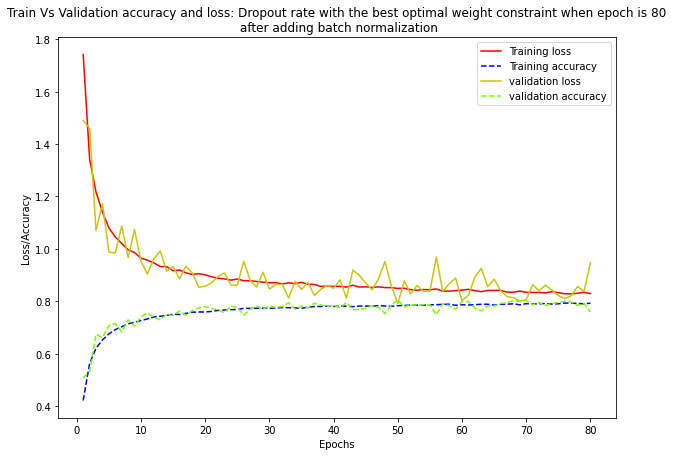

time: 260 ms (started: 2022-05-30 04:50:26 +00:00)


In [ ]:
plt.figure(figsize=(10, 7))
line_mse = plt.plot(range(1,81), history_afterRandom_SearchCV5.history.history['loss'], 'r')
line_accuracy = plt.plot(range(1,81), history_afterRandom_SearchCV5.history.history['accuracy'],linestyle = 'dashed', color = 'b')
line_crossEntropy = plt.plot(range(1,81), history_afterRandom_SearchCV5.history.history['val_loss'], '#cdc50a')
line_valaccuracy = plt.plot(range(1,81), history_afterRandom_SearchCV5.history.history['val_accuracy'], linestyle = 'dashed', color='#7CFC00')
plt.title('Train Vs Validation accuracy and loss: Dropout rate with the best optimal weight constraint when epoch is 80\n after adding batch normalization')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Training accuracy', 'validation loss', 'validation accuracy'])
print('\n')

<p>These results look interesting. Both validation accuracy and training accuracy out perform each other. Sometime there are equal. Sometimes there are slighly greater than one another. But overall, this could be the best model since its validation accuracy is high with a low validation loss with less overfitting.</p>